# End to End Deep Learning Architectures for Automatic Modulation Recognition

This project explores the application of Convolutional Neural Networks and their applications for Automatic Modulation Recognition on the RadioML and HisarMod Datasets.

**Author:** [Timothy Do](https://timothydo.me)

## Table of Contents
<li><a href="#setup">Setup</a></li>
<li><a href="#nn">Neural Network Architectures</a></li>
<li><a href="#radio2016">RadioML 2016.10A</a></li>
<li><a href="#radio2018">RadioML 2018.01A</a></li>
<li><a href="#hisar2019">Hisar2019.1</a></li>
<li><a href="#aug">Data Augmentation</a></li>

## Model References

<a href="https://arxiv.org/pdf/1602.04105.pdf">[1] T. J. O’Shea, J. Corgan, and T. C. Clancy, “Convolutional radio modulation recognition
networks,” in Engineering Applications of Neural Networks, C. Jayne and L. Iliadis, Eds.
Cham: Springer International Publishing, Aug. 2016, pp. 213-226</a> <br><br>
<a href="https://arxiv.org/pdf/1712.04578.pdf">[2] T. J. O’Shea, T. Roy, and T. C. Clancy, “Over-the-air deep learning based radio signal
classification,” IEEE J. Sel. Topics Signal Process., vol. 12, no. 1, pp. 168–179, Jan 
2018.2797</a> <br><br>
<a href="http://dx.doi.org/10.1109/VTC2020-Spring48590.2020.9128408"> [3] K. Tekbiyik, A. R. Ekti, A. Gorcin, G. K. Kurt, and C. Kececi, “Robust
and fast automatic modulation classification with cnn under multipath fading
channels,” in Proc. IEEE Veh. Technol. Conf. IEEE, May 2020. [Online]. Available:
http://dx.doi.org/10.1109/VTC2020-Spring48590.2020.9128408</a>

## <a name="setup">Setup</a>

In [2]:
!pip install -r requirements.txt

In [2]:
# Libraries
import h5py
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchsummary
import matlab.engine
import gc

# Custom Modules and Models
from models.OSheaCNN2016 import OSheaCNN2016
from models.OSheaCNN2018 import OSheaCNN2018
from models.HisarCNN2019 import HisarCNN2019
import models.train
import models.datasets

%load_ext autoreload
%autoreload 2

# Setup PyTorch Device (Assuming only Single Device)
device = 'cuda' if torch.cuda.is_available() else ('cpu')
device = torch.device(device)
gpuName = f'({torch.cuda.get_device_name(device)})' if torch.cuda.is_available() else ''
print(f'Using PyTorch Backend: {device} {gpuName}')

# Checking if the Data Path Exists for Each Dataset. Change to wherever your datasets are stored.
radioML2016 = "datasets/RML2016.10a/RML2016.10a_dict.pkl"
radioML2018 = "datasets/2018.01.OSC.0001_1024x2M.h5/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5"
hisar2019Dir = "datasets/HisarMod2019.1"
if(not(os.path.exists(radioML2016))):
    print("Please Retrieve the RadioML 2016.10A Dataset and Try Again.")
if(not(os.path.exists(radioML2018))):
    print("Please Retrieve the RadioML 2018.01A Dataset and Try Again.")
if(not(os.path.exists(hisar2019Dir))):
    print("Please Retrieve the HisarMod Dataset and Try Again.")

# Helper Function that Clears all the Dataset Variables in Memory 
def clearDatasetVars(tensors=False,verbose=False):
    datasetVars = ['X','Y','Z','X_train','X_train_val','Y_train','Y_train_val','X_val','Y_val','X_test','Y_test']
    if(tensors): # Add Tensor Variables Needed for Model Training
        tensorVars = ['train_data','valid_data','test_data','train_loader','val_loader','test_loader',
                      'model','best_model','Z_train_val','Z_train','Z_val','Z_test']
        datasetVars += tensorVars
    for datasetVar in datasetVars: # Delete in Global Variables if it Exists
        if datasetVar in globals():
            del globals()[datasetVar]
            if(verbose):
                print(f'Deleted {datasetVar}')
    gc.collect() # Disposing Garbage Memory
    if(torch.cuda.is_available()): # Free GPU Memory
        torch.cuda.empty_cache()

Using PyTorch Backend: cuda (NVIDIA GeForce RTX 3090)


## <a name="nn">Neural Network Architectures</a>

### 1. OSheaCNN2016 (RadioML 2016.10A)

In [14]:
s = torchsummary.summary(OSheaCNN2016(),(2,128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 64, 128]             448
├─ReLU: 1-2                              [-1, 64, 128]             --
├─Dropout: 1-3                           [-1, 64, 128]             --
├─Conv1d: 1-4                            [-1, 16, 128]             3,088
├─ReLU: 1-5                              [-1, 16, 128]             --
├─Dropout: 1-6                           [-1, 16, 128]             --
├─Linear: 1-7                            [-1, 128]                 262,272
├─ReLU: 1-8                              [-1, 128]                 --
├─Dropout: 1-9                           [-1, 128]                 --
├─Linear: 1-10                           [-1, 11]                  1,419
├─Softmax: 1-11                          [-1, 11]                  --
Total params: 267,227
Trainable params: 267,227
Non-trainable params: 0
Total mult-adds (M): 0.71
Input size (MB): 0.00
Forward/backward pass s

### 2. OSheaCNN2018 (RadioML 2018.01A)

In [15]:
s = torchsummary.summary(OSheaCNN2018(),(2,1024))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 64, 1024]            448
├─MaxPool1d: 1-2                         [-1, 64, 512]             --
├─SELU: 1-3                              [-1, 64, 512]             --
├─Conv1d: 1-4                            [-1, 64, 512]             12,352
├─MaxPool1d: 1-5                         [-1, 64, 256]             --
├─SELU: 1-6                              [-1, 64, 256]             --
├─Conv1d: 1-7                            [-1, 64, 256]             12,352
├─MaxPool1d: 1-8                         [-1, 64, 128]             --
├─SELU: 1-9                              [-1, 64, 128]             --
├─Conv1d: 1-10                           [-1, 64, 128]             12,352
├─MaxPool1d: 1-11                        [-1, 64, 64]              --
├─SELU: 1-12                             [-1, 64, 64]              --
├─Conv1d: 1-13                           [-1, 64, 64]              12,35

### 3. HisarCNN2019 (Hisar 2019.1)

In [16]:
s = torchsummary.summary(HisarCNN2019(),(2,1024))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 64, 1024]            448
├─MaxPool1d: 1-2                         [-1, 64, 512]             --
├─SELU: 1-3                              [-1, 64, 512]             --
├─Conv1d: 1-4                            [-1, 64, 512]             12,352
├─MaxPool1d: 1-5                         [-1, 64, 256]             --
├─SELU: 1-6                              [-1, 64, 256]             --
├─Conv1d: 1-7                            [-1, 64, 256]             12,352
├─MaxPool1d: 1-8                         [-1, 64, 128]             --
├─SELU: 1-9                              [-1, 64, 128]             --
├─Conv1d: 1-10                           [-1, 64, 128]             12,352
├─MaxPool1d: 1-11                        [-1, 64, 64]              --
├─SELU: 1-12                             [-1, 64, 64]              --
├─Conv1d: 1-13                           [-1, 64, 64]              12,35

## <a name="radio2016">RadioML 2016.01A</a>

Let's load in the RadioML 2016.01A Dataset from [Deepsig](https://deepsig.ai/datasets)!

### Data Visualization 

In [3]:
# Printing Shapes
clearDatasetVars(tensors=True)
X,Y,Z,modClasses,SNRs = models.datasets.loadRadioML2016(radioML2016)
print(X.shape)
print(Y.shape)
print(Z.shape)
N = X.shape[0]

(220000, 128, 2)
(220000, 11)
(220000, 1)


In [33]:
# Extracting Variables
labels = np.argmax(Y,axis=-1) # Decode One-Hot Encodings
classes = np.unique(labels)
print("SNRs [dB]: ",SNRs)
print("Classes: ", classes)
print("Classes Names:",modClasses)

SNRs [dB]:  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, -20, -18, -16, -14, -12, -10, -8, -6, -4, -2]
Classes:  [ 0  1  2  3  4  5  6  7  8  9 10]
Classes Names: ['CPFSK', 'QPSK', 'WBFM', 'BPSK', 'PAM4', 'QAM16', '8PSK', 'GFSK', 'AM-DSB', 'QAM64', 'AM-SSB']


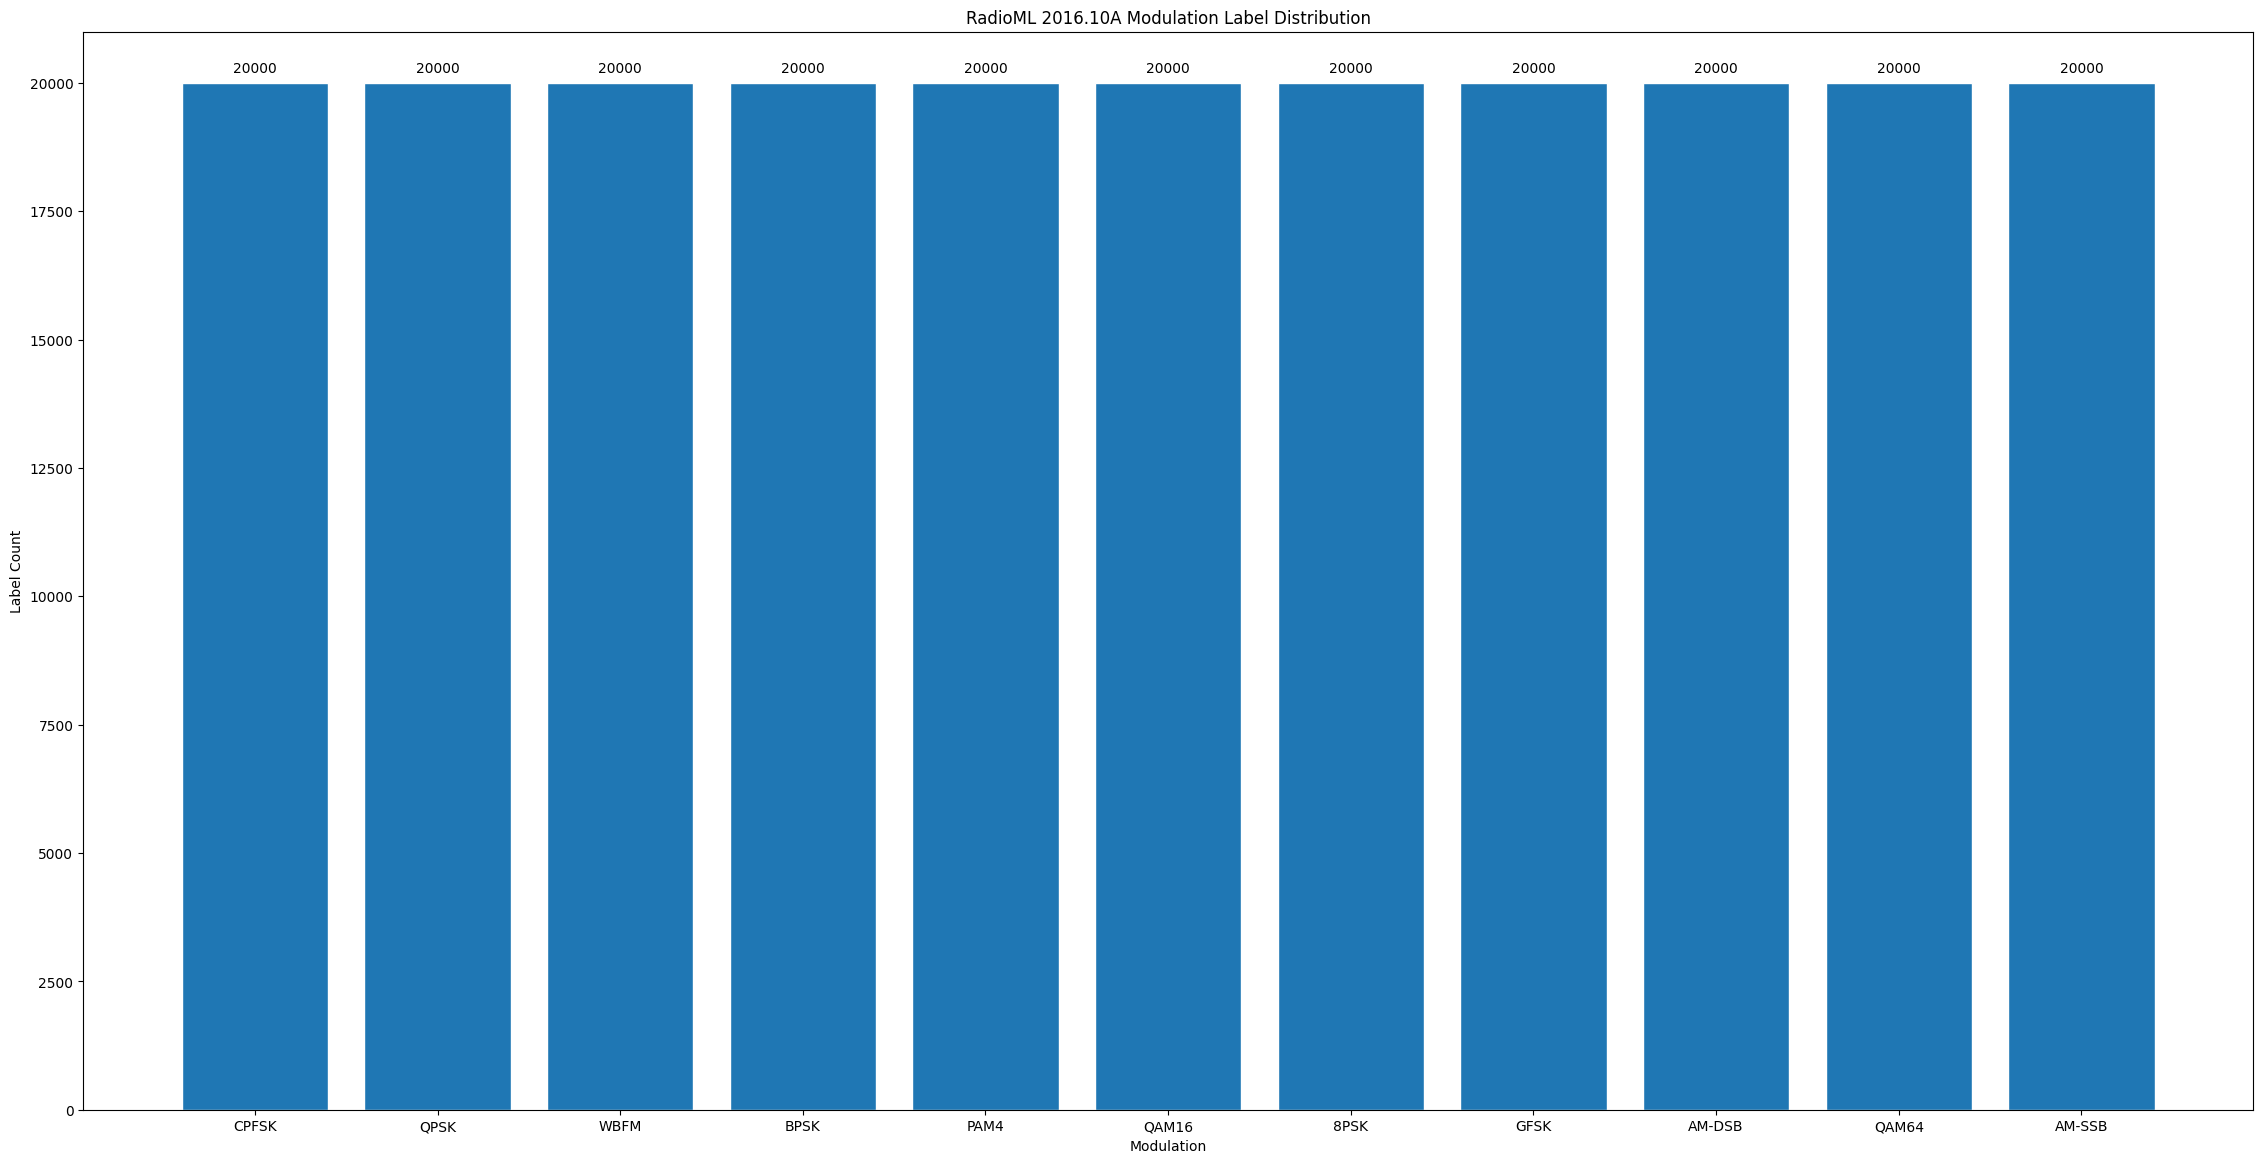

In [34]:
# Label Distribution across Modulation Classes
plt.figure(figsize=(28,14))
counts, bins = np.histogram(labels,bins=len(classes))
trainTitle = plt.title('RadioML 2016.10A Modulation Label Distribution')
trainXLabel = plt.xlabel('Modulation')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(modClasses,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')
plt.savefig('./results/RadioML2016_ModLabelDist.png')
plt.show()

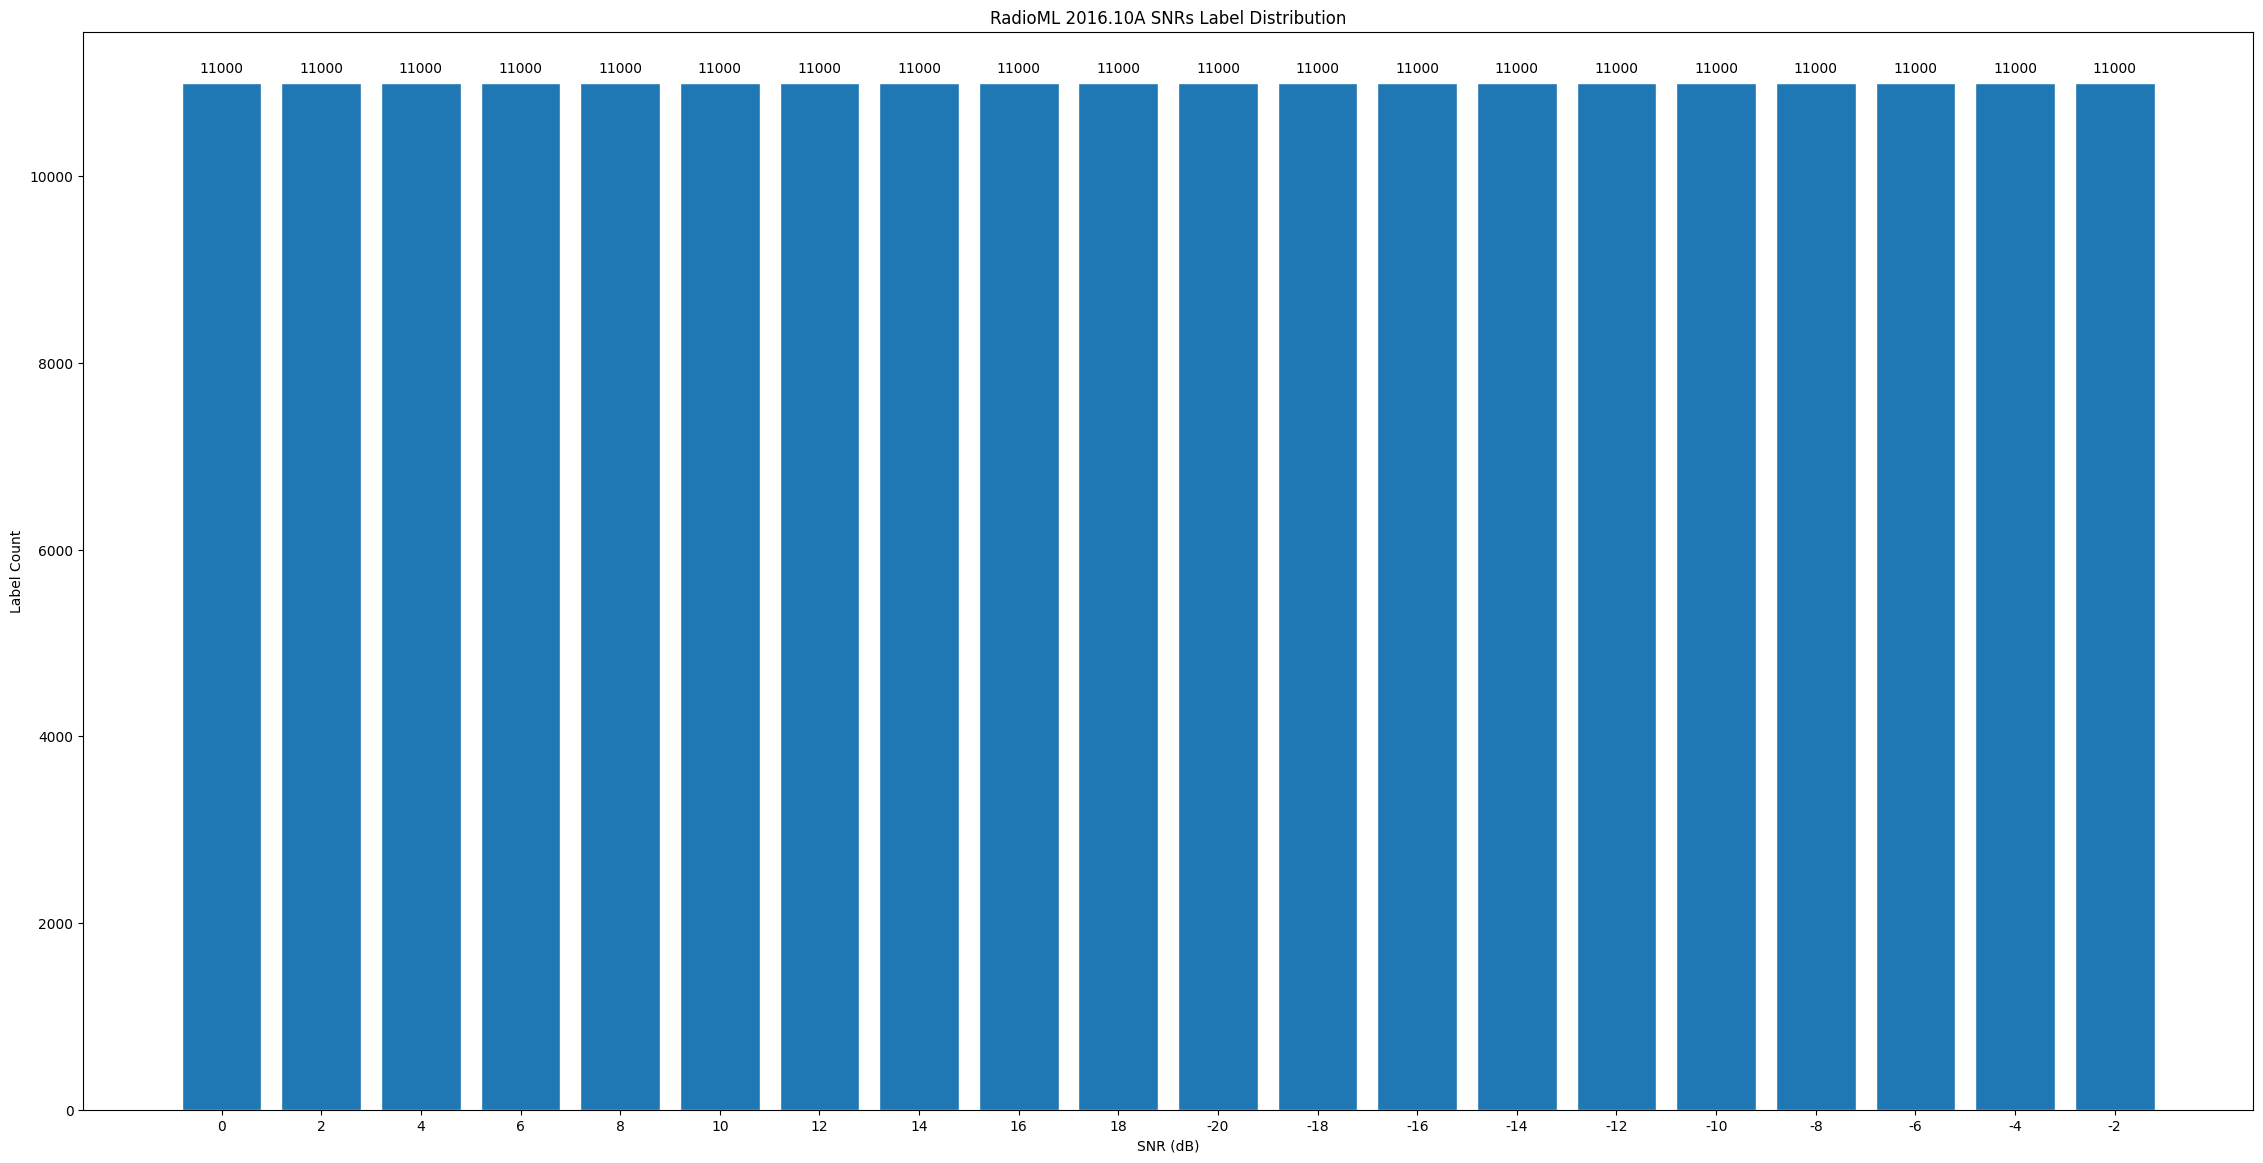

In [35]:
# Label Distribution across SNRs
SNRs_str = [str(SNR) for SNR in SNRs]
plt.figure(figsize=(28,14))
counts, bins = np.histogram(Z,bins=len(SNRs))
trainTitle = plt.title('RadioML 2016.10A SNRs Label Distribution')
trainXLabel = plt.xlabel('SNR (dB)')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(SNRs_str,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')
plt.savefig('./results/RadioML2016_SNRLabelDist.png')
plt.show()

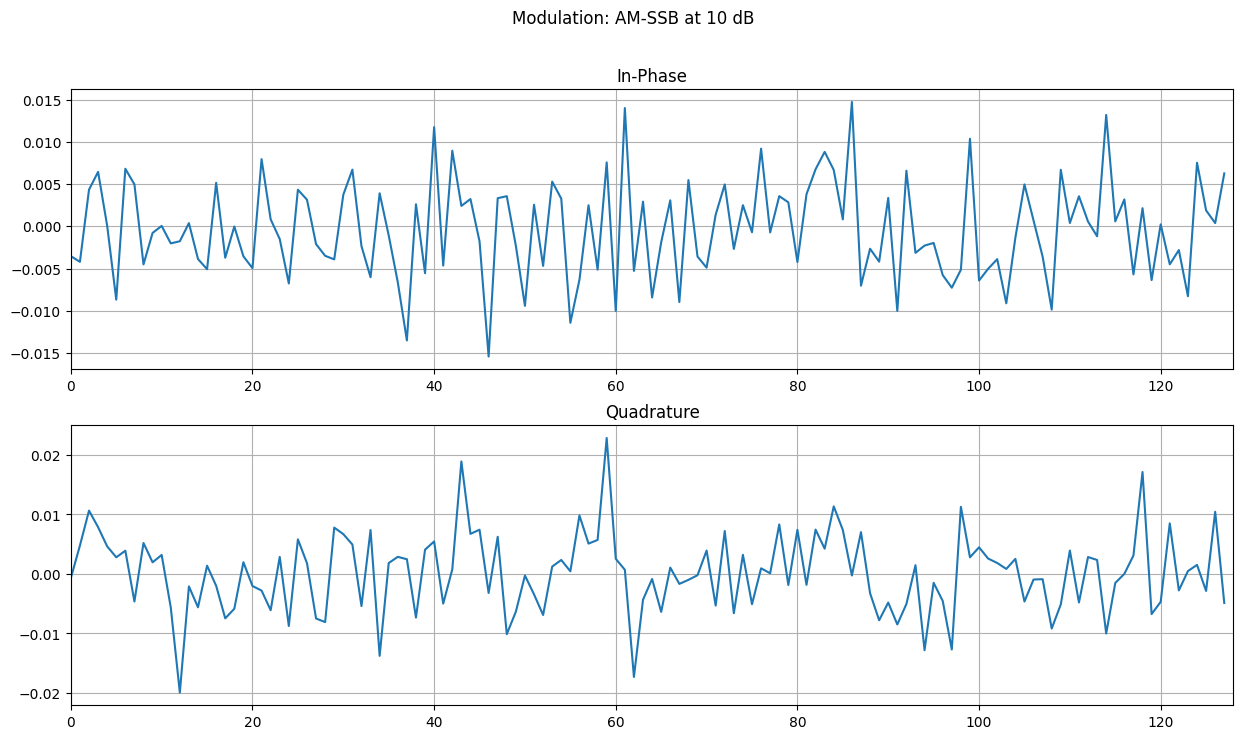

In [45]:
# IQ Temporal Sequence
index = 190000
plt.figure(figsize=(15,8))
plt.suptitle(f'Modulation: {modClasses[labels[index]]} at {Z[index][0]} dB')
plt.subplot(2,1,1)
plt.title('In-Phase')
plt.grid()
plt.plot(X[index,:,0])
plt.xlim(0,X.shape[1])
plt.subplot(2,1,2)
plt.grid()
plt.title('Quadrature')
plt.plot(X[index,:,1])
plt.xlim(0,X.shape[1])
plt.savefig(f'./results/RadioML2016_{index}_Temporal.png')
plt.show()

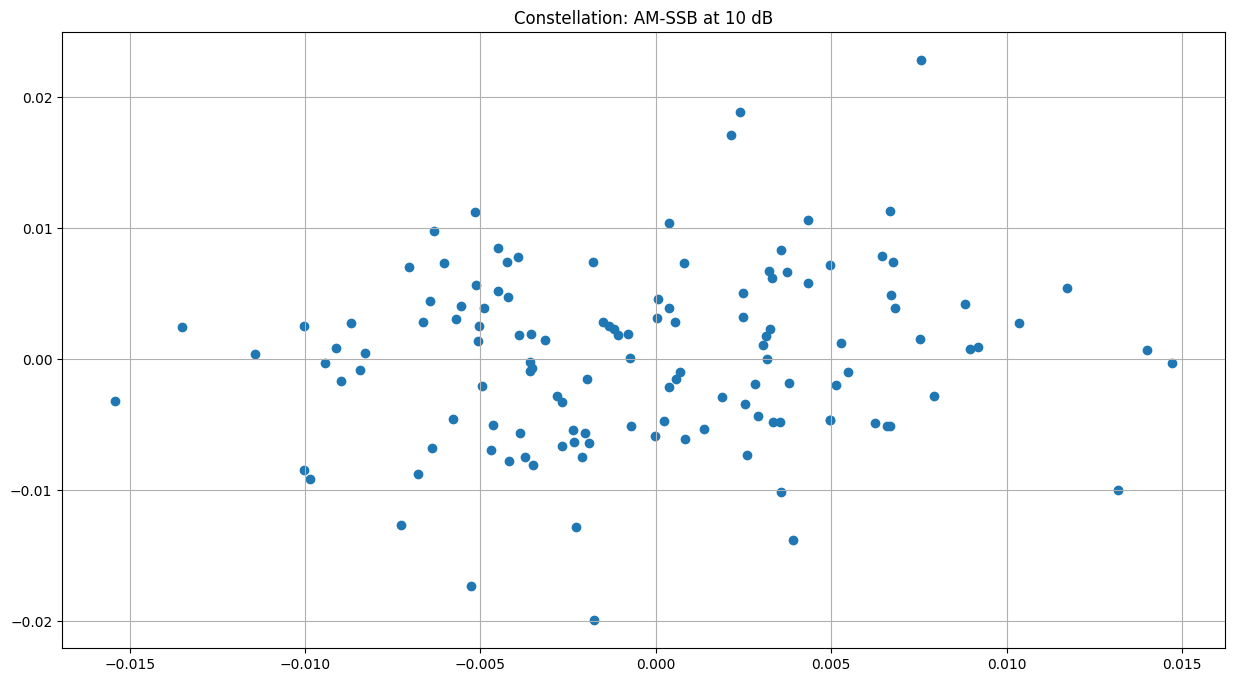

In [46]:
# Constellatino Visualization
plt.figure(figsize=(15,8))
plt.title(f'Constellation: {modClasses[labels[index]]} at {Z[index][0]} dB')
plt.scatter(X[index,:,0],X[index,:,1])
plt.grid()
plt.savefig(f'./results/RadioML2016_{index}_Constellation.png')
plt.show()

### Data Preparation

In [38]:
# Split Data into Train,Val,Test Subsets (90-5-5)%

# Warning: Memory Intensive (Can Take Upwards of 64 GB)
split = np.array([90,5,5])/100
batch_size = 1024
clearDatasetVars(tensors=True)
X,Y,Z,modClasses,SNRs = models.datasets.loadRadioML2016(radioML2016)
train_data,val_data,test_data,train_loader,val_loader,test_loader,Z_test = models.datasets.prepareDatasetRadioML(X,Y,Z,split,batch_size)

# Freeing Memory of Intermediate Values 
clearDatasetVars(tensors=False)

### Model Training and Evaluation

In [41]:
use_pretrained = False

# Define the loss function 
criterion = nn.CrossEntropyLoss()

if(use_pretrained): # Evaluate Pre-Trained Models
    modelDir = './models/OSheaCNN2016_250_best.pt'
    model = torch.load(modelDir)
    test_acc =  models.train.eval(device,model,test_loader)
    print(f'Overall Test Acc: {test_acc:.3f}')
else: # Training Model
    model = OSheaCNN2016().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)
    num_epochs = 250
    if(device == 'cuda'): # Free any Device Memory before Start Training
        torch.cuda.empty_cache()
    train_loss, val_loss, min_val_loss, best_model =  models.train.train_earlystop(device,model,criterion,optimizer,train_loader,val_loader,test_loader,num_epochs)
    torch.save(model,f'./models/OSheaCNN2016_{num_epochs}_last.pt')
    torch.save(best_model,f'./models/OSheaCNN2016_{num_epochs}_best.pt')
    test_last_acc = models.train.eval(device,model,test_loader)
    test_best_acc = models.train.eval(device,best_model,test_loader)
    print(f'\nOverall Test Acc (Last Epoch): {test_last_acc:.3f}')
    print(f'Overall Test Acc (Best Val): {test_best_acc:.3f}')


Starting to Train OSheaCNN2016 for 250 Epochs!


  0%|▎                                                                                 | 1/250 [00:01<07:35,  1.83s/it]

Epoch [1/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.092, Val Acc: 0.090


  1%|▋                                                                                 | 2/250 [00:03<06:59,  1.69s/it]

Epoch [2/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.091, Val Acc: 0.090


  1%|▉                                                                                 | 3/250 [00:05<06:51,  1.67s/it]

Epoch [3/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.091, Val Acc: 0.090


  2%|█▎                                                                                | 4/250 [00:06<06:48,  1.66s/it]

Epoch [4/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.091, Val Acc: 0.090


  2%|█▋                                                                                | 5/250 [00:08<06:45,  1.65s/it]

Epoch [5/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.091, Val Acc: 0.089


  2%|█▉                                                                                | 6/250 [00:09<06:39,  1.64s/it]

Epoch [6/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.091, Val Acc: 0.090


  3%|██▎                                                                               | 7/250 [00:11<06:41,  1.65s/it]

Epoch [7/250]: Train Loss: 2.397 Val Loss: 2.397 Train Acc: 0.094, Val Acc: 0.093


  3%|██▌                                                                               | 8/250 [00:13<06:36,  1.64s/it]

Epoch [8/250]: Train Loss: 2.378 Val Loss: 2.376 Train Acc: 0.105, Val Acc: 0.130


  4%|██▉                                                                               | 9/250 [00:14<06:34,  1.64s/it]

Epoch [9/250]: Train Loss: 2.354 Val Loss: 2.358 Train Acc: 0.134, Val Acc: 0.157


  4%|███▏                                                                             | 10/250 [00:16<06:32,  1.63s/it]

Epoch [10/250]: Train Loss: 2.341 Val Loss: 2.354 Train Acc: 0.148, Val Acc: 0.181


  4%|███▌                                                                             | 11/250 [00:18<06:29,  1.63s/it]

Epoch [11/250]: Train Loss: 2.356 Val Loss: 2.350 Train Acc: 0.158, Val Acc: 0.182


  5%|███▉                                                                             | 12/250 [00:19<06:25,  1.62s/it]

Epoch [12/250]: Train Loss: 2.348 Val Loss: 2.347 Train Acc: 0.164, Val Acc: 0.186


  5%|████▏                                                                            | 13/250 [00:21<06:25,  1.63s/it]

Epoch [13/250]: Train Loss: 2.348 Val Loss: 2.344 Train Acc: 0.171, Val Acc: 0.189


  6%|████▌                                                                            | 14/250 [00:22<06:23,  1.62s/it]

Epoch [14/250]: Train Loss: 2.343 Val Loss: 2.342 Train Acc: 0.177, Val Acc: 0.192


  6%|████▊                                                                            | 15/250 [00:24<06:22,  1.63s/it]

Epoch [15/250]: Train Loss: 2.328 Val Loss: 2.341 Train Acc: 0.183, Val Acc: 0.191


  6%|█████▏                                                                           | 16/250 [00:26<06:20,  1.63s/it]

Epoch [16/250]: Train Loss: 2.324 Val Loss: 2.337 Train Acc: 0.187, Val Acc: 0.201


  7%|█████▌                                                                           | 17/250 [00:27<06:20,  1.63s/it]

Epoch [17/250]: Train Loss: 2.325 Val Loss: 2.334 Train Acc: 0.194, Val Acc: 0.202


  7%|█████▊                                                                           | 18/250 [00:29<06:22,  1.65s/it]

Epoch [18/250]: Train Loss: 2.337 Val Loss: 2.332 Train Acc: 0.199, Val Acc: 0.202


  8%|██████▏                                                                          | 19/250 [00:31<06:17,  1.63s/it]

Epoch [19/250]: Train Loss: 2.315 Val Loss: 2.335 Train Acc: 0.203, Val Acc: 0.197


  8%|██████▍                                                                          | 20/250 [00:32<06:15,  1.63s/it]

Epoch [20/250]: Train Loss: 2.319 Val Loss: 2.331 Train Acc: 0.206, Val Acc: 0.203


  8%|██████▊                                                                          | 21/250 [00:34<06:12,  1.63s/it]

Epoch [21/250]: Train Loss: 2.307 Val Loss: 2.330 Train Acc: 0.210, Val Acc: 0.202


  9%|███████▏                                                                         | 22/250 [00:36<06:14,  1.64s/it]

Epoch [22/250]: Train Loss: 2.327 Val Loss: 2.326 Train Acc: 0.213, Val Acc: 0.211


  9%|███████▍                                                                         | 23/250 [00:37<06:09,  1.63s/it]

Epoch [23/250]: Train Loss: 2.303 Val Loss: 2.325 Train Acc: 0.217, Val Acc: 0.210


 10%|███████▊                                                                         | 24/250 [00:39<06:07,  1.63s/it]

Epoch [24/250]: Train Loss: 2.270 Val Loss: 2.319 Train Acc: 0.218, Val Acc: 0.222


 10%|████████                                                                         | 25/250 [00:40<06:06,  1.63s/it]

Epoch [25/250]: Train Loss: 2.311 Val Loss: 2.319 Train Acc: 0.220, Val Acc: 0.220


 10%|████████▍                                                                        | 26/250 [00:42<06:03,  1.62s/it]

Epoch [26/250]: Train Loss: 2.315 Val Loss: 2.321 Train Acc: 0.222, Val Acc: 0.215


 11%|████████▋                                                                        | 27/250 [00:44<06:00,  1.62s/it]

Epoch [27/250]: Train Loss: 2.308 Val Loss: 2.315 Train Acc: 0.224, Val Acc: 0.224


 11%|█████████                                                                        | 28/250 [00:45<05:58,  1.62s/it]

Epoch [28/250]: Train Loss: 2.326 Val Loss: 2.309 Train Acc: 0.226, Val Acc: 0.233


 12%|█████████▍                                                                       | 29/250 [00:47<05:56,  1.61s/it]

Epoch [29/250]: Train Loss: 2.299 Val Loss: 2.316 Train Acc: 0.227, Val Acc: 0.221


 12%|█████████▋                                                                       | 30/250 [00:49<05:56,  1.62s/it]

Epoch [30/250]: Train Loss: 2.293 Val Loss: 2.310 Train Acc: 0.229, Val Acc: 0.231


 12%|██████████                                                                       | 31/250 [00:50<05:53,  1.61s/it]

Epoch [31/250]: Train Loss: 2.304 Val Loss: 2.308 Train Acc: 0.230, Val Acc: 0.232


 13%|██████████▎                                                                      | 32/250 [00:52<06:00,  1.66s/it]

Epoch [32/250]: Train Loss: 2.306 Val Loss: 2.302 Train Acc: 0.232, Val Acc: 0.240


 13%|██████████▋                                                                      | 33/250 [00:54<06:01,  1.67s/it]

Epoch [33/250]: Train Loss: 2.294 Val Loss: 2.306 Train Acc: 0.234, Val Acc: 0.233


 14%|███████████                                                                      | 34/250 [00:55<05:57,  1.65s/it]

Epoch [34/250]: Train Loss: 2.300 Val Loss: 2.305 Train Acc: 0.235, Val Acc: 0.233


 14%|███████████▎                                                                     | 35/250 [00:57<05:52,  1.64s/it]

Epoch [35/250]: Train Loss: 2.279 Val Loss: 2.296 Train Acc: 0.237, Val Acc: 0.245


 14%|███████████▋                                                                     | 36/250 [00:58<05:48,  1.63s/it]

Epoch [36/250]: Train Loss: 2.278 Val Loss: 2.292 Train Acc: 0.240, Val Acc: 0.249


 15%|███████████▉                                                                     | 37/250 [01:00<05:50,  1.65s/it]

Epoch [37/250]: Train Loss: 2.285 Val Loss: 2.295 Train Acc: 0.242, Val Acc: 0.246


 15%|████████████▎                                                                    | 38/250 [01:02<05:46,  1.64s/it]

Epoch [38/250]: Train Loss: 2.260 Val Loss: 2.287 Train Acc: 0.244, Val Acc: 0.253


 16%|████████████▋                                                                    | 39/250 [01:03<05:44,  1.63s/it]

Epoch [39/250]: Train Loss: 2.273 Val Loss: 2.281 Train Acc: 0.248, Val Acc: 0.262


 16%|████████████▉                                                                    | 40/250 [01:05<05:41,  1.63s/it]

Epoch [40/250]: Train Loss: 2.271 Val Loss: 2.280 Train Acc: 0.252, Val Acc: 0.263


 16%|█████████████▎                                                                   | 41/250 [01:07<05:38,  1.62s/it]

Epoch [41/250]: Train Loss: 2.273 Val Loss: 2.276 Train Acc: 0.254, Val Acc: 0.270


 17%|█████████████▌                                                                   | 42/250 [01:08<05:37,  1.62s/it]

Epoch [42/250]: Train Loss: 2.280 Val Loss: 2.279 Train Acc: 0.256, Val Acc: 0.267


 17%|█████████████▉                                                                   | 43/250 [01:10<05:34,  1.62s/it]

Epoch [43/250]: Train Loss: 2.290 Val Loss: 2.276 Train Acc: 0.259, Val Acc: 0.271


 18%|██████████████▎                                                                  | 44/250 [01:11<05:36,  1.63s/it]

Epoch [44/250]: Train Loss: 2.285 Val Loss: 2.275 Train Acc: 0.260, Val Acc: 0.271


 18%|██████████████▌                                                                  | 45/250 [01:13<05:33,  1.63s/it]

Epoch [45/250]: Train Loss: 2.232 Val Loss: 2.272 Train Acc: 0.262, Val Acc: 0.275


 18%|██████████████▉                                                                  | 46/250 [01:15<05:31,  1.62s/it]

Epoch [46/250]: Train Loss: 2.286 Val Loss: 2.274 Train Acc: 0.263, Val Acc: 0.275


 19%|███████████████▏                                                                 | 47/250 [01:16<05:29,  1.62s/it]

Epoch [47/250]: Train Loss: 2.253 Val Loss: 2.274 Train Acc: 0.264, Val Acc: 0.275


 19%|███████████████▌                                                                 | 48/250 [01:18<05:28,  1.63s/it]

Epoch [48/250]: Train Loss: 2.243 Val Loss: 2.270 Train Acc: 0.265, Val Acc: 0.281


 20%|███████████████▉                                                                 | 49/250 [01:20<05:25,  1.62s/it]

Epoch [49/250]: Train Loss: 2.281 Val Loss: 2.270 Train Acc: 0.266, Val Acc: 0.279


 20%|████████████████▏                                                                | 50/250 [01:21<05:23,  1.62s/it]

Epoch [50/250]: Train Loss: 2.260 Val Loss: 2.268 Train Acc: 0.267, Val Acc: 0.282


 20%|████████████████▌                                                                | 51/250 [01:23<05:21,  1.62s/it]

Epoch [51/250]: Train Loss: 2.274 Val Loss: 2.267 Train Acc: 0.268, Val Acc: 0.284


 21%|████████████████▊                                                                | 52/250 [01:24<05:19,  1.62s/it]

Epoch [52/250]: Train Loss: 2.263 Val Loss: 2.266 Train Acc: 0.270, Val Acc: 0.286


 21%|█████████████████▏                                                               | 53/250 [01:26<05:21,  1.63s/it]

Epoch [53/250]: Train Loss: 2.260 Val Loss: 2.263 Train Acc: 0.271, Val Acc: 0.287


 22%|█████████████████▍                                                               | 54/250 [01:28<05:19,  1.63s/it]

Epoch [54/250]: Train Loss: 2.252 Val Loss: 2.264 Train Acc: 0.272, Val Acc: 0.288


 22%|█████████████████▊                                                               | 55/250 [01:29<05:16,  1.63s/it]

Epoch [55/250]: Train Loss: 2.250 Val Loss: 2.265 Train Acc: 0.273, Val Acc: 0.288


 22%|██████████████████▏                                                              | 56/250 [01:31<05:15,  1.63s/it]

Epoch [56/250]: Train Loss: 2.248 Val Loss: 2.260 Train Acc: 0.274, Val Acc: 0.291


 23%|██████████████████▍                                                              | 57/250 [01:33<05:12,  1.62s/it]

Epoch [57/250]: Train Loss: 2.264 Val Loss: 2.258 Train Acc: 0.275, Val Acc: 0.293


 23%|██████████████████▊                                                              | 58/250 [01:34<05:12,  1.63s/it]

Epoch [58/250]: Train Loss: 2.230 Val Loss: 2.258 Train Acc: 0.277, Val Acc: 0.294


 24%|███████████████████                                                              | 59/250 [01:36<05:09,  1.62s/it]

Epoch [59/250]: Train Loss: 2.235 Val Loss: 2.257 Train Acc: 0.279, Val Acc: 0.296


 24%|███████████████████▍                                                             | 60/250 [01:37<05:07,  1.62s/it]

Epoch [60/250]: Train Loss: 2.272 Val Loss: 2.255 Train Acc: 0.279, Val Acc: 0.298


 24%|███████████████████▊                                                             | 61/250 [01:39<05:08,  1.63s/it]

Epoch [61/250]: Train Loss: 2.266 Val Loss: 2.257 Train Acc: 0.280, Val Acc: 0.298


 25%|████████████████████                                                             | 62/250 [01:41<05:07,  1.63s/it]

Epoch [62/250]: Train Loss: 2.262 Val Loss: 2.257 Train Acc: 0.282, Val Acc: 0.299


 25%|████████████████████▍                                                            | 63/250 [01:42<05:04,  1.63s/it]

Epoch [63/250]: Train Loss: 2.242 Val Loss: 2.254 Train Acc: 0.283, Val Acc: 0.300


 26%|████████████████████▋                                                            | 64/250 [01:44<05:02,  1.62s/it]

Epoch [64/250]: Train Loss: 2.254 Val Loss: 2.251 Train Acc: 0.284, Val Acc: 0.301


 26%|█████████████████████                                                            | 65/250 [01:46<04:59,  1.62s/it]

Epoch [65/250]: Train Loss: 2.254 Val Loss: 2.250 Train Acc: 0.285, Val Acc: 0.300


 26%|█████████████████████▍                                                           | 66/250 [01:47<04:58,  1.62s/it]

Epoch [66/250]: Train Loss: 2.246 Val Loss: 2.251 Train Acc: 0.286, Val Acc: 0.301


 27%|█████████████████████▋                                                           | 67/250 [01:49<04:55,  1.61s/it]

Epoch [67/250]: Train Loss: 2.226 Val Loss: 2.250 Train Acc: 0.286, Val Acc: 0.302


 27%|██████████████████████                                                           | 68/250 [01:50<04:53,  1.61s/it]

Epoch [68/250]: Train Loss: 2.272 Val Loss: 2.246 Train Acc: 0.287, Val Acc: 0.303


 28%|██████████████████████▎                                                          | 69/250 [01:52<04:57,  1.64s/it]

Epoch [69/250]: Train Loss: 2.230 Val Loss: 2.248 Train Acc: 0.288, Val Acc: 0.302


 28%|██████████████████████▋                                                          | 70/250 [01:54<05:01,  1.68s/it]

Epoch [70/250]: Train Loss: 2.245 Val Loss: 2.248 Train Acc: 0.289, Val Acc: 0.302


 28%|███████████████████████                                                          | 71/250 [01:56<05:01,  1.68s/it]

Epoch [71/250]: Train Loss: 2.225 Val Loss: 2.245 Train Acc: 0.290, Val Acc: 0.305


 29%|███████████████████████▎                                                         | 72/250 [01:57<05:03,  1.70s/it]

Epoch [72/250]: Train Loss: 2.243 Val Loss: 2.245 Train Acc: 0.290, Val Acc: 0.306


 29%|███████████████████████▋                                                         | 73/250 [01:59<04:58,  1.69s/it]

Epoch [73/250]: Train Loss: 2.215 Val Loss: 2.243 Train Acc: 0.291, Val Acc: 0.304


 30%|███████████████████████▉                                                         | 74/250 [02:01<04:52,  1.66s/it]

Epoch [74/250]: Train Loss: 2.233 Val Loss: 2.244 Train Acc: 0.291, Val Acc: 0.306


 30%|████████████████████████▎                                                        | 75/250 [02:02<04:48,  1.65s/it]

Epoch [75/250]: Train Loss: 2.252 Val Loss: 2.241 Train Acc: 0.292, Val Acc: 0.306


 30%|████████████████████████▌                                                        | 76/250 [02:04<04:47,  1.65s/it]

Epoch [76/250]: Train Loss: 2.268 Val Loss: 2.244 Train Acc: 0.293, Val Acc: 0.305


 31%|████████████████████████▉                                                        | 77/250 [02:05<04:44,  1.64s/it]

Epoch [77/250]: Train Loss: 2.235 Val Loss: 2.237 Train Acc: 0.293, Val Acc: 0.309


 31%|█████████████████████████▎                                                       | 78/250 [02:07<04:41,  1.64s/it]

Epoch [78/250]: Train Loss: 2.200 Val Loss: 2.239 Train Acc: 0.294, Val Acc: 0.308


 32%|█████████████████████████▌                                                       | 79/250 [02:09<04:38,  1.63s/it]

Epoch [79/250]: Train Loss: 2.207 Val Loss: 2.238 Train Acc: 0.295, Val Acc: 0.309


 32%|█████████████████████████▉                                                       | 80/250 [02:10<04:35,  1.62s/it]

Epoch [80/250]: Train Loss: 2.263 Val Loss: 2.240 Train Acc: 0.296, Val Acc: 0.308


 32%|██████████████████████████▏                                                      | 81/250 [02:12<04:33,  1.62s/it]

Epoch [81/250]: Train Loss: 2.224 Val Loss: 2.238 Train Acc: 0.296, Val Acc: 0.309


 33%|██████████████████████████▌                                                      | 82/250 [02:14<04:33,  1.63s/it]

Epoch [82/250]: Train Loss: 2.237 Val Loss: 2.235 Train Acc: 0.297, Val Acc: 0.312


 33%|██████████████████████████▉                                                      | 83/250 [02:15<04:30,  1.62s/it]

Epoch [83/250]: Train Loss: 2.266 Val Loss: 2.234 Train Acc: 0.297, Val Acc: 0.313


 34%|███████████████████████████▏                                                     | 84/250 [02:17<04:29,  1.62s/it]

Epoch [84/250]: Train Loss: 2.215 Val Loss: 2.234 Train Acc: 0.298, Val Acc: 0.311


 34%|███████████████████████████▌                                                     | 85/250 [02:18<04:30,  1.64s/it]

Epoch [85/250]: Train Loss: 2.270 Val Loss: 2.234 Train Acc: 0.298, Val Acc: 0.313


 34%|███████████████████████████▊                                                     | 86/250 [02:20<04:30,  1.65s/it]

Epoch [86/250]: Train Loss: 2.226 Val Loss: 2.232 Train Acc: 0.299, Val Acc: 0.313


 35%|████████████████████████████▏                                                    | 87/250 [02:22<04:28,  1.65s/it]

Epoch [87/250]: Train Loss: 2.245 Val Loss: 2.233 Train Acc: 0.300, Val Acc: 0.312


 35%|████████████████████████████▌                                                    | 88/250 [02:23<04:24,  1.63s/it]

Epoch [88/250]: Train Loss: 2.205 Val Loss: 2.229 Train Acc: 0.301, Val Acc: 0.314


 36%|████████████████████████████▊                                                    | 89/250 [02:25<04:21,  1.62s/it]

Epoch [89/250]: Train Loss: 2.249 Val Loss: 2.230 Train Acc: 0.301, Val Acc: 0.315


 36%|█████████████████████████████▏                                                   | 90/250 [02:27<04:18,  1.62s/it]

Epoch [90/250]: Train Loss: 2.252 Val Loss: 2.229 Train Acc: 0.301, Val Acc: 0.316


 36%|█████████████████████████████▍                                                   | 91/250 [02:28<04:17,  1.62s/it]

Epoch [91/250]: Train Loss: 2.227 Val Loss: 2.233 Train Acc: 0.303, Val Acc: 0.314


 37%|█████████████████████████████▊                                                   | 92/250 [02:30<04:14,  1.61s/it]

Epoch [92/250]: Train Loss: 2.236 Val Loss: 2.227 Train Acc: 0.303, Val Acc: 0.317


 37%|██████████████████████████████▏                                                  | 93/250 [02:31<04:15,  1.63s/it]

Epoch [93/250]: Train Loss: 2.243 Val Loss: 2.228 Train Acc: 0.304, Val Acc: 0.317


 38%|██████████████████████████████▍                                                  | 94/250 [02:33<04:13,  1.63s/it]

Epoch [94/250]: Train Loss: 2.211 Val Loss: 2.224 Train Acc: 0.305, Val Acc: 0.319


 38%|██████████████████████████████▊                                                  | 95/250 [02:35<04:12,  1.63s/it]

Epoch [95/250]: Train Loss: 2.208 Val Loss: 2.227 Train Acc: 0.306, Val Acc: 0.317


 38%|███████████████████████████████                                                  | 96/250 [02:36<04:10,  1.63s/it]

Epoch [96/250]: Train Loss: 2.230 Val Loss: 2.222 Train Acc: 0.306, Val Acc: 0.319


 39%|███████████████████████████████▍                                                 | 97/250 [02:38<04:07,  1.62s/it]

Epoch [97/250]: Train Loss: 2.235 Val Loss: 2.222 Train Acc: 0.307, Val Acc: 0.321


 39%|███████████████████████████████▊                                                 | 98/250 [02:40<04:06,  1.62s/it]

Epoch [98/250]: Train Loss: 2.226 Val Loss: 2.220 Train Acc: 0.307, Val Acc: 0.319


 40%|████████████████████████████████                                                 | 99/250 [02:41<04:09,  1.65s/it]

Epoch [99/250]: Train Loss: 2.258 Val Loss: 2.219 Train Acc: 0.308, Val Acc: 0.322


 40%|████████████████████████████████                                                | 100/250 [02:43<04:08,  1.66s/it]

Epoch [100/250]: Train Loss: 2.238 Val Loss: 2.218 Train Acc: 0.308, Val Acc: 0.322


 40%|████████████████████████████████▎                                               | 101/250 [02:45<04:06,  1.66s/it]

Epoch [101/250]: Train Loss: 2.240 Val Loss: 2.216 Train Acc: 0.310, Val Acc: 0.325


 41%|████████████████████████████████▋                                               | 102/250 [02:46<04:03,  1.64s/it]

Epoch [102/250]: Train Loss: 2.225 Val Loss: 2.215 Train Acc: 0.310, Val Acc: 0.325


 41%|████████████████████████████████▉                                               | 103/250 [02:48<04:00,  1.64s/it]

Epoch [103/250]: Train Loss: 2.219 Val Loss: 2.213 Train Acc: 0.311, Val Acc: 0.325


 42%|█████████████████████████████████▎                                              | 104/250 [02:49<03:58,  1.63s/it]

Epoch [104/250]: Train Loss: 2.230 Val Loss: 2.213 Train Acc: 0.313, Val Acc: 0.327


 42%|█████████████████████████████████▌                                              | 105/250 [02:51<03:55,  1.62s/it]

Epoch [105/250]: Train Loss: 2.237 Val Loss: 2.211 Train Acc: 0.314, Val Acc: 0.328


 42%|█████████████████████████████████▉                                              | 106/250 [02:53<03:53,  1.62s/it]

Epoch [106/250]: Train Loss: 2.188 Val Loss: 2.210 Train Acc: 0.315, Val Acc: 0.330


 43%|██████████████████████████████████▏                                             | 107/250 [02:54<03:51,  1.62s/it]

Epoch [107/250]: Train Loss: 2.186 Val Loss: 2.208 Train Acc: 0.316, Val Acc: 0.333


 43%|██████████████████████████████████▌                                             | 108/250 [02:56<03:52,  1.64s/it]

Epoch [108/250]: Train Loss: 2.244 Val Loss: 2.206 Train Acc: 0.317, Val Acc: 0.337


 44%|██████████████████████████████████▉                                             | 109/250 [02:58<03:50,  1.63s/it]

Epoch [109/250]: Train Loss: 2.224 Val Loss: 2.207 Train Acc: 0.319, Val Acc: 0.338


 44%|███████████████████████████████████▏                                            | 110/250 [02:59<03:47,  1.62s/it]

Epoch [110/250]: Train Loss: 2.205 Val Loss: 2.206 Train Acc: 0.319, Val Acc: 0.340


 44%|███████████████████████████████████▌                                            | 111/250 [03:01<03:45,  1.62s/it]

Epoch [111/250]: Train Loss: 2.174 Val Loss: 2.205 Train Acc: 0.321, Val Acc: 0.341


 45%|███████████████████████████████████▊                                            | 112/250 [03:02<03:43,  1.62s/it]

Epoch [112/250]: Train Loss: 2.208 Val Loss: 2.203 Train Acc: 0.322, Val Acc: 0.343


 45%|████████████████████████████████████▏                                           | 113/250 [03:04<03:41,  1.62s/it]

Epoch [113/250]: Train Loss: 2.239 Val Loss: 2.200 Train Acc: 0.323, Val Acc: 0.346


 46%|████████████████████████████████████▍                                           | 114/250 [03:06<03:38,  1.61s/it]

Epoch [114/250]: Train Loss: 2.236 Val Loss: 2.202 Train Acc: 0.324, Val Acc: 0.345


 46%|████████████████████████████████████▊                                           | 115/250 [03:07<03:37,  1.61s/it]

Epoch [115/250]: Train Loss: 2.254 Val Loss: 2.204 Train Acc: 0.324, Val Acc: 0.341


 46%|█████████████████████████████████████                                           | 116/250 [03:09<03:34,  1.60s/it]

Epoch [116/250]: Train Loss: 2.253 Val Loss: 2.201 Train Acc: 0.324, Val Acc: 0.346


 47%|█████████████████████████████████████▍                                          | 117/250 [03:11<03:36,  1.63s/it]

Epoch [117/250]: Train Loss: 2.221 Val Loss: 2.199 Train Acc: 0.326, Val Acc: 0.353


 47%|█████████████████████████████████████▊                                          | 118/250 [03:12<03:34,  1.62s/it]

Epoch [118/250]: Train Loss: 2.208 Val Loss: 2.199 Train Acc: 0.327, Val Acc: 0.352


 48%|██████████████████████████████████████                                          | 119/250 [03:14<03:32,  1.62s/it]

Epoch [119/250]: Train Loss: 2.207 Val Loss: 2.196 Train Acc: 0.328, Val Acc: 0.354


 48%|██████████████████████████████████████▍                                         | 120/250 [03:15<03:30,  1.62s/it]

Epoch [120/250]: Train Loss: 2.216 Val Loss: 2.196 Train Acc: 0.329, Val Acc: 0.354


 48%|██████████████████████████████████████▋                                         | 121/250 [03:17<03:30,  1.63s/it]

Epoch [121/250]: Train Loss: 2.195 Val Loss: 2.194 Train Acc: 0.329, Val Acc: 0.356


 49%|███████████████████████████████████████                                         | 122/250 [03:19<03:28,  1.63s/it]

Epoch [122/250]: Train Loss: 2.194 Val Loss: 2.192 Train Acc: 0.331, Val Acc: 0.355


 49%|███████████████████████████████████████▎                                        | 123/250 [03:20<03:26,  1.63s/it]

Epoch [123/250]: Train Loss: 2.208 Val Loss: 2.195 Train Acc: 0.331, Val Acc: 0.357


 50%|███████████████████████████████████████▋                                        | 124/250 [03:22<03:24,  1.63s/it]

Epoch [124/250]: Train Loss: 2.193 Val Loss: 2.192 Train Acc: 0.332, Val Acc: 0.361


 50%|████████████████████████████████████████                                        | 125/250 [03:24<03:24,  1.64s/it]

Epoch [125/250]: Train Loss: 2.187 Val Loss: 2.190 Train Acc: 0.333, Val Acc: 0.362


 50%|████████████████████████████████████████▎                                       | 126/250 [03:25<03:22,  1.63s/it]

Epoch [126/250]: Train Loss: 2.177 Val Loss: 2.190 Train Acc: 0.335, Val Acc: 0.362


 51%|████████████████████████████████████████▋                                       | 127/250 [03:27<03:19,  1.63s/it]

Epoch [127/250]: Train Loss: 2.206 Val Loss: 2.185 Train Acc: 0.335, Val Acc: 0.365


 51%|████████████████████████████████████████▉                                       | 128/250 [03:28<03:18,  1.63s/it]

Epoch [128/250]: Train Loss: 2.199 Val Loss: 2.186 Train Acc: 0.335, Val Acc: 0.365


 52%|█████████████████████████████████████████▎                                      | 129/250 [03:30<03:16,  1.62s/it]

Epoch [129/250]: Train Loss: 2.181 Val Loss: 2.186 Train Acc: 0.337, Val Acc: 0.365


 52%|█████████████████████████████████████████▌                                      | 130/250 [03:32<03:14,  1.62s/it]

Epoch [130/250]: Train Loss: 2.222 Val Loss: 2.184 Train Acc: 0.337, Val Acc: 0.366


 52%|█████████████████████████████████████████▉                                      | 131/250 [03:33<03:12,  1.62s/it]

Epoch [131/250]: Train Loss: 2.200 Val Loss: 2.181 Train Acc: 0.337, Val Acc: 0.369


 53%|██████████████████████████████████████████▏                                     | 132/250 [03:35<03:11,  1.62s/it]

Epoch [132/250]: Train Loss: 2.222 Val Loss: 2.182 Train Acc: 0.338, Val Acc: 0.368


 53%|██████████████████████████████████████████▌                                     | 133/250 [03:37<03:11,  1.64s/it]

Epoch [133/250]: Train Loss: 2.179 Val Loss: 2.182 Train Acc: 0.339, Val Acc: 0.371


 54%|██████████████████████████████████████████▉                                     | 134/250 [03:38<03:08,  1.63s/it]

Epoch [134/250]: Train Loss: 2.213 Val Loss: 2.179 Train Acc: 0.341, Val Acc: 0.371


 54%|███████████████████████████████████████████▏                                    | 135/250 [03:40<03:06,  1.62s/it]

Epoch [135/250]: Train Loss: 2.220 Val Loss: 2.177 Train Acc: 0.341, Val Acc: 0.373


 54%|███████████████████████████████████████████▌                                    | 136/250 [03:41<03:05,  1.62s/it]

Epoch [136/250]: Train Loss: 2.198 Val Loss: 2.181 Train Acc: 0.342, Val Acc: 0.370


 55%|███████████████████████████████████████████▊                                    | 137/250 [03:43<03:03,  1.62s/it]

Epoch [137/250]: Train Loss: 2.165 Val Loss: 2.179 Train Acc: 0.342, Val Acc: 0.373


 55%|████████████████████████████████████████████▏                                   | 138/250 [03:45<03:00,  1.62s/it]

Epoch [138/250]: Train Loss: 2.219 Val Loss: 2.177 Train Acc: 0.342, Val Acc: 0.374


 56%|████████████████████████████████████████████▍                                   | 139/250 [03:46<02:59,  1.62s/it]

Epoch [139/250]: Train Loss: 2.181 Val Loss: 2.175 Train Acc: 0.344, Val Acc: 0.376


 56%|████████████████████████████████████████████▊                                   | 140/250 [03:48<02:59,  1.63s/it]

Epoch [140/250]: Train Loss: 2.224 Val Loss: 2.175 Train Acc: 0.344, Val Acc: 0.374


 56%|█████████████████████████████████████████████                                   | 141/250 [03:50<02:57,  1.63s/it]

Epoch [141/250]: Train Loss: 2.208 Val Loss: 2.180 Train Acc: 0.345, Val Acc: 0.373


 57%|█████████████████████████████████████████████▍                                  | 142/250 [03:51<02:54,  1.62s/it]

Epoch [142/250]: Train Loss: 2.191 Val Loss: 2.175 Train Acc: 0.345, Val Acc: 0.374


 57%|█████████████████████████████████████████████▊                                  | 143/250 [03:53<02:53,  1.62s/it]

Epoch [143/250]: Train Loss: 2.209 Val Loss: 2.176 Train Acc: 0.345, Val Acc: 0.375


 58%|██████████████████████████████████████████████                                  | 144/250 [03:54<02:51,  1.62s/it]

Epoch [144/250]: Train Loss: 2.224 Val Loss: 2.174 Train Acc: 0.347, Val Acc: 0.375


 58%|██████████████████████████████████████████████▍                                 | 145/250 [03:56<02:49,  1.62s/it]

Epoch [145/250]: Train Loss: 2.201 Val Loss: 2.172 Train Acc: 0.348, Val Acc: 0.376


 58%|██████████████████████████████████████████████▋                                 | 146/250 [03:58<02:48,  1.62s/it]

Epoch [146/250]: Train Loss: 2.211 Val Loss: 2.171 Train Acc: 0.347, Val Acc: 0.375


 59%|███████████████████████████████████████████████                                 | 147/250 [03:59<02:46,  1.61s/it]

Epoch [147/250]: Train Loss: 2.201 Val Loss: 2.173 Train Acc: 0.347, Val Acc: 0.375


 59%|███████████████████████████████████████████████▎                                | 148/250 [04:01<02:44,  1.61s/it]

Epoch [148/250]: Train Loss: 2.181 Val Loss: 2.172 Train Acc: 0.348, Val Acc: 0.378


 60%|███████████████████████████████████████████████▋                                | 149/250 [04:02<02:44,  1.63s/it]

Epoch [149/250]: Train Loss: 2.199 Val Loss: 2.169 Train Acc: 0.348, Val Acc: 0.378


 60%|████████████████████████████████████████████████                                | 150/250 [04:04<02:42,  1.62s/it]

Epoch [150/250]: Train Loss: 2.201 Val Loss: 2.172 Train Acc: 0.348, Val Acc: 0.377


 60%|████████████████████████████████████████████████▎                               | 151/250 [04:06<02:39,  1.61s/it]

Epoch [151/250]: Train Loss: 2.164 Val Loss: 2.171 Train Acc: 0.349, Val Acc: 0.379


 61%|████████████████████████████████████████████████▋                               | 152/250 [04:07<02:37,  1.61s/it]

Epoch [152/250]: Train Loss: 2.215 Val Loss: 2.172 Train Acc: 0.349, Val Acc: 0.379


 61%|████████████████████████████████████████████████▉                               | 153/250 [04:09<02:35,  1.60s/it]

Epoch [153/250]: Train Loss: 2.183 Val Loss: 2.169 Train Acc: 0.350, Val Acc: 0.381


 62%|█████████████████████████████████████████████████▎                              | 154/250 [04:10<02:33,  1.60s/it]

Epoch [154/250]: Train Loss: 2.189 Val Loss: 2.172 Train Acc: 0.350, Val Acc: 0.377


 62%|█████████████████████████████████████████████████▌                              | 155/250 [04:12<02:31,  1.60s/it]

Epoch [155/250]: Train Loss: 2.207 Val Loss: 2.171 Train Acc: 0.351, Val Acc: 0.378


 62%|█████████████████████████████████████████████████▉                              | 156/250 [04:14<02:30,  1.60s/it]

Epoch [156/250]: Train Loss: 2.215 Val Loss: 2.173 Train Acc: 0.351, Val Acc: 0.375


 63%|██████████████████████████████████████████████████▏                             | 157/250 [04:15<02:30,  1.62s/it]

Epoch [157/250]: Train Loss: 2.194 Val Loss: 2.171 Train Acc: 0.351, Val Acc: 0.377


 63%|██████████████████████████████████████████████████▌                             | 158/250 [04:17<02:28,  1.62s/it]

Epoch [158/250]: Train Loss: 2.199 Val Loss: 2.172 Train Acc: 0.351, Val Acc: 0.378


 64%|██████████████████████████████████████████████████▉                             | 159/250 [04:18<02:26,  1.61s/it]

Epoch [159/250]: Train Loss: 2.191 Val Loss: 2.170 Train Acc: 0.353, Val Acc: 0.378


 64%|███████████████████████████████████████████████████▏                            | 160/250 [04:20<02:24,  1.61s/it]

Epoch [160/250]: Train Loss: 2.177 Val Loss: 2.172 Train Acc: 0.352, Val Acc: 0.378


 64%|███████████████████████████████████████████████████▌                            | 161/250 [04:22<02:23,  1.61s/it]

Epoch [161/250]: Train Loss: 2.220 Val Loss: 2.171 Train Acc: 0.352, Val Acc: 0.377


 65%|███████████████████████████████████████████████████▊                            | 162/250 [04:23<02:21,  1.61s/it]

Epoch [162/250]: Train Loss: 2.177 Val Loss: 2.169 Train Acc: 0.353, Val Acc: 0.379


 65%|████████████████████████████████████████████████████▏                           | 163/250 [04:25<02:20,  1.61s/it]

Epoch [163/250]: Train Loss: 2.197 Val Loss: 2.168 Train Acc: 0.352, Val Acc: 0.380


 66%|████████████████████████████████████████████████████▍                           | 164/250 [04:27<02:18,  1.61s/it]

Epoch [164/250]: Train Loss: 2.159 Val Loss: 2.168 Train Acc: 0.354, Val Acc: 0.382


 66%|████████████████████████████████████████████████████▊                           | 165/250 [04:28<02:18,  1.63s/it]

Epoch [165/250]: Train Loss: 2.199 Val Loss: 2.169 Train Acc: 0.354, Val Acc: 0.381


 66%|█████████████████████████████████████████████████████                           | 166/250 [04:30<02:16,  1.62s/it]

Epoch [166/250]: Train Loss: 2.203 Val Loss: 2.169 Train Acc: 0.353, Val Acc: 0.382


 67%|█████████████████████████████████████████████████████▍                          | 167/250 [04:32<02:18,  1.67s/it]

Epoch [167/250]: Train Loss: 2.220 Val Loss: 2.169 Train Acc: 0.355, Val Acc: 0.381


 67%|█████████████████████████████████████████████████████▊                          | 168/250 [04:33<02:19,  1.70s/it]

Epoch [168/250]: Train Loss: 2.170 Val Loss: 2.169 Train Acc: 0.353, Val Acc: 0.382


 68%|██████████████████████████████████████████████████████                          | 169/250 [04:35<02:16,  1.68s/it]

Epoch [169/250]: Train Loss: 2.210 Val Loss: 2.167 Train Acc: 0.355, Val Acc: 0.382


 68%|██████████████████████████████████████████████████████▍                         | 170/250 [04:37<02:12,  1.66s/it]

Epoch [170/250]: Train Loss: 2.139 Val Loss: 2.167 Train Acc: 0.355, Val Acc: 0.383


 68%|██████████████████████████████████████████████████████▋                         | 171/250 [04:38<02:10,  1.65s/it]

Epoch [171/250]: Train Loss: 2.186 Val Loss: 2.167 Train Acc: 0.355, Val Acc: 0.383


 69%|███████████████████████████████████████████████████████                         | 172/250 [04:40<02:09,  1.66s/it]

Epoch [172/250]: Train Loss: 2.174 Val Loss: 2.166 Train Acc: 0.355, Val Acc: 0.383


 69%|███████████████████████████████████████████████████████▎                        | 173/250 [04:42<02:07,  1.65s/it]

Epoch [173/250]: Train Loss: 2.175 Val Loss: 2.170 Train Acc: 0.356, Val Acc: 0.381


 70%|███████████████████████████████████████████████████████▋                        | 174/250 [04:43<02:04,  1.64s/it]

Epoch [174/250]: Train Loss: 2.176 Val Loss: 2.168 Train Acc: 0.357, Val Acc: 0.383


 70%|████████████████████████████████████████████████████████                        | 175/250 [04:45<02:02,  1.63s/it]

Epoch [175/250]: Train Loss: 2.185 Val Loss: 2.169 Train Acc: 0.356, Val Acc: 0.382


 70%|████████████████████████████████████████████████████████▎                       | 176/250 [04:46<02:00,  1.63s/it]

Epoch [176/250]: Train Loss: 2.187 Val Loss: 2.165 Train Acc: 0.356, Val Acc: 0.384


 71%|████████████████████████████████████████████████████████▋                       | 177/250 [04:48<01:59,  1.63s/it]

Epoch [177/250]: Train Loss: 2.198 Val Loss: 2.165 Train Acc: 0.356, Val Acc: 0.383


 71%|████████████████████████████████████████████████████████▉                       | 178/250 [04:50<01:56,  1.62s/it]

Epoch [178/250]: Train Loss: 2.148 Val Loss: 2.167 Train Acc: 0.356, Val Acc: 0.383


 72%|█████████████████████████████████████████████████████████▎                      | 179/250 [04:51<01:55,  1.62s/it]

Epoch [179/250]: Train Loss: 2.201 Val Loss: 2.168 Train Acc: 0.357, Val Acc: 0.382


 72%|█████████████████████████████████████████████████████████▌                      | 180/250 [04:53<01:53,  1.62s/it]

Epoch [180/250]: Train Loss: 2.193 Val Loss: 2.167 Train Acc: 0.357, Val Acc: 0.384


 72%|█████████████████████████████████████████████████████████▉                      | 181/250 [04:55<01:52,  1.64s/it]

Epoch [181/250]: Train Loss: 2.169 Val Loss: 2.167 Train Acc: 0.357, Val Acc: 0.384


 73%|██████████████████████████████████████████████████████████▏                     | 182/250 [04:56<01:50,  1.63s/it]

Epoch [182/250]: Train Loss: 2.199 Val Loss: 2.166 Train Acc: 0.357, Val Acc: 0.385


 73%|██████████████████████████████████████████████████████████▌                     | 183/250 [04:58<01:48,  1.62s/it]

Epoch [183/250]: Train Loss: 2.217 Val Loss: 2.167 Train Acc: 0.358, Val Acc: 0.383


 74%|██████████████████████████████████████████████████████████▉                     | 184/250 [04:59<01:46,  1.61s/it]

Epoch [184/250]: Train Loss: 2.163 Val Loss: 2.164 Train Acc: 0.358, Val Acc: 0.384


 74%|███████████████████████████████████████████████████████████▏                    | 185/250 [05:01<01:45,  1.62s/it]

Epoch [185/250]: Train Loss: 2.208 Val Loss: 2.165 Train Acc: 0.358, Val Acc: 0.387


 74%|███████████████████████████████████████████████████████████▌                    | 186/250 [05:03<01:43,  1.62s/it]

Epoch [186/250]: Train Loss: 2.188 Val Loss: 2.166 Train Acc: 0.359, Val Acc: 0.383


 75%|███████████████████████████████████████████████████████████▊                    | 187/250 [05:04<01:42,  1.62s/it]

Epoch [187/250]: Train Loss: 2.170 Val Loss: 2.167 Train Acc: 0.359, Val Acc: 0.384


 75%|████████████████████████████████████████████████████████████▏                   | 188/250 [05:06<01:40,  1.62s/it]

Epoch [188/250]: Train Loss: 2.156 Val Loss: 2.168 Train Acc: 0.359, Val Acc: 0.383


 76%|████████████████████████████████████████████████████████████▍                   | 189/250 [05:08<01:40,  1.64s/it]

Epoch [189/250]: Train Loss: 2.166 Val Loss: 2.164 Train Acc: 0.360, Val Acc: 0.384


 76%|████████████████████████████████████████████████████████████▊                   | 190/250 [05:09<01:37,  1.63s/it]

Epoch [190/250]: Train Loss: 2.200 Val Loss: 2.164 Train Acc: 0.359, Val Acc: 0.387


 76%|█████████████████████████████████████████████████████████████                   | 191/250 [05:11<01:35,  1.63s/it]

Epoch [191/250]: Train Loss: 2.133 Val Loss: 2.163 Train Acc: 0.360, Val Acc: 0.385


 77%|█████████████████████████████████████████████████████████████▍                  | 192/250 [05:12<01:34,  1.62s/it]

Epoch [192/250]: Train Loss: 2.138 Val Loss: 2.164 Train Acc: 0.359, Val Acc: 0.385


 77%|█████████████████████████████████████████████████████████████▊                  | 193/250 [05:14<01:32,  1.62s/it]

Epoch [193/250]: Train Loss: 2.224 Val Loss: 2.164 Train Acc: 0.360, Val Acc: 0.385


 78%|██████████████████████████████████████████████████████████████                  | 194/250 [05:16<01:30,  1.62s/it]

Epoch [194/250]: Train Loss: 2.223 Val Loss: 2.162 Train Acc: 0.361, Val Acc: 0.387


 78%|██████████████████████████████████████████████████████████████▍                 | 195/250 [05:17<01:29,  1.62s/it]

Epoch [195/250]: Train Loss: 2.186 Val Loss: 2.163 Train Acc: 0.361, Val Acc: 0.386


 78%|██████████████████████████████████████████████████████████████▋                 | 196/250 [05:19<01:27,  1.63s/it]

Epoch [196/250]: Train Loss: 2.147 Val Loss: 2.161 Train Acc: 0.360, Val Acc: 0.389


 79%|███████████████████████████████████████████████████████████████                 | 197/250 [05:21<01:26,  1.64s/it]

Epoch [197/250]: Train Loss: 2.169 Val Loss: 2.163 Train Acc: 0.360, Val Acc: 0.387


 79%|███████████████████████████████████████████████████████████████▎                | 198/250 [05:22<01:25,  1.64s/it]

Epoch [198/250]: Train Loss: 2.153 Val Loss: 2.162 Train Acc: 0.360, Val Acc: 0.387


 80%|███████████████████████████████████████████████████████████████▋                | 199/250 [05:24<01:23,  1.63s/it]

Epoch [199/250]: Train Loss: 2.147 Val Loss: 2.163 Train Acc: 0.360, Val Acc: 0.386


 80%|████████████████████████████████████████████████████████████████                | 200/250 [05:25<01:22,  1.65s/it]

Epoch [200/250]: Train Loss: 2.192 Val Loss: 2.160 Train Acc: 0.361, Val Acc: 0.390


 80%|████████████████████████████████████████████████████████████████▎               | 201/250 [05:27<01:22,  1.68s/it]

Epoch [201/250]: Train Loss: 2.189 Val Loss: 2.162 Train Acc: 0.361, Val Acc: 0.386


 81%|████████████████████████████████████████████████████████████████▋               | 202/250 [05:29<01:20,  1.68s/it]

Epoch [202/250]: Train Loss: 2.202 Val Loss: 2.161 Train Acc: 0.361, Val Acc: 0.389


 81%|████████████████████████████████████████████████████████████████▉               | 203/250 [05:31<01:17,  1.66s/it]

Epoch [203/250]: Train Loss: 2.177 Val Loss: 2.161 Train Acc: 0.360, Val Acc: 0.390


 82%|█████████████████████████████████████████████████████████████████▎              | 204/250 [05:32<01:16,  1.67s/it]

Epoch [204/250]: Train Loss: 2.209 Val Loss: 2.164 Train Acc: 0.361, Val Acc: 0.385


 82%|█████████████████████████████████████████████████████████████████▌              | 205/250 [05:34<01:14,  1.65s/it]

Epoch [205/250]: Train Loss: 2.147 Val Loss: 2.161 Train Acc: 0.361, Val Acc: 0.387


 82%|█████████████████████████████████████████████████████████████████▉              | 206/250 [05:35<01:12,  1.65s/it]

Epoch [206/250]: Train Loss: 2.225 Val Loss: 2.163 Train Acc: 0.362, Val Acc: 0.388


 83%|██████████████████████████████████████████████████████████████████▏             | 207/250 [05:37<01:10,  1.64s/it]

Epoch [207/250]: Train Loss: 2.162 Val Loss: 2.161 Train Acc: 0.362, Val Acc: 0.389


 83%|██████████████████████████████████████████████████████████████████▌             | 208/250 [05:39<01:08,  1.64s/it]

Epoch [208/250]: Train Loss: 2.189 Val Loss: 2.161 Train Acc: 0.363, Val Acc: 0.390


 84%|██████████████████████████████████████████████████████████████████▉             | 209/250 [05:40<01:06,  1.63s/it]

Epoch [209/250]: Train Loss: 2.173 Val Loss: 2.160 Train Acc: 0.363, Val Acc: 0.391


 84%|███████████████████████████████████████████████████████████████████▏            | 210/250 [05:42<01:05,  1.63s/it]

Epoch [210/250]: Train Loss: 2.188 Val Loss: 2.160 Train Acc: 0.361, Val Acc: 0.390


 84%|███████████████████████████████████████████████████████████████████▌            | 211/250 [05:44<01:03,  1.63s/it]

Epoch [211/250]: Train Loss: 2.164 Val Loss: 2.160 Train Acc: 0.363, Val Acc: 0.390


 85%|███████████████████████████████████████████████████████████████████▊            | 212/250 [05:45<01:01,  1.62s/it]

Epoch [212/250]: Train Loss: 2.173 Val Loss: 2.161 Train Acc: 0.363, Val Acc: 0.390


 85%|████████████████████████████████████████████████████████████████████▏           | 213/250 [05:47<01:00,  1.63s/it]

Epoch [213/250]: Train Loss: 2.149 Val Loss: 2.160 Train Acc: 0.364, Val Acc: 0.389


 86%|████████████████████████████████████████████████████████████████████▍           | 214/250 [05:48<00:58,  1.62s/it]

Epoch [214/250]: Train Loss: 2.182 Val Loss: 2.160 Train Acc: 0.363, Val Acc: 0.391


 86%|████████████████████████████████████████████████████████████████████▊           | 215/250 [05:50<00:56,  1.62s/it]

Epoch [215/250]: Train Loss: 2.181 Val Loss: 2.162 Train Acc: 0.364, Val Acc: 0.389


 86%|█████████████████████████████████████████████████████████████████████           | 216/250 [05:52<00:55,  1.63s/it]

Epoch [216/250]: Train Loss: 2.179 Val Loss: 2.158 Train Acc: 0.365, Val Acc: 0.390


 87%|█████████████████████████████████████████████████████████████████████▍          | 217/250 [05:53<00:53,  1.62s/it]

Epoch [217/250]: Train Loss: 2.141 Val Loss: 2.158 Train Acc: 0.364, Val Acc: 0.392


 87%|█████████████████████████████████████████████████████████████████████▊          | 218/250 [05:55<00:52,  1.63s/it]

Epoch [218/250]: Train Loss: 2.157 Val Loss: 2.163 Train Acc: 0.363, Val Acc: 0.388


 88%|██████████████████████████████████████████████████████████████████████          | 219/250 [05:57<00:50,  1.63s/it]

Epoch [219/250]: Train Loss: 2.201 Val Loss: 2.159 Train Acc: 0.364, Val Acc: 0.391


 88%|██████████████████████████████████████████████████████████████████████▍         | 220/250 [05:58<00:48,  1.62s/it]

Epoch [220/250]: Train Loss: 2.174 Val Loss: 2.159 Train Acc: 0.365, Val Acc: 0.392


 88%|██████████████████████████████████████████████████████████████████████▋         | 221/250 [06:00<00:47,  1.64s/it]

Epoch [221/250]: Train Loss: 2.168 Val Loss: 2.156 Train Acc: 0.364, Val Acc: 0.394


 89%|███████████████████████████████████████████████████████████████████████         | 222/250 [06:01<00:45,  1.63s/it]

Epoch [222/250]: Train Loss: 2.107 Val Loss: 2.159 Train Acc: 0.365, Val Acc: 0.392


 89%|███████████████████████████████████████████████████████████████████████▎        | 223/250 [06:03<00:43,  1.62s/it]

Epoch [223/250]: Train Loss: 2.175 Val Loss: 2.160 Train Acc: 0.365, Val Acc: 0.391


 90%|███████████████████████████████████████████████████████████████████████▋        | 224/250 [06:05<00:42,  1.63s/it]

Epoch [224/250]: Train Loss: 2.205 Val Loss: 2.160 Train Acc: 0.366, Val Acc: 0.391


 90%|████████████████████████████████████████████████████████████████████████        | 225/250 [06:06<00:40,  1.62s/it]

Epoch [225/250]: Train Loss: 2.149 Val Loss: 2.158 Train Acc: 0.365, Val Acc: 0.392


 90%|████████████████████████████████████████████████████████████████████████▎       | 226/250 [06:08<00:38,  1.62s/it]

Epoch [226/250]: Train Loss: 2.210 Val Loss: 2.158 Train Acc: 0.365, Val Acc: 0.393


 91%|████████████████████████████████████████████████████████████████████████▋       | 227/250 [06:10<00:37,  1.62s/it]

Epoch [227/250]: Train Loss: 2.129 Val Loss: 2.159 Train Acc: 0.366, Val Acc: 0.390


 91%|████████████████████████████████████████████████████████████████████████▉       | 228/250 [06:11<00:35,  1.61s/it]

Epoch [228/250]: Train Loss: 2.213 Val Loss: 2.158 Train Acc: 0.366, Val Acc: 0.393


 92%|█████████████████████████████████████████████████████████████████████████▎      | 229/250 [06:13<00:34,  1.64s/it]

Epoch [229/250]: Train Loss: 2.166 Val Loss: 2.160 Train Acc: 0.366, Val Acc: 0.392


 92%|█████████████████████████████████████████████████████████████████████████▌      | 230/250 [06:14<00:32,  1.63s/it]

Epoch [230/250]: Train Loss: 2.174 Val Loss: 2.156 Train Acc: 0.365, Val Acc: 0.393


 92%|█████████████████████████████████████████████████████████████████████████▉      | 231/250 [06:16<00:30,  1.63s/it]

Epoch [231/250]: Train Loss: 2.168 Val Loss: 2.157 Train Acc: 0.366, Val Acc: 0.392


 93%|██████████████████████████████████████████████████████████████████████████▏     | 232/250 [06:18<00:29,  1.62s/it]

Epoch [232/250]: Train Loss: 2.194 Val Loss: 2.156 Train Acc: 0.366, Val Acc: 0.392


 93%|██████████████████████████████████████████████████████████████████████████▌     | 233/250 [06:19<00:27,  1.61s/it]

Epoch [233/250]: Train Loss: 2.170 Val Loss: 2.159 Train Acc: 0.366, Val Acc: 0.392


 94%|██████████████████████████████████████████████████████████████████████████▉     | 234/250 [06:21<00:25,  1.61s/it]

Epoch [234/250]: Train Loss: 2.200 Val Loss: 2.158 Train Acc: 0.366, Val Acc: 0.393


 94%|███████████████████████████████████████████████████████████████████████████▏    | 235/250 [06:22<00:24,  1.61s/it]

Epoch [235/250]: Train Loss: 2.185 Val Loss: 2.156 Train Acc: 0.367, Val Acc: 0.393


 94%|███████████████████████████████████████████████████████████████████████████▌    | 236/250 [06:24<00:22,  1.63s/it]

Epoch [236/250]: Train Loss: 2.209 Val Loss: 2.157 Train Acc: 0.366, Val Acc: 0.394


 95%|███████████████████████████████████████████████████████████████████████████▊    | 237/250 [06:26<00:21,  1.63s/it]

Epoch [237/250]: Train Loss: 2.167 Val Loss: 2.158 Train Acc: 0.368, Val Acc: 0.392


 95%|████████████████████████████████████████████████████████████████████████████▏   | 238/250 [06:27<00:19,  1.62s/it]

Epoch [238/250]: Train Loss: 2.133 Val Loss: 2.157 Train Acc: 0.367, Val Acc: 0.391


 96%|████████████████████████████████████████████████████████████████████████████▍   | 239/250 [06:29<00:17,  1.63s/it]

Epoch [239/250]: Train Loss: 2.164 Val Loss: 2.158 Train Acc: 0.367, Val Acc: 0.389


 96%|████████████████████████████████████████████████████████████████████████████▊   | 240/250 [06:31<00:16,  1.65s/it]

Epoch [240/250]: Train Loss: 2.187 Val Loss: 2.156 Train Acc: 0.369, Val Acc: 0.393


 96%|█████████████████████████████████████████████████████████████████████████████   | 241/250 [06:32<00:15,  1.68s/it]

Epoch [241/250]: Train Loss: 2.186 Val Loss: 2.157 Train Acc: 0.369, Val Acc: 0.392


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 242/250 [06:34<00:13,  1.67s/it]

Epoch [242/250]: Train Loss: 2.141 Val Loss: 2.157 Train Acc: 0.368, Val Acc: 0.392


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 243/250 [06:36<00:11,  1.66s/it]

Epoch [243/250]: Train Loss: 2.196 Val Loss: 2.155 Train Acc: 0.368, Val Acc: 0.392


 98%|██████████████████████████████████████████████████████████████████████████████  | 244/250 [06:37<00:09,  1.64s/it]

Epoch [244/250]: Train Loss: 2.184 Val Loss: 2.156 Train Acc: 0.369, Val Acc: 0.392


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 245/250 [06:39<00:08,  1.65s/it]

Epoch [245/250]: Train Loss: 2.156 Val Loss: 2.155 Train Acc: 0.369, Val Acc: 0.392


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 246/250 [06:41<00:06,  1.64s/it]

Epoch [246/250]: Train Loss: 2.151 Val Loss: 2.156 Train Acc: 0.368, Val Acc: 0.393


 99%|███████████████████████████████████████████████████████████████████████████████ | 247/250 [06:42<00:04,  1.64s/it]

Epoch [247/250]: Train Loss: 2.149 Val Loss: 2.155 Train Acc: 0.369, Val Acc: 0.394


 99%|███████████████████████████████████████████████████████████████████████████████▎| 248/250 [06:44<00:03,  1.63s/it]

Epoch [248/250]: Train Loss: 2.151 Val Loss: 2.155 Train Acc: 0.369, Val Acc: 0.394


100%|███████████████████████████████████████████████████████████████████████████████▋| 249/250 [06:46<00:01,  1.62s/it]

Epoch [249/250]: Train Loss: 2.214 Val Loss: 2.153 Train Acc: 0.370, Val Acc: 0.395


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [06:47<00:00,  1.63s/it]

Epoch [250/250]: Train Loss: 2.167 Val Loss: 2.154 Train Acc: 0.369, Val Acc: 0.394

Overall Test Acc (Last Epoch): 0.384
Overall Test Acc (Best Val): 0.384


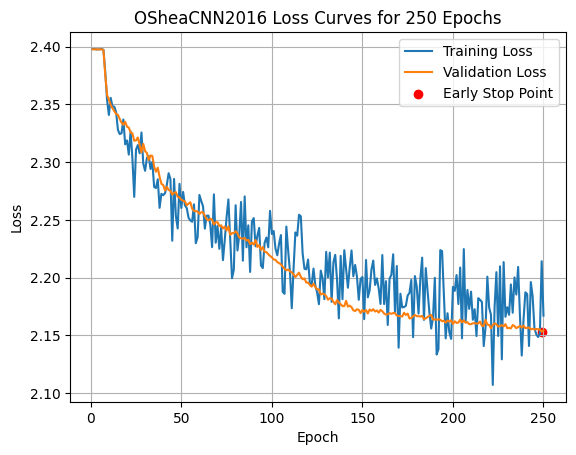

In [42]:
if(not(use_pretrained)): # Generate Loss Curves if Model was Recently Trained
    epoch_idx = np.arange(num_epochs) + 1
    plt.figure()
    plt.title(f'{model.name} Loss Curves for {num_epochs} Epochs')
    plt.plot(epoch_idx,train_loss)
    plt.plot(epoch_idx,val_loss)
    plt.scatter(np.argmin(val_loss)+1,np.min(val_loss),color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(['Training Loss', 'Validation Loss','Early Stop Point'])
    plt.savefig(f'./results/{model.name}_{num_epochs}_Loss.png')
    plt.show()

In [43]:
# Evaluating Based on SNR Threshold 
if(device == 'cuda'): # Free any Device Memory before Start Training
    torch.cuda.empty_cache()
modelDir = './models/OSheaCNN2016_250_best.pt'
model = torch.load(modelDir)
thresh = 18 # SNR Thresholdh in dB
idxThresh  = np.where(Z_test >= thresh)[0]
eval_data = test_data[idxThresh]
eval_data = torch.utils.data.TensorDataset(*eval_data)
eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
test_acc = models.train.eval(device,model,eval_loader)
print(f'Model Test Accuracy for Samples above {thresh} dB: {test_acc:.3f}')

Model Test Accuracy for Samples above 18 dB: 0.598


In [44]:
# Evaluate Test Accuracies
test_accs = [] 
model = torch.load(modelDir)
for SNR in SNRs:
    idxThresh  = np.where(Z_test >= SNR)[0]
    eval_data = test_data[idxThresh]
    eval_data = torch.utils.data.TensorDataset(*eval_data)
    eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
    test_accs.append(models.train.eval(device,model,eval_loader))

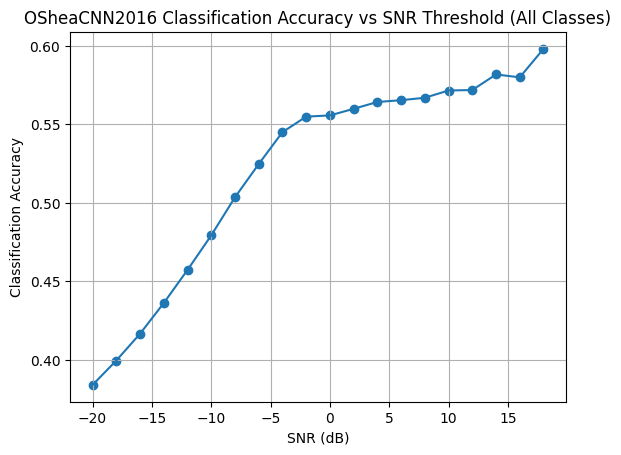

In [45]:
plt.figure()
plt.plot(SNRs,test_accs)
plt.scatter(SNRs,test_accs)
plt.grid()
plt.title(f'{model.name} Classification Accuracy vs SNR Threshold (All Classes)')
plt.xlabel('SNR (dB)')
plt.ylabel('Classification Accuracy')
plt.savefig(f'./results/{os.path.basename(modelDir).split(".pt")[0]}_SNRClassification.png')
plt.show()

## <a name="radio2018">RadioML 2018.01A</a>

Let's load in the RadioML 2018.01A Dataset from [Deepsig](https://deepsig.ai/datasets)! Note that the dataset is around 21 GB, so RAM usage can be upwards of 32 GB.

### Data Visualization 

In [23]:
# Printing Shapes of RadioML 2018.01A
models.datasets.clearDatasetVars(tensors=True)
X,Y,Z,modClasses,SNRs = models.datasets.loadRadioML2018(radioML2018)
print(X.shape)
print(Y.shape)
print(Z.shape)
N = X.shape[0] # Number of Samples

(2555904, 1024, 2)
(2555904, 24)
(2555904, 1)


Below is extraction of some metadata on the class labels and SNRs

In [23]:
# Extracting Variables
labels = np.argmax(Y,axis=-1) # Decode One-Hot Encodings
classes = np.unique(labels)
print("SNRs [dB]: ",SNRs)
print("Classes: ", classes)
print("Classes Names:",modClasses)

SNRs [dB]:  [-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]
Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Classes Names: ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']


The RadioML 2018.01A dataset is balanced, meaning there is equal number of labels across each modulation class and an equal amount of labels across each SNR level.

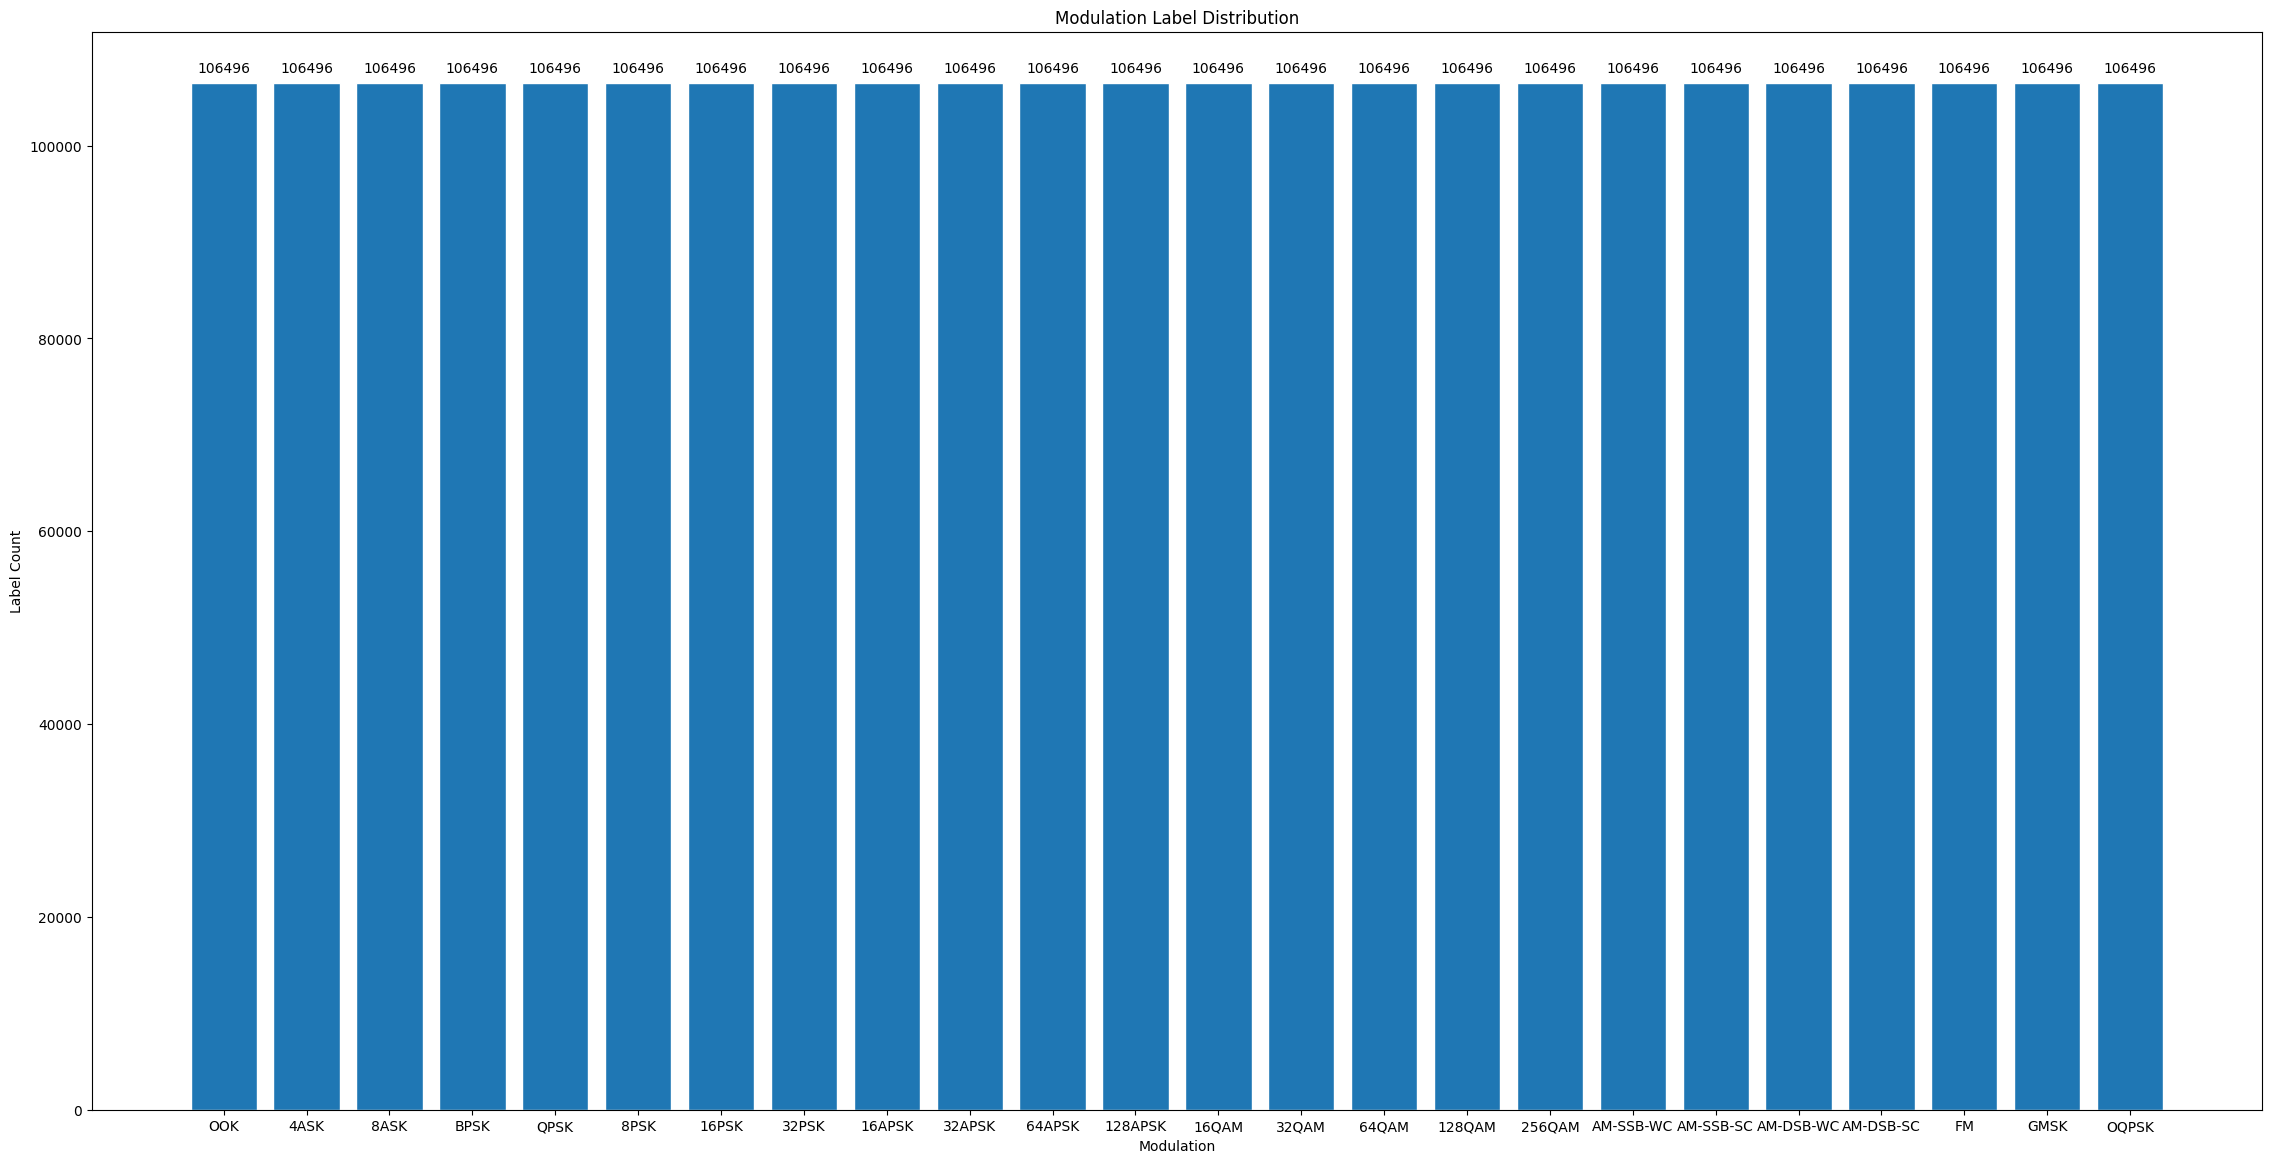

In [24]:
# Label Distribution across Modulation Classes
plt.figure(figsize=(28,14))
counts, bins = np.histogram(labels,bins=len(classes))
trainTitle = plt.title('RadioML 2018.01A Modulation Label Distribution')
trainXLabel = plt.xlabel('Modulation')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(modClasses,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')
plt.savefig('./results/RadioML2018_ModLabelDist.png')
plt.show()

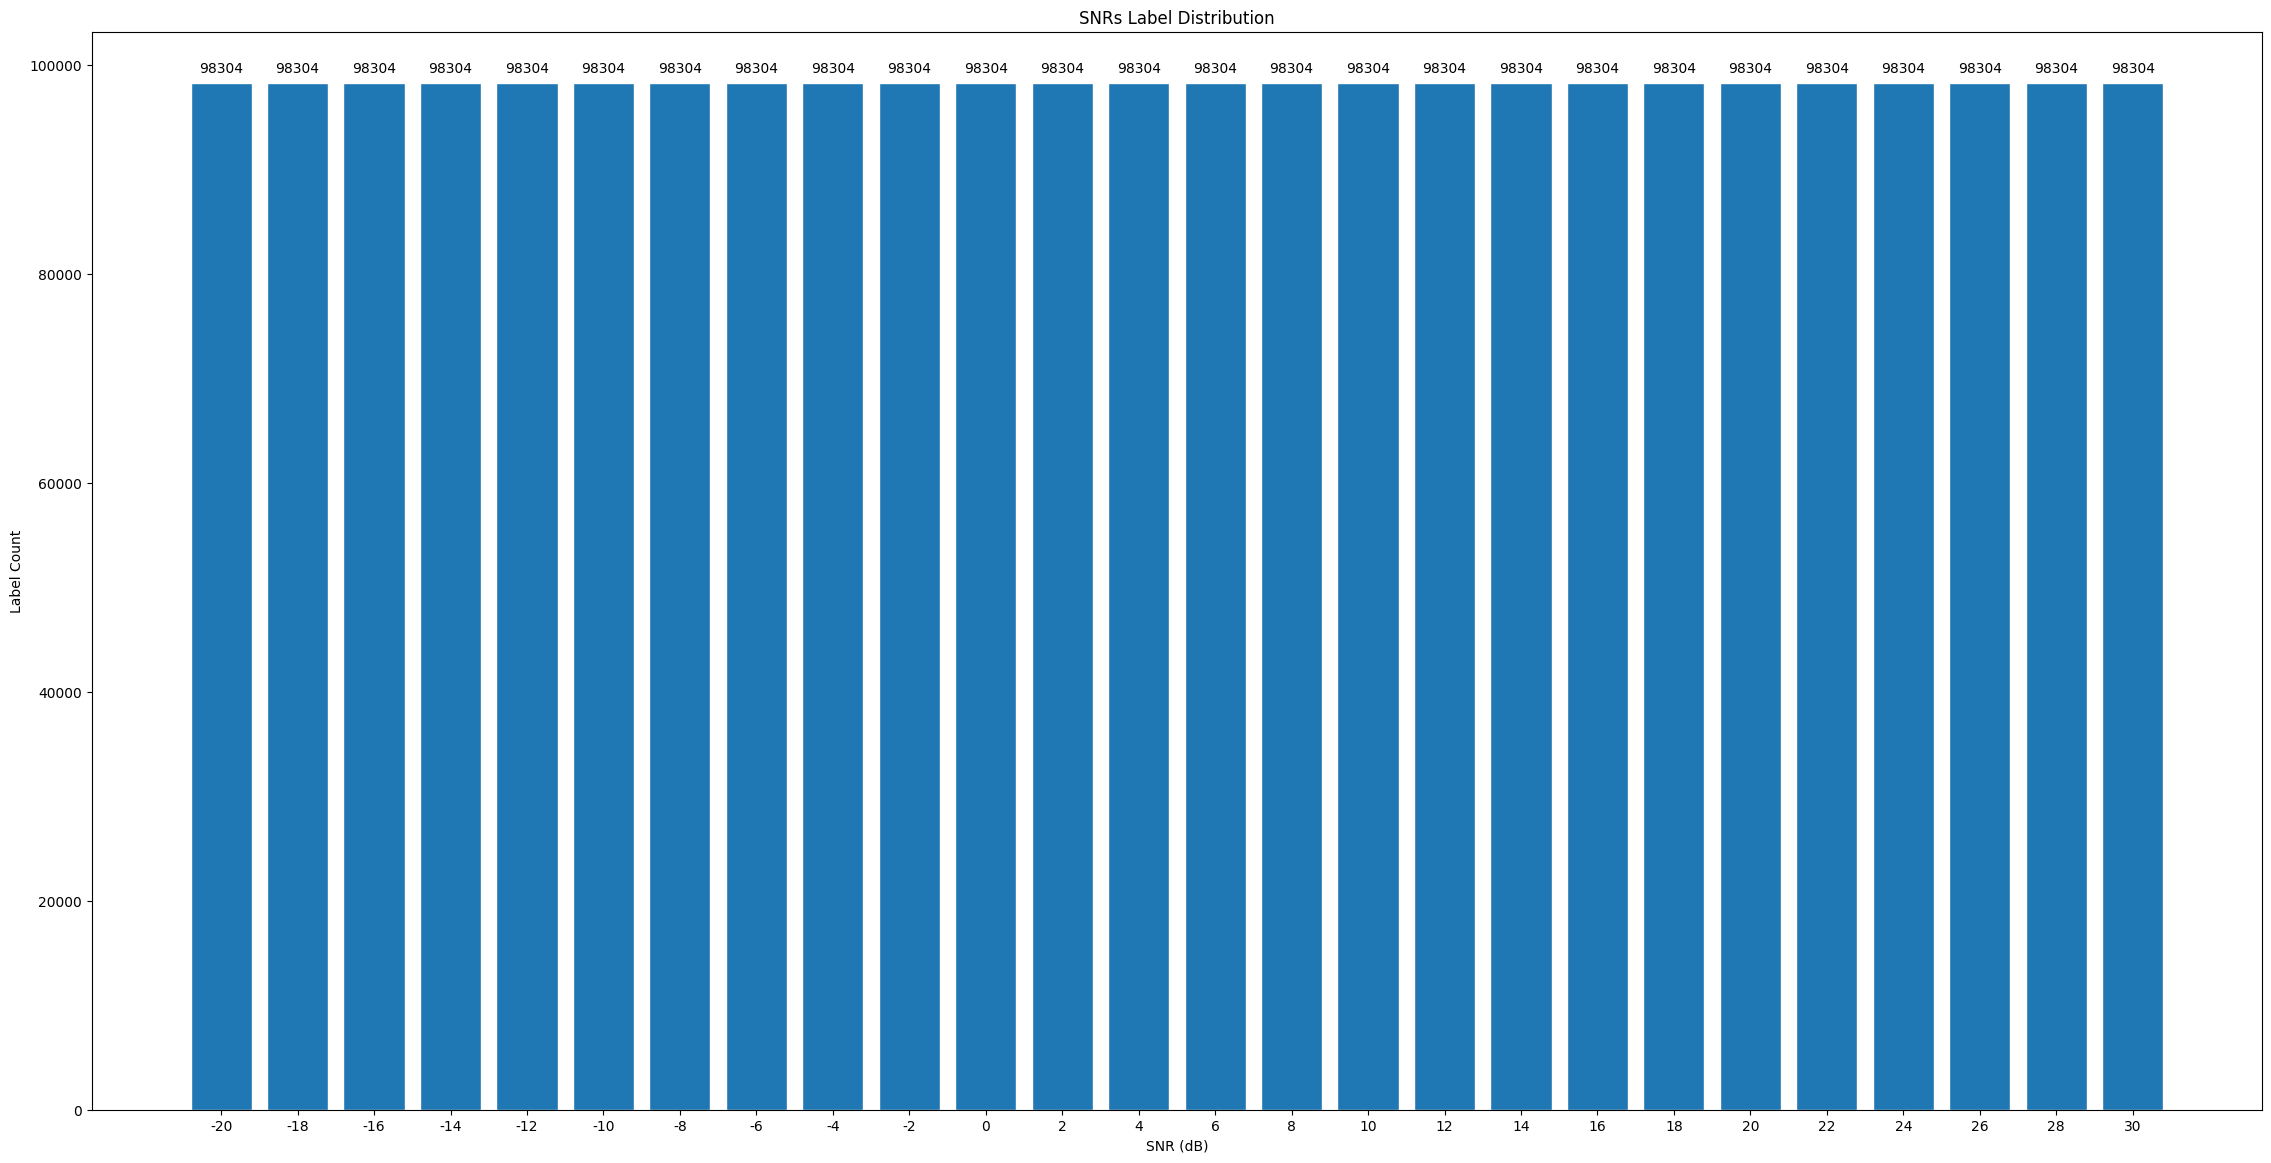

In [25]:
# Label Distribution across SNRs
SNRs_str = [str(SNR) for SNR in SNRs]
plt.figure(figsize=(28,14))
counts, bins = np.histogram(Z,bins=len(SNRs))
trainTitle = plt.title('RadioML 2018.01A SNRs Label Distribution')
trainXLabel = plt.xlabel('SNR (dB)')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(SNRs_str,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')
plt.savefig('./results/RadioML2018_SNRLabelDist.png')
plt.show()

Here a single IQ signal is viewed as a temporal sequence as well as its constellation.

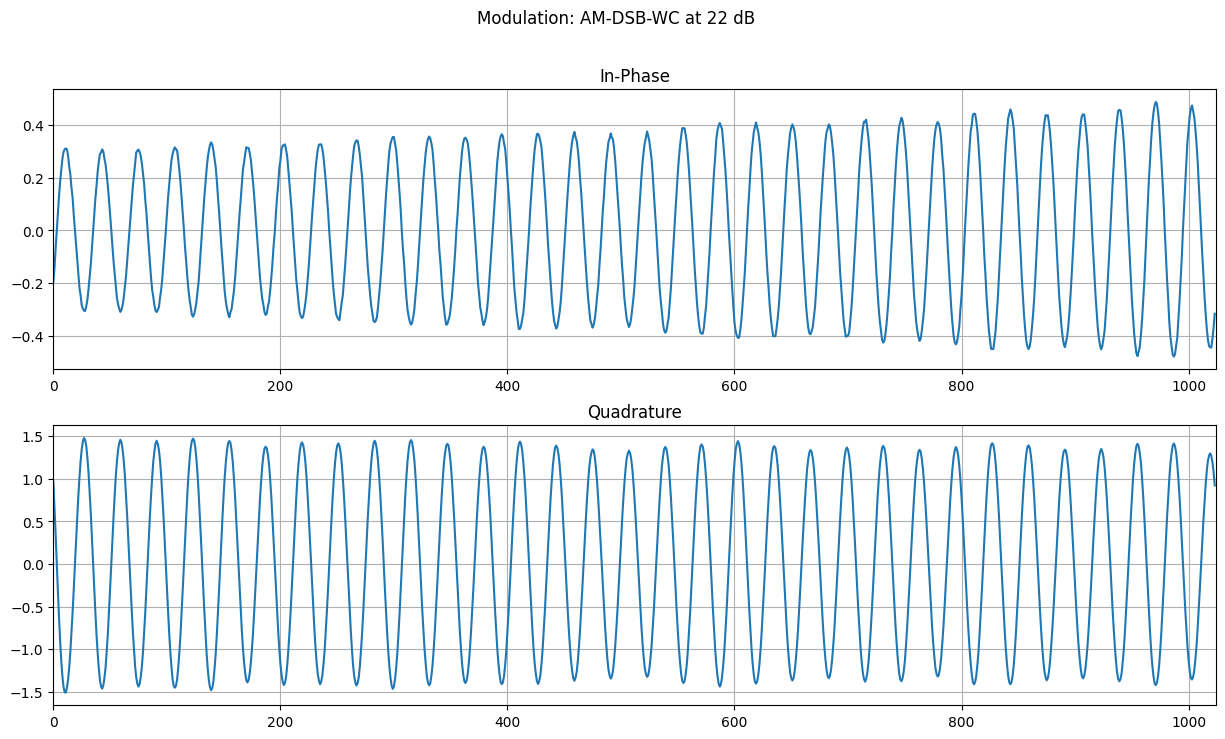

In [26]:
# IQ Temporal Sequence
index = 2110000
plt.figure(figsize=(15,8))
plt.suptitle(f'Modulation: {modClasses[labels[index]]} at {Z[index][0]} dB')
plt.subplot(2,1,1)
plt.title('In-Phase')
plt.grid()
plt.plot(X[index,:,0])
plt.xlim(0,X.shape[1])
plt.subplot(2,1,2)
plt.grid()
plt.title('Quadrature')
plt.plot(X[index,:,1])
plt.xlim(0,X.shape[1])
plt.savefig(f'./results/RadioML2018_{index}_Temporal.png')
plt.show()

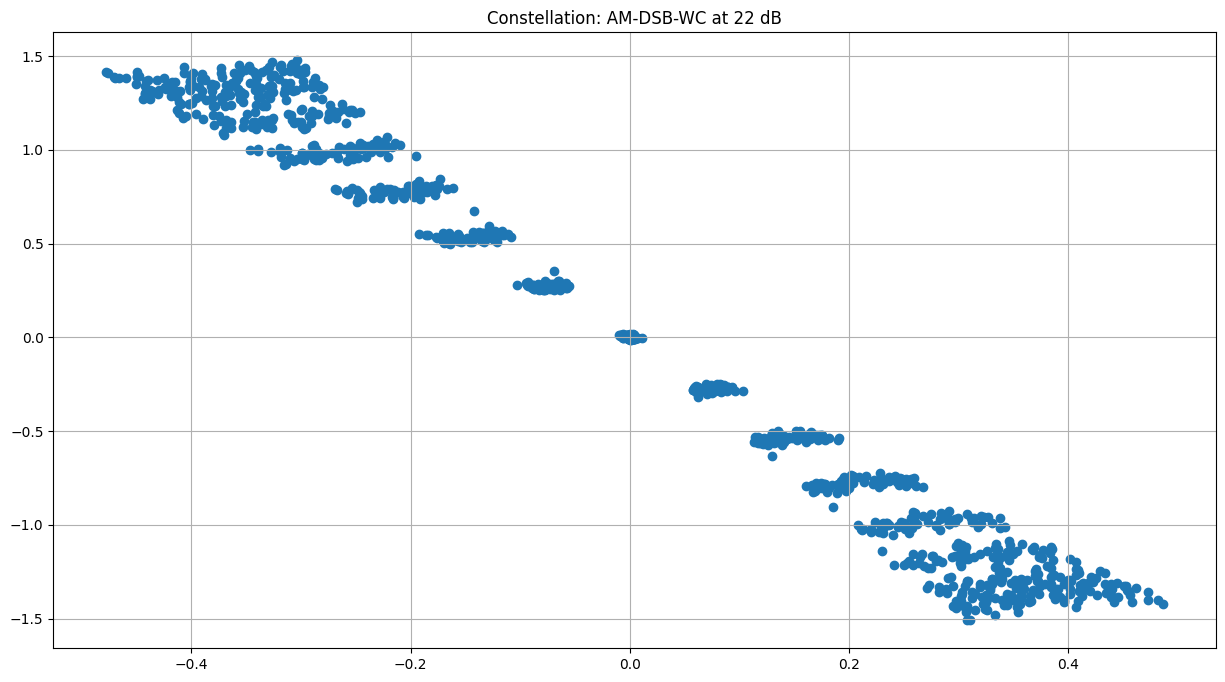

In [27]:
# Constellatino Visualization
plt.figure(figsize=(15,8))
plt.title(f'Constellation: {modClasses[labels[index]]} at {Z[index][0]} dB')
plt.scatter(X[index,:,0],X[index,:,1])
plt.grid()
plt.savefig(f'./results/RadioML2018_{index}_Constellation.png')
plt.show()

### Data Preparation 

The RadioML 2018.01A data is prepared into tensors such that they can be used to train a neural network with the accleration of GPUs. 

In [4]:
# Split Data into Train,Val,Test Subsets (90-5-5)%

# Warning: Memory Intensive (Can Take Upwards of 64 GB)
split = np.array([90,5,5])/100
batch_size = 9000
clearDatasetVars(tensors=True)
X,Y,Z,modClasses,SNRs = models.datasets.loadRadioML2018(radioML2018)
train_data,val_data,test_data,train_loader,val_loader,test_loader,Z_test = models.datasets.prepareDatasetRadioML(X,Y,Z,split,batch_size)

# Freeing Memory of Intermediate Values
clearDatasetVars(tensors=False)

### Model Training and Evaluation

This section covers the training of the neural network to achieve high classification accuracy at high SNRs.

In [83]:
use_pretrained = False

# Define the loss function 
criterion = nn.CrossEntropyLoss()

if(use_pretrained): # Evaluate Pre-Trained Models
    modelDir = './models/OSheaCNN2018_100_best.pt'
    model = torch.load(modelDir)
    test_acc =  models.train.eval(device,model,test_loader)
    print(f'Overall Test Acc: {test_acc:.3f}')
else: # Training Model
    model = OSheaCNN2018().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)
    num_epochs = 3
    if(device == 'cuda'): # Free any Device Memory before Start Training
        torch.cuda.empty_cache()
    train_loss, val_loss, min_val_loss, best_model =  models.train.train_earlystop(device,model,criterion,optimizer,train_loader,val_loader,test_loader,num_epochs)
    torch.save(model,f'./models/OSheaCNN2018_{num_epochs}_last.pt')
    torch.save(best_model,f'./models/OSheaCNN2018_{num_epochs}_best.pt')
    test_last_acc = models.train.eval(device,model,test_loader)
    test_best_acc = models.train.eval(device,best_model,test_loader)
    print(f'\nOverall Test Acc (Last Epoch): {test_last_acc:.3f}')
    print(f'Overall Test Acc (Best Val): {test_best_acc:.3f}')

Overall Test Acc: 0.574


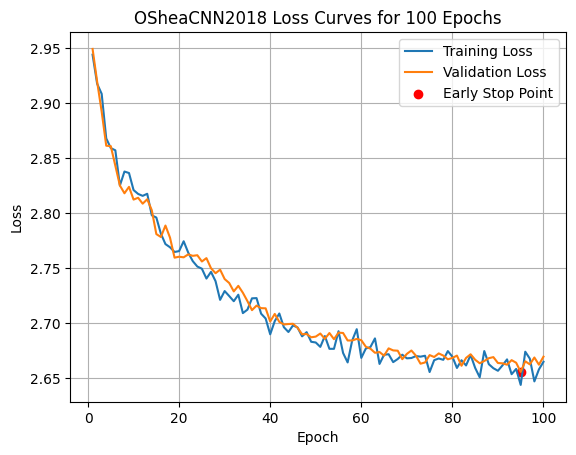

In [112]:
if(not(use_pretrained)): # Generate Loss Curves if Model was Recently Trained
    epoch_idx = np.arange(num_epochs) + 1
    plt.figure()
    plt.title(f'{model.name} Loss Curves for {num_epochs} Epochs')
    plt.plot(epoch_idx,train_loss)
    plt.plot(epoch_idx,val_loss)
    plt.scatter(np.argmin(val_loss)+1,np.min(val_loss),color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(['Training Loss', 'Validation Loss','Early Stop Point'])
    plt.savefig(f'./results/{model.name}_{num_epochs}_Loss.png')
    plt.show()

In [113]:
# Evaluating Based on SNR Threshold 
if(device == 'cuda'): # Free any Device Memory before Start Training
    torch.cuda.empty_cache()
modelDir = './models/OSheaCNN2018_100_best.pt'
model = torch.load(modelDir)
thresh = 20 # SNR Thresholdh in dB
idxThresh  = np.where(Z_test >= thresh)[0]
eval_data = test_data[idxThresh]
eval_data = torch.utils.data.TensorDataset(*eval_data)
eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
test_acc = models.train.eval(device,model,eval_loader)
print(f'Model Test Accuracy for Samples above {thresh} dB: {test_acc:.3f}')

Model Test Accuracy for Samples above 20 dB: 0.90


In [114]:
# Evaluate Test Accuracies
test_accs = [] 
model = torch.load(modelDir)
for SNR in SNRs:
    idxThresh  = np.where(Z_test >= SNR)[0]
    eval_data = test_data[idxThresh]
    eval_data = torch.utils.data.TensorDataset(*eval_data)
    eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
    test_accs.append(models.train.eval(device,model,eval_loader))

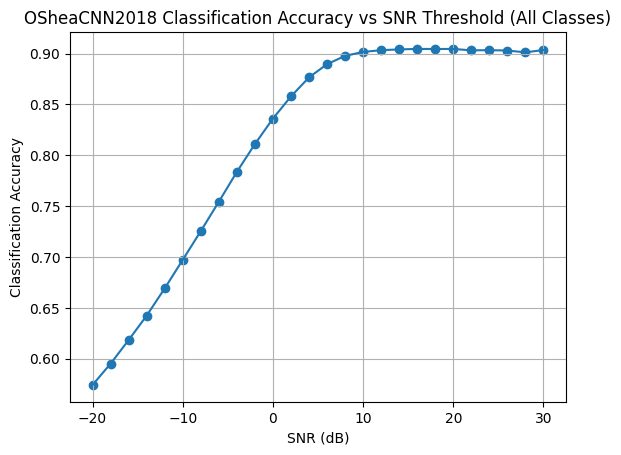

In [119]:
plt.figure()
plt.plot(SNRs,test_accs)
plt.scatter(SNRs,test_accs)
plt.grid()
plt.title(f'{model.name} Classification Accuracy vs SNR Threshold (All Classes)')
plt.xlabel('SNR (dB)')
plt.ylabel('Classification Accuracy')
plt.savefig(f'./results/{os.path.basename(modelDir).split(".pt")[0]}_SNRClassification.png')
plt.show()

## <a name="hisar2019">HisarMod 2019.1</a>

### Data Conversion

We first convert the dataset into a readable format in Python. By default the data CSVs (i.e., <code>train_data.csv</code> & <code>test_data.csv</code>) comes in a format where each cell is in the format **a + bi**, which isn't effciently readable by default by Python. Thus, we employ MATLAB (the same program that created the dataset), to convert the data into a 3D tensor for the IQ Matrices with the custom script <code>convertHisarToPython.m<code>.

In [3]:
# Run the MATLAB Conversion Process if Data Hasn't Been Converted from CSV yet
trainMat = f'{hisar2019Dir}/HisarMod2019.1/Train/train_data.mat'
testMat = f'{hisar2019Dir}/HisarMod2019.1/Test/test_data.mat'
if(not(os.path.exists(trainMat)) or not(os.path.exists(testMat))):
   eng = matlab.engine.start_matlab()
   eng.convertHisarToPython()

### Data Visualization

In [4]:
# Printing Shapes of Hisar2019 (Warning: Dataset loading can take upwards of 20 GB and around a minute to run)
clearDatasetVars(tensors=True)
X_train_val,X_test,Y_train_val,Y_test,Z_train_val,Z_test,SNRs,modClasses =  models.datasets.loadHisar(hisar2019Dir)
print(X_train_val.shape)
print(X_test.shape)
print(Y_train_val.shape)
print(Y_test.shape)
print(Z_train_val.shape)
print(Z_test.shape)

(520000, 1024, 2)
(260000, 1024, 2)
(520000, 26)
(260000, 26)
(520000,)
(260000,)


In [6]:
# Extracting Variables of Train Val Set
labels = np.argmax(Y_train_val,axis=-1) # Decode One-Hot Encodings
classes = np.unique(labels)
print("SNRs [dB]: ",SNRs)
print("Classes: ", classes)
print("Classes Names:",modClasses)

SNRs [dB]:  [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.
   8.  10.  12.  14.  16.  18.]
Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Classes Names: ['BPQK', 'QPSK', '8PSK', '16PSK', '32PSK', '64PSK', '4QAM', '8QAM', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', '2FSK', '4FSK', '8FSK', '16FSK', '4PAM', '8PAM', '16PAM', 'AM-DB', 'AM-DB-SC', 'AM-USB', 'AM-LSB', 'FM', 'PM']


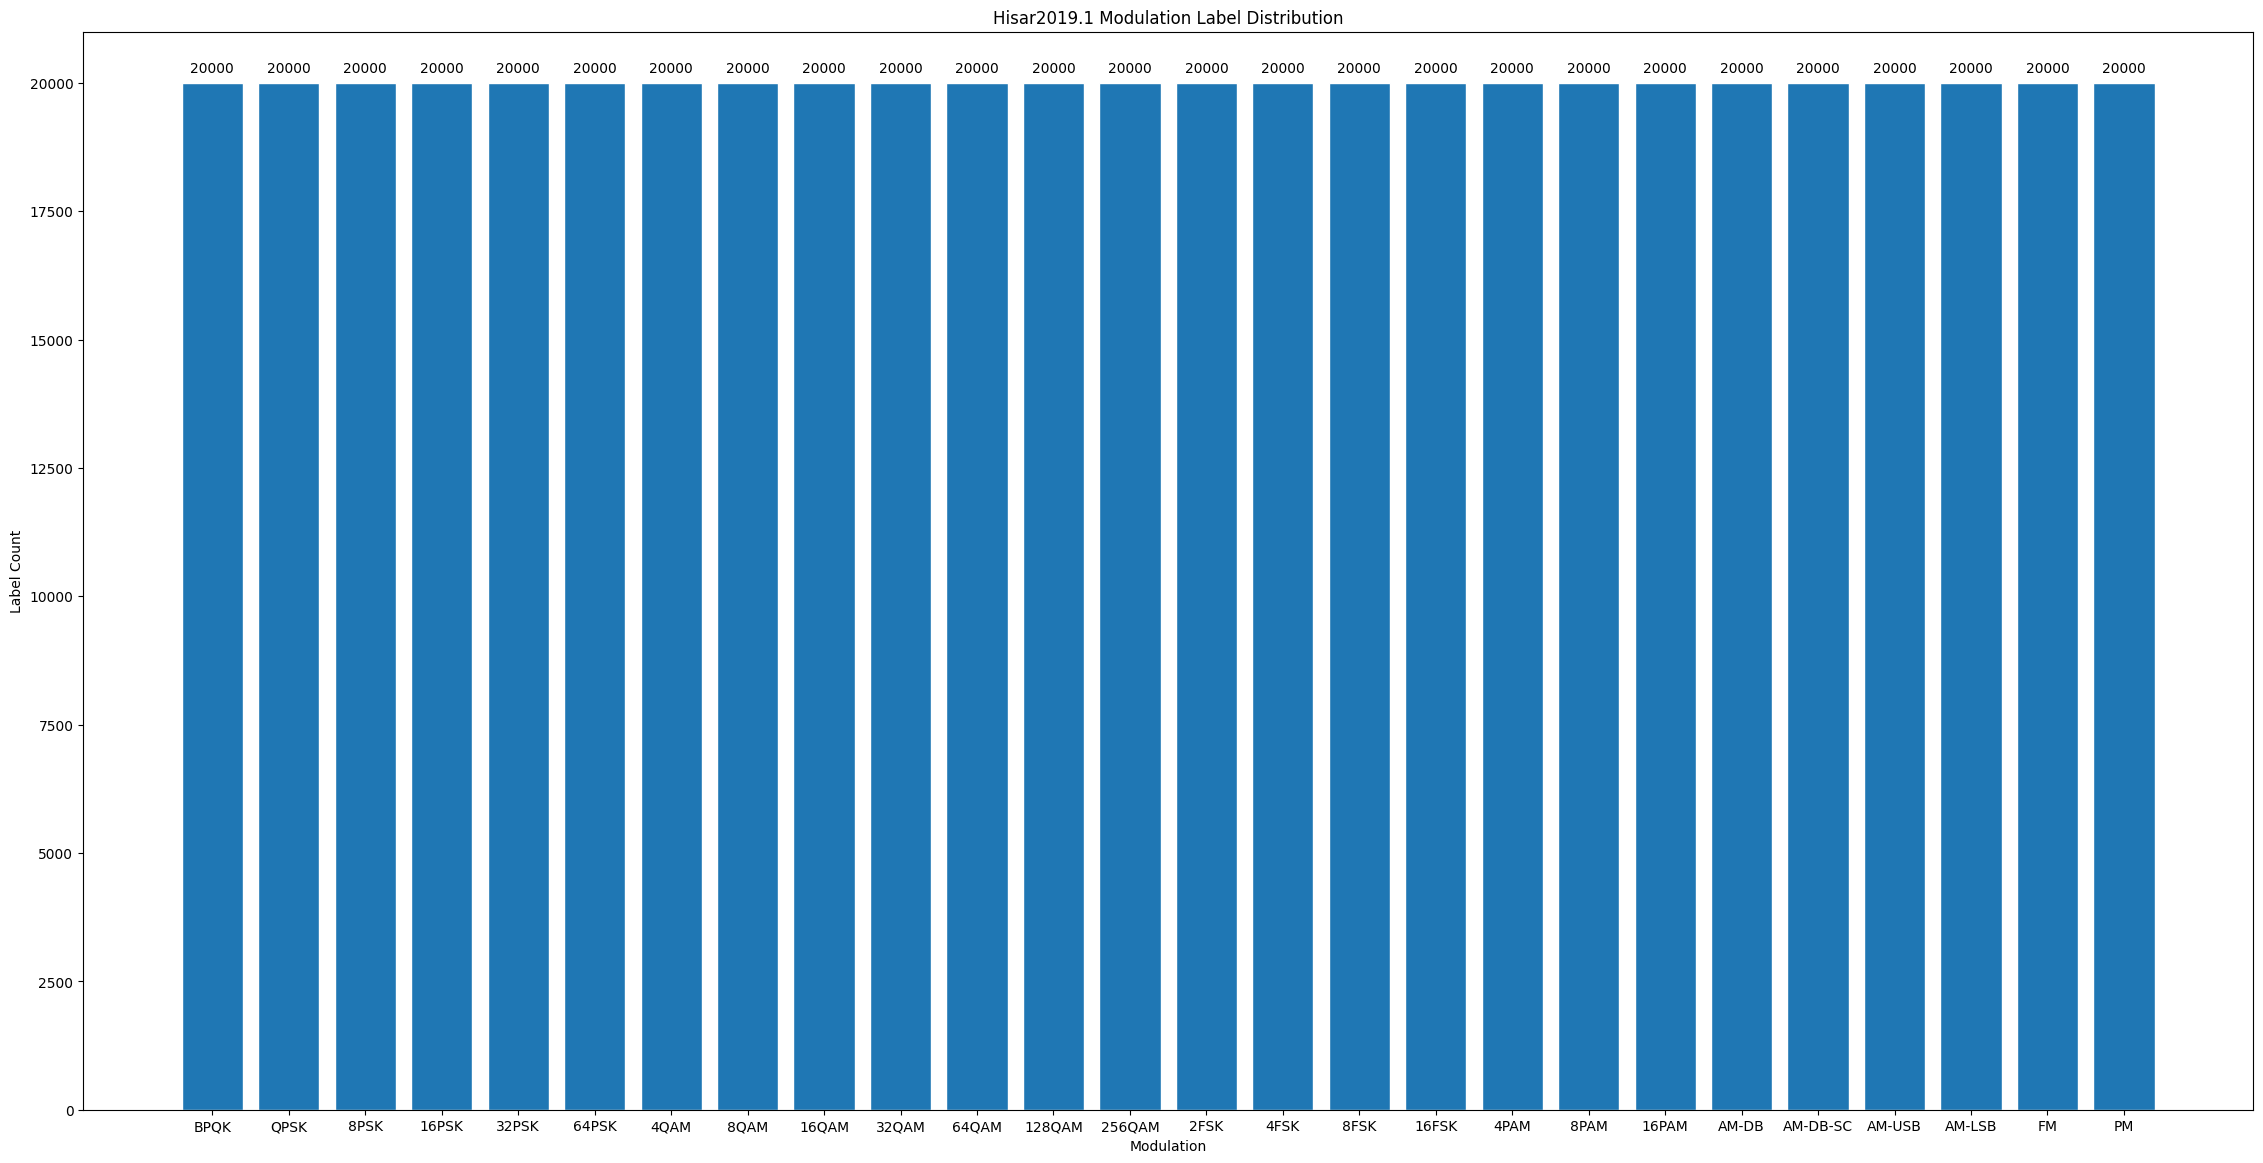

In [18]:
# Label Distribution across Modulation Classes for Train Val Subset
plt.figure(figsize=(28,14))
counts, bins = np.histogram(labels,bins=len(classes))
trainTitle = plt.title('Hisar2019.1 Modulation Label Distribution')
trainXLabel = plt.xlabel('Modulation')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(modClasses,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')
plt.savefig('./results/Hisar2019_ModLabelDist.png')
plt.show()

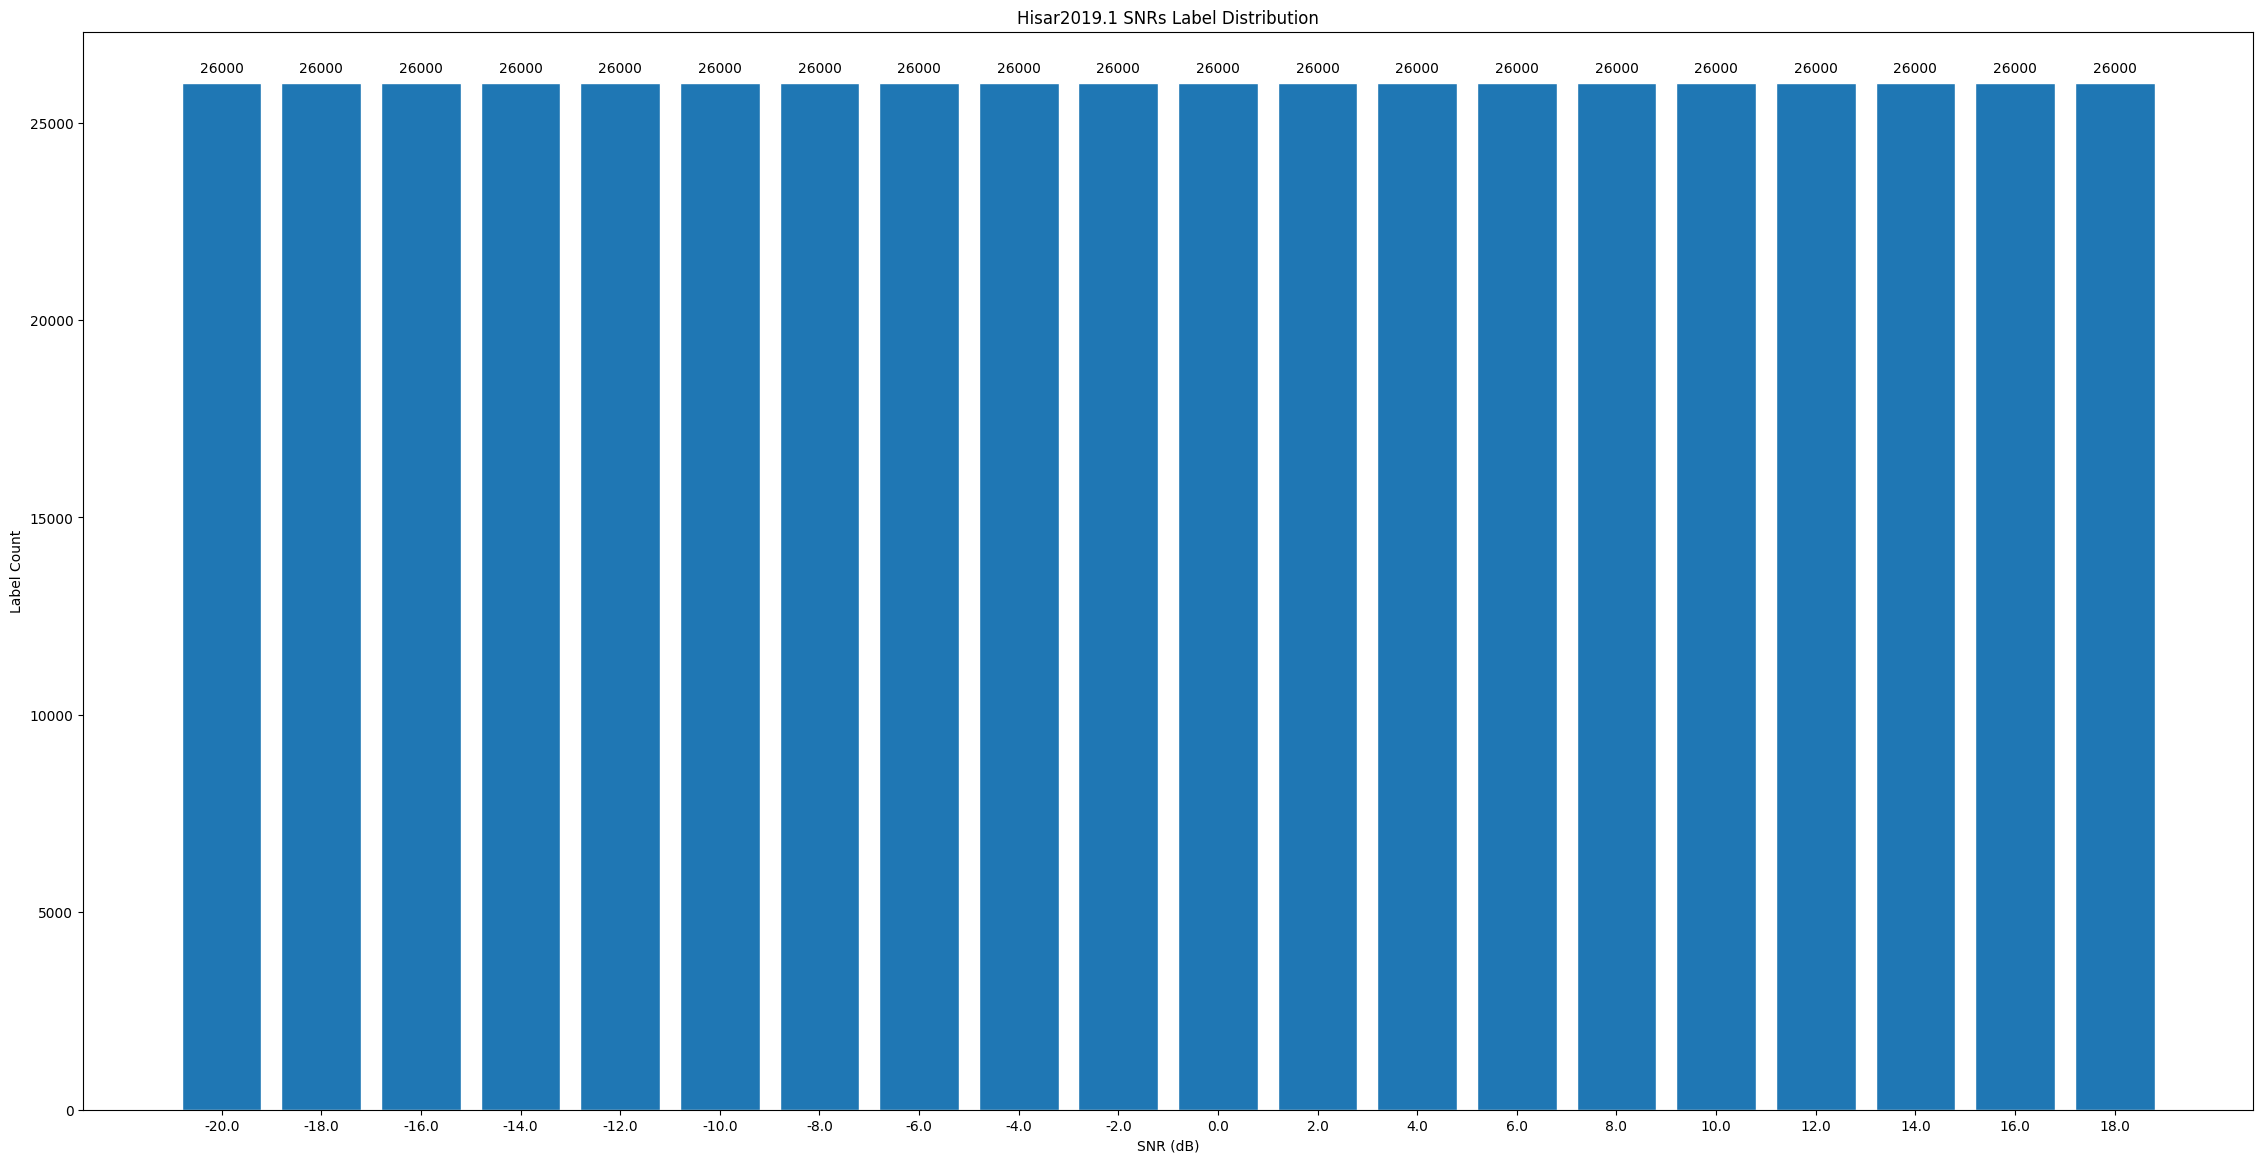

In [17]:
# Label Distribution across SNRs for Train Val Subset 
SNRs_str = [str(SNR) for SNR in SNRs]
plt.figure(figsize=(28,14))
counts, bins = np.histogram(Z_train_val,bins=len(SNRs))
trainTitle = plt.title('Hisar2019.1 SNRs Label Distribution')
trainXLabel = plt.xlabel('SNR (dB)')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(SNRs_str,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')
plt.savefig('./results/Hisar2019_SNRLabelDist.png')
plt.show()

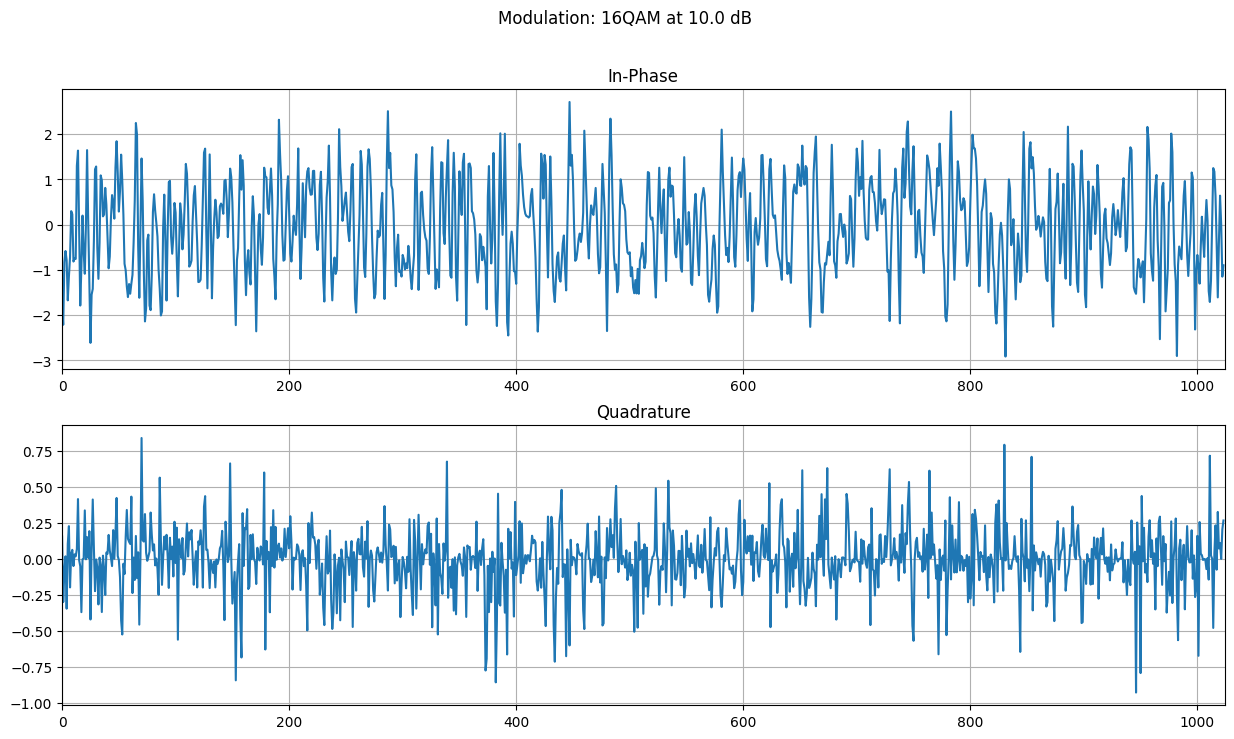

In [19]:
# IQ Temporal Sequence in Train Val Subset
index = 400000
plt.figure(figsize=(15,8))
plt.suptitle(f'Modulation: {modClasses[labels[index]]} at {Z_train_val[index]} dB')
plt.subplot(2,1,1)
plt.title('In-Phase')
plt.grid()
plt.plot(X_train_val[index,:,0])
plt.xlim(0,X_train_val.shape[1])
plt.subplot(2,1,2)
plt.grid()
plt.title('Quadrature')
plt.plot(X_train_val[index,:,1])
plt.xlim(0,X_train_val.shape[1])
plt.savefig(f'./results/Hisar2019_{index}_Temporal.png')
plt.show()

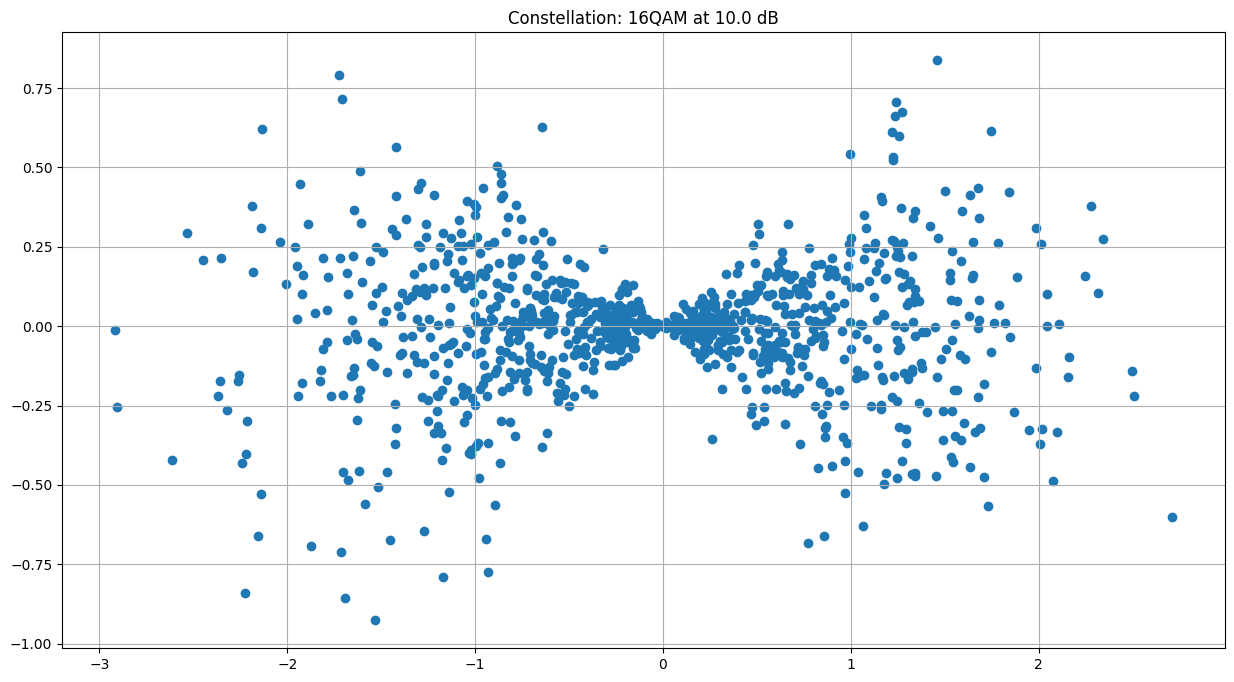

In [20]:
# Constellation Visualization in Train Val Subset
plt.figure(figsize=(15,8))
plt.title(f'Constellation: {modClasses[labels[index]]} at {Z_train_val[index]} dB')
plt.scatter(X_train_val[index,:,0],X_train_val[index,:,1])
plt.grid()
plt.savefig(f'./results/Hisar2019_{index}_Constellation.png')
plt.show()

### Data Preparation

In [5]:
# Split Data into Train,Val into (80-20)%, Test Set is Already Seperate

# Warning: Memory Intensive (Can Take Upwards of 32 GB) & Can Take a Few Mins to Load
split = np.array([80,20])/100
batch_size = 9000
clearDatasetVars(tensors=True)
X_train_val,X_test,Y_train_val,Y_test,Z_train_val,Z_test,SNRs,modClasses =  models.datasets.loadHisar(hisar2019Dir)
train_data,val_data,test_data,train_loader,val_loader,test_loader = models.datasets.prepareDatasetHisar(X_train_val,X_test,Y_train_val,Y_test,split,batch_size)

# Freeing Memory of Intermediate Values
clearDatasetVars(tensors=False)

### Model Training and Evaluation

In [23]:
use_pretrained = False

# Define the loss function 
criterion = nn.CrossEntropyLoss()

if(use_pretrained): # Evaluate Pre-Trained Models
    modelDir = './models/HisarCNN2019_100_best.pt'
    model = torch.load(modelDir)
    test_acc =  models.train.eval(device,model,test_loader)
    print(f'Overall Test Acc: {test_acc:.3f}')
else: # Training Model
    model = HisarCNN2019().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)
    num_epochs = 100
    if(device == 'cuda'): # Free any Device Memory before Start Training
        torch.cuda.empty_cache()
    train_loss, val_loss, min_val_loss, best_model =  models.train.train_earlystop(device,model,criterion,optimizer,train_loader,val_loader,test_loader,num_epochs)
    torch.save(model,f'./models/HisarCNN2019_{num_epochs}_last.pt')
    torch.save(best_model,f'./models/HisarCNN2019_{num_epochs}_best.pt')
    test_last_acc = models.train.eval(device,model,test_loader)
    test_best_acc = models.train.eval(device,best_model,test_loader)
    print(f'\nOverall Test Acc (Last Epoch): {test_last_acc:.3f}')
    print(f'Overall Test Acc (Best Val): {test_best_acc:.3f}')


Starting to Train HisarCNN2019 for 100 Epochs!


  1%|▊                                                                                 | 1/100 [00:08<13:37,  8.26s/it]

Epoch [1/100]: Train Loss: 3.101 Val Loss: 3.102 Train Acc: 0.135, Val Acc: 0.206


  2%|█▋                                                                                | 2/100 [00:16<13:09,  8.06s/it]

Epoch [2/100]: Train Loss: 3.087 Val Loss: 3.071 Train Acc: 0.224, Val Acc: 0.246


  3%|██▍                                                                               | 3/100 [00:24<12:54,  7.98s/it]

Epoch [3/100]: Train Loss: 3.027 Val Loss: 3.045 Train Acc: 0.267, Val Acc: 0.267


  4%|███▎                                                                              | 4/100 [00:31<12:38,  7.90s/it]

Epoch [4/100]: Train Loss: 3.012 Val Loss: 3.023 Train Acc: 0.289, Val Acc: 0.289


  5%|████                                                                              | 5/100 [00:39<12:32,  7.92s/it]

Epoch [5/100]: Train Loss: 2.985 Val Loss: 3.031 Train Acc: 0.297, Val Acc: 0.282


  6%|████▉                                                                             | 6/100 [00:47<12:22,  7.89s/it]

Epoch [6/100]: Train Loss: 3.000 Val Loss: 3.022 Train Acc: 0.297, Val Acc: 0.292


  7%|█████▋                                                                            | 7/100 [00:55<12:11,  7.87s/it]

Epoch [7/100]: Train Loss: 2.993 Val Loss: 3.013 Train Acc: 0.307, Val Acc: 0.307


  8%|██████▌                                                                           | 8/100 [01:03<12:06,  7.89s/it]

Epoch [8/100]: Train Loss: 2.985 Val Loss: 3.009 Train Acc: 0.314, Val Acc: 0.309


  9%|███████▍                                                                          | 9/100 [01:11<11:57,  7.89s/it]

Epoch [9/100]: Train Loss: 2.994 Val Loss: 2.998 Train Acc: 0.317, Val Acc: 0.323


 10%|████████                                                                         | 10/100 [01:19<11:47,  7.86s/it]

Epoch [10/100]: Train Loss: 2.978 Val Loss: 3.008 Train Acc: 0.329, Val Acc: 0.314


 11%|████████▉                                                                        | 11/100 [01:27<11:42,  7.89s/it]

Epoch [11/100]: Train Loss: 2.970 Val Loss: 2.988 Train Acc: 0.331, Val Acc: 0.331


 12%|█████████▋                                                                       | 12/100 [01:35<11:48,  8.05s/it]

Epoch [12/100]: Train Loss: 2.979 Val Loss: 2.990 Train Acc: 0.339, Val Acc: 0.333


 13%|██████████▌                                                                      | 13/100 [01:43<11:52,  8.19s/it]

Epoch [13/100]: Train Loss: 2.968 Val Loss: 2.972 Train Acc: 0.341, Val Acc: 0.344


 14%|███████████▎                                                                     | 14/100 [01:52<11:45,  8.20s/it]

Epoch [14/100]: Train Loss: 2.967 Val Loss: 2.973 Train Acc: 0.350, Val Acc: 0.347


 15%|████████████▏                                                                    | 15/100 [02:00<11:42,  8.26s/it]

Epoch [15/100]: Train Loss: 2.976 Val Loss: 2.977 Train Acc: 0.351, Val Acc: 0.343


 16%|████████████▉                                                                    | 16/100 [02:08<11:35,  8.28s/it]

Epoch [16/100]: Train Loss: 2.952 Val Loss: 2.965 Train Acc: 0.354, Val Acc: 0.352


 17%|█████████████▊                                                                   | 17/100 [02:16<11:18,  8.18s/it]

Epoch [17/100]: Train Loss: 2.952 Val Loss: 2.978 Train Acc: 0.359, Val Acc: 0.346


 18%|██████████████▌                                                                  | 18/100 [02:24<11:03,  8.09s/it]

Epoch [18/100]: Train Loss: 2.949 Val Loss: 2.960 Train Acc: 0.364, Val Acc: 0.356


 19%|███████████████▍                                                                 | 19/100 [02:32<10:48,  8.00s/it]

Epoch [19/100]: Train Loss: 2.955 Val Loss: 2.972 Train Acc: 0.367, Val Acc: 0.350


 20%|████████████████▏                                                                | 20/100 [02:40<10:40,  8.00s/it]

Epoch [20/100]: Train Loss: 2.962 Val Loss: 2.950 Train Acc: 0.370, Val Acc: 0.366


 21%|█████████████████                                                                | 21/100 [02:48<10:31,  7.99s/it]

Epoch [21/100]: Train Loss: 2.928 Val Loss: 2.946 Train Acc: 0.373, Val Acc: 0.372


 22%|█████████████████▊                                                               | 22/100 [02:56<10:19,  7.94s/it]

Epoch [22/100]: Train Loss: 2.940 Val Loss: 2.948 Train Acc: 0.374, Val Acc: 0.369


 23%|██████████████████▋                                                              | 23/100 [03:04<10:12,  7.95s/it]

Epoch [23/100]: Train Loss: 2.931 Val Loss: 2.940 Train Acc: 0.385, Val Acc: 0.378


 24%|███████████████████▍                                                             | 24/100 [03:12<10:03,  7.94s/it]

Epoch [24/100]: Train Loss: 2.913 Val Loss: 2.936 Train Acc: 0.390, Val Acc: 0.384


 25%|████████████████████▎                                                            | 25/100 [03:20<09:53,  7.91s/it]

Epoch [25/100]: Train Loss: 2.936 Val Loss: 2.940 Train Acc: 0.396, Val Acc: 0.378


 26%|█████████████████████                                                            | 26/100 [03:28<09:46,  7.93s/it]

Epoch [26/100]: Train Loss: 2.915 Val Loss: 2.937 Train Acc: 0.402, Val Acc: 0.379


 27%|█████████████████████▊                                                           | 27/100 [03:35<09:38,  7.92s/it]

Epoch [27/100]: Train Loss: 2.936 Val Loss: 2.939 Train Acc: 0.403, Val Acc: 0.375


 28%|██████████████████████▋                                                          | 28/100 [03:43<09:28,  7.89s/it]

Epoch [28/100]: Train Loss: 2.906 Val Loss: 2.931 Train Acc: 0.405, Val Acc: 0.390


 29%|███████████████████████▍                                                         | 29/100 [03:51<09:21,  7.91s/it]

Epoch [29/100]: Train Loss: 2.917 Val Loss: 2.916 Train Acc: 0.413, Val Acc: 0.402


 30%|████████████████████████▎                                                        | 30/100 [03:59<09:12,  7.90s/it]

Epoch [30/100]: Train Loss: 2.908 Val Loss: 2.922 Train Acc: 0.415, Val Acc: 0.391


 31%|█████████████████████████                                                        | 31/100 [04:07<09:09,  7.96s/it]

Epoch [31/100]: Train Loss: 2.910 Val Loss: 2.902 Train Acc: 0.424, Val Acc: 0.414


 32%|█████████████████████████▉                                                       | 32/100 [04:16<09:15,  8.16s/it]

Epoch [32/100]: Train Loss: 2.899 Val Loss: 2.902 Train Acc: 0.434, Val Acc: 0.415


 33%|██████████████████████████▋                                                      | 33/100 [04:24<09:10,  8.22s/it]

Epoch [33/100]: Train Loss: 2.883 Val Loss: 2.892 Train Acc: 0.434, Val Acc: 0.423


 34%|███████████████████████████▌                                                     | 34/100 [04:32<08:57,  8.15s/it]

Epoch [34/100]: Train Loss: 2.886 Val Loss: 2.904 Train Acc: 0.437, Val Acc: 0.416


 35%|████████████████████████████▎                                                    | 35/100 [04:40<08:46,  8.10s/it]

Epoch [35/100]: Train Loss: 2.877 Val Loss: 2.892 Train Acc: 0.441, Val Acc: 0.430


 36%|█████████████████████████████▏                                                   | 36/100 [04:48<08:36,  8.07s/it]

Epoch [36/100]: Train Loss: 2.890 Val Loss: 2.899 Train Acc: 0.442, Val Acc: 0.416


 37%|█████████████████████████████▉                                                   | 37/100 [04:56<08:31,  8.11s/it]

Epoch [37/100]: Train Loss: 2.867 Val Loss: 2.896 Train Acc: 0.445, Val Acc: 0.419


 38%|██████████████████████████████▊                                                  | 38/100 [05:05<08:32,  8.26s/it]

Epoch [38/100]: Train Loss: 2.874 Val Loss: 2.881 Train Acc: 0.454, Val Acc: 0.434


 39%|███████████████████████████████▌                                                 | 39/100 [05:13<08:22,  8.24s/it]

Epoch [39/100]: Train Loss: 2.861 Val Loss: 2.873 Train Acc: 0.455, Val Acc: 0.440


 40%|████████████████████████████████▍                                                | 40/100 [05:21<08:08,  8.13s/it]

Epoch [40/100]: Train Loss: 2.854 Val Loss: 2.887 Train Acc: 0.462, Val Acc: 0.430


 41%|█████████████████████████████████▏                                               | 41/100 [05:29<07:56,  8.07s/it]

Epoch [41/100]: Train Loss: 2.864 Val Loss: 2.870 Train Acc: 0.463, Val Acc: 0.445


 42%|██████████████████████████████████                                               | 42/100 [05:37<07:44,  8.01s/it]

Epoch [42/100]: Train Loss: 2.859 Val Loss: 2.875 Train Acc: 0.469, Val Acc: 0.441


 43%|██████████████████████████████████▊                                              | 43/100 [05:45<07:32,  7.94s/it]

Epoch [43/100]: Train Loss: 2.843 Val Loss: 2.885 Train Acc: 0.471, Val Acc: 0.434


 44%|███████████████████████████████████▋                                             | 44/100 [05:53<07:23,  7.93s/it]

Epoch [44/100]: Train Loss: 2.848 Val Loss: 2.865 Train Acc: 0.471, Val Acc: 0.451


 45%|████████████████████████████████████▍                                            | 45/100 [06:00<07:15,  7.93s/it]

Epoch [45/100]: Train Loss: 2.840 Val Loss: 2.863 Train Acc: 0.476, Val Acc: 0.450


 46%|█████████████████████████████████████▎                                           | 46/100 [06:08<07:06,  7.89s/it]

Epoch [46/100]: Train Loss: 2.856 Val Loss: 2.861 Train Acc: 0.483, Val Acc: 0.455


 47%|██████████████████████████████████████                                           | 47/100 [06:16<06:58,  7.90s/it]

Epoch [47/100]: Train Loss: 2.833 Val Loss: 2.859 Train Acc: 0.480, Val Acc: 0.457


 48%|██████████████████████████████████████▉                                          | 48/100 [06:24<06:50,  7.89s/it]

Epoch [48/100]: Train Loss: 2.832 Val Loss: 2.863 Train Acc: 0.485, Val Acc: 0.453


 49%|███████████████████████████████████████▋                                         | 49/100 [06:32<06:41,  7.86s/it]

Epoch [49/100]: Train Loss: 2.842 Val Loss: 2.857 Train Acc: 0.487, Val Acc: 0.459


 50%|████████████████████████████████████████▌                                        | 50/100 [06:40<06:33,  7.87s/it]

Epoch [50/100]: Train Loss: 2.820 Val Loss: 2.854 Train Acc: 0.489, Val Acc: 0.464


 51%|█████████████████████████████████████████▎                                       | 51/100 [06:48<06:26,  7.89s/it]

Epoch [51/100]: Train Loss: 2.829 Val Loss: 2.852 Train Acc: 0.497, Val Acc: 0.463


 52%|██████████████████████████████████████████                                       | 52/100 [06:55<06:17,  7.86s/it]

Epoch [52/100]: Train Loss: 2.858 Val Loss: 2.856 Train Acc: 0.494, Val Acc: 0.461


 53%|██████████████████████████████████████████▉                                      | 53/100 [07:03<06:10,  7.87s/it]

Epoch [53/100]: Train Loss: 2.829 Val Loss: 2.845 Train Acc: 0.500, Val Acc: 0.468


 54%|███████████████████████████████████████████▋                                     | 54/100 [07:11<06:02,  7.88s/it]

Epoch [54/100]: Train Loss: 2.806 Val Loss: 2.846 Train Acc: 0.501, Val Acc: 0.468


 55%|████████████████████████████████████████████▌                                    | 55/100 [07:19<05:53,  7.85s/it]

Epoch [55/100]: Train Loss: 2.805 Val Loss: 2.843 Train Acc: 0.506, Val Acc: 0.473


 56%|█████████████████████████████████████████████▎                                   | 56/100 [07:27<05:46,  7.87s/it]

Epoch [56/100]: Train Loss: 2.826 Val Loss: 2.844 Train Acc: 0.510, Val Acc: 0.472


 57%|██████████████████████████████████████████████▏                                  | 57/100 [07:35<05:38,  7.87s/it]

Epoch [57/100]: Train Loss: 2.829 Val Loss: 2.839 Train Acc: 0.511, Val Acc: 0.476


 58%|██████████████████████████████████████████████▉                                  | 58/100 [07:43<05:29,  7.84s/it]

Epoch [58/100]: Train Loss: 2.803 Val Loss: 2.839 Train Acc: 0.518, Val Acc: 0.478


 59%|███████████████████████████████████████████████▊                                 | 59/100 [07:51<05:25,  7.94s/it]

Epoch [59/100]: Train Loss: 2.801 Val Loss: 2.837 Train Acc: 0.516, Val Acc: 0.477


 60%|████████████████████████████████████████████████▌                                | 60/100 [07:59<05:17,  7.94s/it]

Epoch [60/100]: Train Loss: 2.810 Val Loss: 2.831 Train Acc: 0.516, Val Acc: 0.483


 61%|█████████████████████████████████████████████████▍                               | 61/100 [08:06<05:08,  7.90s/it]

Epoch [61/100]: Train Loss: 2.803 Val Loss: 2.838 Train Acc: 0.520, Val Acc: 0.477


 62%|██████████████████████████████████████████████████▏                              | 62/100 [08:14<05:00,  7.91s/it]

Epoch [62/100]: Train Loss: 2.801 Val Loss: 2.834 Train Acc: 0.525, Val Acc: 0.480


 63%|███████████████████████████████████████████████████                              | 63/100 [08:23<04:55,  8.00s/it]

Epoch [63/100]: Train Loss: 2.803 Val Loss: 2.837 Train Acc: 0.528, Val Acc: 0.481


 64%|███████████████████████████████████████████████████▊                             | 64/100 [08:30<04:45,  7.93s/it]

Epoch [64/100]: Train Loss: 2.789 Val Loss: 2.840 Train Acc: 0.529, Val Acc: 0.475


 65%|████████████████████████████████████████████████████▋                            | 65/100 [08:39<04:40,  8.02s/it]

Epoch [65/100]: Train Loss: 2.806 Val Loss: 2.829 Train Acc: 0.525, Val Acc: 0.487


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [08:47<04:31,  7.98s/it]

Epoch [66/100]: Train Loss: 2.781 Val Loss: 2.836 Train Acc: 0.536, Val Acc: 0.484


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [08:54<04:21,  7.93s/it]

Epoch [67/100]: Train Loss: 2.805 Val Loss: 2.829 Train Acc: 0.535, Val Acc: 0.486


 68%|███████████████████████████████████████████████████████                          | 68/100 [09:02<04:13,  7.93s/it]

Epoch [68/100]: Train Loss: 2.786 Val Loss: 2.828 Train Acc: 0.536, Val Acc: 0.489


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [09:10<04:04,  7.89s/it]

Epoch [69/100]: Train Loss: 2.784 Val Loss: 2.824 Train Acc: 0.538, Val Acc: 0.490


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [09:18<03:55,  7.86s/it]

Epoch [70/100]: Train Loss: 2.761 Val Loss: 2.828 Train Acc: 0.543, Val Acc: 0.492


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [09:26<03:49,  7.90s/it]

Epoch [71/100]: Train Loss: 2.798 Val Loss: 2.822 Train Acc: 0.547, Val Acc: 0.498


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [09:34<03:40,  7.89s/it]

Epoch [72/100]: Train Loss: 2.792 Val Loss: 2.818 Train Acc: 0.549, Val Acc: 0.499


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [09:42<03:32,  7.87s/it]

Epoch [73/100]: Train Loss: 2.783 Val Loss: 2.818 Train Acc: 0.547, Val Acc: 0.498


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [09:50<03:25,  7.91s/it]

Epoch [74/100]: Train Loss: 2.766 Val Loss: 2.816 Train Acc: 0.550, Val Acc: 0.498


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [09:57<03:17,  7.89s/it]

Epoch [75/100]: Train Loss: 2.788 Val Loss: 2.818 Train Acc: 0.550, Val Acc: 0.500


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [10:05<03:08,  7.87s/it]

Epoch [76/100]: Train Loss: 2.793 Val Loss: 2.824 Train Acc: 0.553, Val Acc: 0.493


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [10:13<03:01,  7.89s/it]

Epoch [77/100]: Train Loss: 2.780 Val Loss: 2.817 Train Acc: 0.552, Val Acc: 0.499


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [10:21<02:53,  7.87s/it]

Epoch [78/100]: Train Loss: 2.718 Val Loss: 2.787 Train Acc: 0.563, Val Acc: 0.534


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [10:29<02:44,  7.85s/it]

Epoch [79/100]: Train Loss: 2.745 Val Loss: 2.777 Train Acc: 0.593, Val Acc: 0.541


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [10:37<02:37,  7.89s/it]

Epoch [80/100]: Train Loss: 2.732 Val Loss: 2.780 Train Acc: 0.598, Val Acc: 0.539


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [10:45<02:29,  7.89s/it]

Epoch [81/100]: Train Loss: 2.711 Val Loss: 2.779 Train Acc: 0.600, Val Acc: 0.540


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [10:53<02:22,  7.89s/it]

Epoch [82/100]: Train Loss: 2.734 Val Loss: 2.773 Train Acc: 0.603, Val Acc: 0.546


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [11:00<02:14,  7.90s/it]

Epoch [83/100]: Train Loss: 2.715 Val Loss: 2.774 Train Acc: 0.604, Val Acc: 0.546


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [11:08<02:06,  7.89s/it]

Epoch [84/100]: Train Loss: 2.709 Val Loss: 2.775 Train Acc: 0.605, Val Acc: 0.543


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [11:16<01:57,  7.86s/it]

Epoch [85/100]: Train Loss: 2.712 Val Loss: 2.770 Train Acc: 0.608, Val Acc: 0.550


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [11:24<01:50,  7.90s/it]

Epoch [86/100]: Train Loss: 2.710 Val Loss: 2.776 Train Acc: 0.607, Val Acc: 0.543


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [11:32<01:42,  7.88s/it]

Epoch [87/100]: Train Loss: 2.711 Val Loss: 2.775 Train Acc: 0.610, Val Acc: 0.548


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [11:40<01:34,  7.86s/it]

Epoch [88/100]: Train Loss: 2.723 Val Loss: 2.770 Train Acc: 0.609, Val Acc: 0.553


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [11:48<01:26,  7.88s/it]

Epoch [89/100]: Train Loss: 2.708 Val Loss: 2.772 Train Acc: 0.612, Val Acc: 0.547


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [11:56<01:18,  7.87s/it]

Epoch [90/100]: Train Loss: 2.706 Val Loss: 2.771 Train Acc: 0.611, Val Acc: 0.548


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [12:03<01:10,  7.84s/it]

Epoch [91/100]: Train Loss: 2.701 Val Loss: 2.765 Train Acc: 0.617, Val Acc: 0.555


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [12:12<01:03,  7.95s/it]

Epoch [92/100]: Train Loss: 2.731 Val Loss: 2.775 Train Acc: 0.617, Val Acc: 0.545


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [12:19<00:55,  7.92s/it]

Epoch [93/100]: Train Loss: 2.713 Val Loss: 2.766 Train Acc: 0.612, Val Acc: 0.555


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [12:27<00:47,  7.90s/it]

Epoch [94/100]: Train Loss: 2.711 Val Loss: 2.766 Train Acc: 0.623, Val Acc: 0.555


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [12:35<00:39,  7.91s/it]

Epoch [95/100]: Train Loss: 2.727 Val Loss: 2.765 Train Acc: 0.623, Val Acc: 0.555


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [12:43<00:31,  7.89s/it]

Epoch [96/100]: Train Loss: 2.694 Val Loss: 2.764 Train Acc: 0.625, Val Acc: 0.556


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [12:51<00:23,  7.86s/it]

Epoch [97/100]: Train Loss: 2.694 Val Loss: 2.763 Train Acc: 0.627, Val Acc: 0.560


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [12:59<00:15,  7.88s/it]

Epoch [98/100]: Train Loss: 2.697 Val Loss: 2.766 Train Acc: 0.627, Val Acc: 0.557


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [13:07<00:07,  7.89s/it]

Epoch [99/100]: Train Loss: 2.710 Val Loss: 2.767 Train Acc: 0.629, Val Acc: 0.555


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [13:14<00:00,  7.95s/it]

Epoch [100/100]: Train Loss: 2.700 Val Loss: 2.767 Train Acc: 0.622, Val Acc: 0.553



Overall Test Acc (Last Epoch): 0.558
Overall Test Acc (Best Val): 0.558


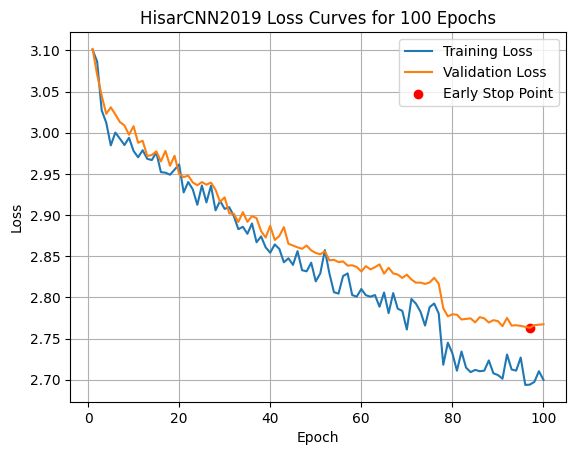

In [24]:
if(not(use_pretrained)): # Generate Loss Curves if Model was Recently Trained
    epoch_idx = np.arange(num_epochs) + 1
    plt.figure()
    plt.title(f'{model.name} Loss Curves for {num_epochs} Epochs')
    plt.plot(epoch_idx,train_loss)
    plt.plot(epoch_idx,val_loss)
    plt.scatter(np.argmin(val_loss)+1,np.min(val_loss),color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(['Training Loss', 'Validation Loss','Early Stop Point'])
    plt.savefig(f'./results/{model.name}_{num_epochs}_Loss.png')
    plt.show()

In [26]:
# Evaluating Based on SNR Threshold 
if(device == 'cuda'): # Free any Device Memory before Start Training
    torch.cuda.empty_cache()
modelDir = './models/HisarCNN2019_100_best.pt'
model = torch.load(modelDir)
thresh = 18 # SNR Thresholdh in dB
idxThresh  = np.where(Z_test >= thresh)[0]
eval_data = test_data[idxThresh]
eval_data = torch.utils.data.TensorDataset(*eval_data)
eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
test_acc = models.train.eval(device,model,eval_loader)
print(f'Model Test Accuracy for Samples above {thresh} dB: {test_acc:.3f}')

Model Test Accuracy for Samples above 18 dB: 0.77


In [27]:
# Evaluate Test Accuracies
test_accs = [] 
model = torch.load(modelDir)
for SNR in SNRs:
    idxThresh  = np.where(Z_test >= SNR)[0]
    eval_data = test_data[idxThresh]
    eval_data = torch.utils.data.TensorDataset(*eval_data)
    eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
    test_accs.append(models.train.eval(device,model,eval_loader))

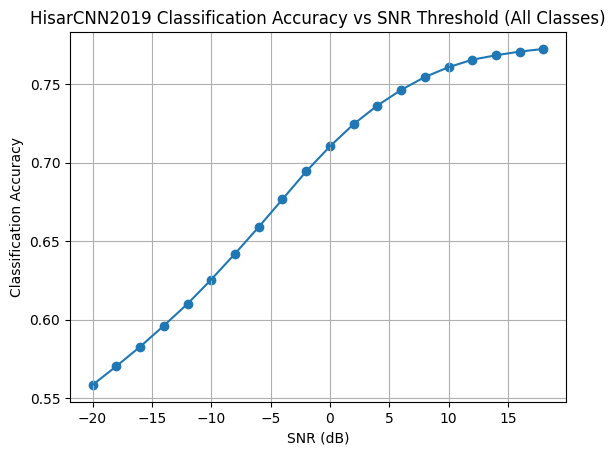

In [28]:
plt.figure()
plt.plot(SNRs,test_accs)
plt.scatter(SNRs,test_accs)
plt.grid()
plt.title(f'{model.name} Classification Accuracy vs SNR Threshold (All Classes)')
plt.xlabel('SNR (dB)')
plt.ylabel('Classification Accuracy')
plt.savefig(f'./results/{os.path.basename(modelDir).split(".pt")[0]}_SNRClassification.png')
plt.show()

## <a name="aug">Data Augmentation</a>

For data augmentation, we apply a temporal reversal on each of the IQ samples, since reordering of indexes doesn't affect whether the IQ signal is part of the same modulation symbol set. Overfitting is not an issue because of this invariance. Due to current restrictions in memory, data augmentation has only be extensively tested on the **RadioML 2016.01A** dataset. Working data augmentation implementations have enable flags for the other datasets in <code>models/datasets.py</code>, but caution is advised for the extensive amounts of memory required for your machine/GPU.

### RadioML 2016A

In [36]:
# Split RadioML 2016.10A Data into Train,Val,Test Subsets (90-5-5)%
split = np.array([90,5,5])/100
batch_size = 1024
augment = True
clearDatasetVars(tensors=True)
X,Y,Z,modClasses,SNRs = models.datasets.loadRadioML2016(radioML2016)
train_data,val_data,test_data,train_loader,val_loader,test_loader,Z_test = models.datasets.prepareDatasetRadioML(X,Y,Z,split,batch_size,augment)

# Freeing Memory of Intermediate Values 
clearDatasetVars(tensors=False)

In [28]:
use_pretrained = False

# Define the loss function 
criterion = nn.CrossEntropyLoss()

if(use_pretrained): # Evaluate Pre-Trained Augmented Models
    modelDir = './models/OSheaCNN2016_250_best_augmented.pt'
    model = torch.load(modelDir)
    test_acc =  models.train.eval(device,model,test_loader)
    print(f'Overall Test Acc: {test_acc:.3f}')
else: # Training Model
    model = OSheaCNN2016().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)
    num_epochs = 250
    if(device == 'cuda'): # Free any Device Memory before Start Training
        torch.cuda.empty_cache()
    train_loss, val_loss, min_val_loss, best_model =  models.train.train_earlystop(device,model,criterion,optimizer,train_loader,val_loader,test_loader,num_epochs)
    torch.save(model,f'./models/OSheaCNN2016_{num_epochs}_last_augmented.pt')
    torch.save(best_model,f'./models/OSheaCNN2016_{num_epochs}_best_augmented.pt')
    test_last_acc = models.train.eval(device,model,test_loader)
    test_best_acc = models.train.eval(device,best_model,test_loader)
    print(f'\nOverall Test Acc (Last Epoch): {test_last_acc:.3f}')
    print(f'Overall Test Acc (Best Val): {test_best_acc:.3f}')


Starting to Train OSheaCNN2016 for 250 Epochs!


  0%|▎                                                                                 | 1/250 [00:03<15:59,  3.85s/it]

Epoch [1/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.091, Val Acc: 0.087


  1%|▋                                                                                 | 2/250 [00:06<14:01,  3.39s/it]

Epoch [2/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.091, Val Acc: 0.087


  1%|▉                                                                                 | 3/250 [00:09<13:21,  3.24s/it]

Epoch [3/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.090, Val Acc: 0.087


  2%|█▎                                                                                | 4/250 [00:13<13:06,  3.20s/it]

Epoch [4/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.091, Val Acc: 0.087


  2%|█▋                                                                                | 5/250 [00:16<13:11,  3.23s/it]

Epoch [5/250]: Train Loss: 2.397 Val Loss: 2.398 Train Acc: 0.090, Val Acc: 0.087


  2%|█▉                                                                                | 6/250 [00:19<13:14,  3.26s/it]

Epoch [6/250]: Train Loss: 2.382 Val Loss: 2.373 Train Acc: 0.100, Val Acc: 0.129


  3%|██▎                                                                               | 7/250 [00:22<13:08,  3.24s/it]

Epoch [7/250]: Train Loss: 2.351 Val Loss: 2.356 Train Acc: 0.143, Val Acc: 0.177


  3%|██▌                                                                               | 8/250 [00:25<12:50,  3.18s/it]

Epoch [8/250]: Train Loss: 2.330 Val Loss: 2.352 Train Acc: 0.161, Val Acc: 0.176


  4%|██▉                                                                               | 9/250 [00:29<12:37,  3.14s/it]

Epoch [9/250]: Train Loss: 2.339 Val Loss: 2.347 Train Acc: 0.174, Val Acc: 0.183


  4%|███▏                                                                             | 10/250 [00:32<12:48,  3.20s/it]

Epoch [10/250]: Train Loss: 2.333 Val Loss: 2.343 Train Acc: 0.186, Val Acc: 0.189


  4%|███▌                                                                             | 11/250 [00:35<12:41,  3.19s/it]

Epoch [11/250]: Train Loss: 2.320 Val Loss: 2.334 Train Acc: 0.197, Val Acc: 0.201


  5%|███▉                                                                             | 12/250 [00:38<12:35,  3.17s/it]

Epoch [12/250]: Train Loss: 2.336 Val Loss: 2.331 Train Acc: 0.208, Val Acc: 0.203


  5%|████▏                                                                            | 13/250 [00:41<12:28,  3.16s/it]

Epoch [13/250]: Train Loss: 2.311 Val Loss: 2.320 Train Acc: 0.216, Val Acc: 0.220


  6%|████▌                                                                            | 14/250 [00:44<12:22,  3.14s/it]

Epoch [14/250]: Train Loss: 2.319 Val Loss: 2.314 Train Acc: 0.225, Val Acc: 0.228


  6%|████▊                                                                            | 15/250 [00:48<12:16,  3.13s/it]

Epoch [15/250]: Train Loss: 2.295 Val Loss: 2.304 Train Acc: 0.232, Val Acc: 0.242


  6%|█████▏                                                                           | 16/250 [00:51<12:23,  3.18s/it]

Epoch [16/250]: Train Loss: 2.312 Val Loss: 2.295 Train Acc: 0.237, Val Acc: 0.251


  7%|█████▌                                                                           | 17/250 [00:54<12:17,  3.16s/it]

Epoch [17/250]: Train Loss: 2.294 Val Loss: 2.290 Train Acc: 0.242, Val Acc: 0.257


  7%|█████▊                                                                           | 18/250 [00:57<12:09,  3.14s/it]

Epoch [18/250]: Train Loss: 2.287 Val Loss: 2.291 Train Acc: 0.247, Val Acc: 0.257


  8%|██████▏                                                                          | 19/250 [01:00<12:01,  3.12s/it]

Epoch [19/250]: Train Loss: 2.288 Val Loss: 2.283 Train Acc: 0.250, Val Acc: 0.265


  8%|██████▍                                                                          | 20/250 [01:03<11:57,  3.12s/it]

Epoch [20/250]: Train Loss: 2.289 Val Loss: 2.282 Train Acc: 0.252, Val Acc: 0.266


  8%|██████▊                                                                          | 21/250 [01:06<11:50,  3.10s/it]

Epoch [21/250]: Train Loss: 2.269 Val Loss: 2.280 Train Acc: 0.254, Val Acc: 0.268


  9%|███████▏                                                                         | 22/250 [01:10<11:59,  3.15s/it]

Epoch [22/250]: Train Loss: 2.267 Val Loss: 2.274 Train Acc: 0.256, Val Acc: 0.271


  9%|███████▍                                                                         | 23/250 [01:13<11:53,  3.14s/it]

Epoch [23/250]: Train Loss: 2.253 Val Loss: 2.272 Train Acc: 0.259, Val Acc: 0.274


 10%|███████▊                                                                         | 24/250 [01:16<11:44,  3.12s/it]

Epoch [24/250]: Train Loss: 2.278 Val Loss: 2.273 Train Acc: 0.261, Val Acc: 0.274


 10%|████████                                                                         | 25/250 [01:19<11:37,  3.10s/it]

Epoch [25/250]: Train Loss: 2.264 Val Loss: 2.271 Train Acc: 0.262, Val Acc: 0.275


 10%|████████▍                                                                        | 26/250 [01:22<11:33,  3.09s/it]

Epoch [26/250]: Train Loss: 2.275 Val Loss: 2.265 Train Acc: 0.264, Val Acc: 0.280


 11%|████████▋                                                                        | 27/250 [01:25<11:29,  3.09s/it]

Epoch [27/250]: Train Loss: 2.266 Val Loss: 2.265 Train Acc: 0.264, Val Acc: 0.281


 11%|█████████                                                                        | 28/250 [01:28<11:28,  3.10s/it]

Epoch [28/250]: Train Loss: 2.261 Val Loss: 2.264 Train Acc: 0.266, Val Acc: 0.282


 12%|█████████▍                                                                       | 29/250 [01:31<11:27,  3.11s/it]

Epoch [29/250]: Train Loss: 2.263 Val Loss: 2.264 Train Acc: 0.268, Val Acc: 0.282


 12%|█████████▋                                                                       | 30/250 [01:34<11:28,  3.13s/it]

Epoch [30/250]: Train Loss: 2.280 Val Loss: 2.262 Train Acc: 0.268, Val Acc: 0.282


 12%|██████████                                                                       | 31/250 [01:37<11:17,  3.09s/it]

Epoch [31/250]: Train Loss: 2.268 Val Loss: 2.260 Train Acc: 0.269, Val Acc: 0.284


 13%|██████████▎                                                                      | 32/250 [01:40<11:07,  3.06s/it]

Epoch [32/250]: Train Loss: 2.235 Val Loss: 2.260 Train Acc: 0.272, Val Acc: 0.286


 13%|██████████▋                                                                      | 33/250 [01:43<10:56,  3.03s/it]

Epoch [33/250]: Train Loss: 2.281 Val Loss: 2.254 Train Acc: 0.275, Val Acc: 0.290


 14%|███████████                                                                      | 34/250 [01:46<10:52,  3.02s/it]

Epoch [34/250]: Train Loss: 2.264 Val Loss: 2.254 Train Acc: 0.277, Val Acc: 0.298


 14%|███████████▎                                                                     | 35/250 [01:49<10:46,  3.01s/it]

Epoch [35/250]: Train Loss: 2.257 Val Loss: 2.253 Train Acc: 0.280, Val Acc: 0.302


 14%|███████████▋                                                                     | 36/250 [01:53<10:56,  3.07s/it]

Epoch [36/250]: Train Loss: 2.260 Val Loss: 2.250 Train Acc: 0.283, Val Acc: 0.305


 15%|███████████▉                                                                     | 37/250 [01:56<10:49,  3.05s/it]

Epoch [37/250]: Train Loss: 2.267 Val Loss: 2.247 Train Acc: 0.286, Val Acc: 0.306


 15%|████████████▎                                                                    | 38/250 [01:58<10:42,  3.03s/it]

Epoch [38/250]: Train Loss: 2.238 Val Loss: 2.246 Train Acc: 0.287, Val Acc: 0.306


 16%|████████████▋                                                                    | 39/250 [02:02<10:38,  3.02s/it]

Epoch [39/250]: Train Loss: 2.225 Val Loss: 2.243 Train Acc: 0.290, Val Acc: 0.308


 16%|████████████▉                                                                    | 40/250 [02:04<10:32,  3.01s/it]

Epoch [40/250]: Train Loss: 2.242 Val Loss: 2.241 Train Acc: 0.291, Val Acc: 0.310


 16%|█████████████▎                                                                   | 41/250 [02:07<10:26,  3.00s/it]

Epoch [41/250]: Train Loss: 2.247 Val Loss: 2.240 Train Acc: 0.293, Val Acc: 0.309


 17%|█████████████▌                                                                   | 42/250 [02:10<10:21,  2.99s/it]

Epoch [42/250]: Train Loss: 2.241 Val Loss: 2.239 Train Acc: 0.294, Val Acc: 0.311


 17%|█████████████▉                                                                   | 43/250 [02:13<10:17,  2.98s/it]

Epoch [43/250]: Train Loss: 2.238 Val Loss: 2.236 Train Acc: 0.296, Val Acc: 0.313


 18%|██████████████▎                                                                  | 44/250 [02:16<10:14,  2.98s/it]

Epoch [44/250]: Train Loss: 2.263 Val Loss: 2.235 Train Acc: 0.297, Val Acc: 0.315


 18%|██████████████▌                                                                  | 45/250 [02:19<10:13,  2.99s/it]

Epoch [45/250]: Train Loss: 2.216 Val Loss: 2.235 Train Acc: 0.298, Val Acc: 0.314


 18%|██████████████▉                                                                  | 46/250 [02:22<10:15,  3.02s/it]

Epoch [46/250]: Train Loss: 2.226 Val Loss: 2.235 Train Acc: 0.299, Val Acc: 0.315


 19%|███████████████▏                                                                 | 47/250 [02:25<10:09,  3.00s/it]

Epoch [47/250]: Train Loss: 2.237 Val Loss: 2.232 Train Acc: 0.301, Val Acc: 0.317


 19%|███████████████▌                                                                 | 48/250 [02:28<10:03,  2.99s/it]

Epoch [48/250]: Train Loss: 2.211 Val Loss: 2.228 Train Acc: 0.301, Val Acc: 0.319


 20%|███████████████▉                                                                 | 49/250 [02:31<09:59,  2.98s/it]

Epoch [49/250]: Train Loss: 2.221 Val Loss: 2.228 Train Acc: 0.303, Val Acc: 0.319


 20%|████████████████▏                                                                | 50/250 [02:34<09:56,  2.98s/it]

Epoch [50/250]: Train Loss: 2.235 Val Loss: 2.224 Train Acc: 0.305, Val Acc: 0.322


 20%|████████████████▌                                                                | 51/250 [02:37<09:53,  2.98s/it]

Epoch [51/250]: Train Loss: 2.242 Val Loss: 2.227 Train Acc: 0.305, Val Acc: 0.317


 21%|████████████████▊                                                                | 52/250 [02:40<09:52,  2.99s/it]

Epoch [52/250]: Train Loss: 2.224 Val Loss: 2.226 Train Acc: 0.306, Val Acc: 0.320


 21%|█████████████████▏                                                               | 53/250 [02:43<09:48,  2.99s/it]

Epoch [53/250]: Train Loss: 2.223 Val Loss: 2.220 Train Acc: 0.308, Val Acc: 0.326


 22%|█████████████████▍                                                               | 54/250 [02:46<09:43,  2.98s/it]

Epoch [54/250]: Train Loss: 2.247 Val Loss: 2.217 Train Acc: 0.309, Val Acc: 0.330


 22%|█████████████████▊                                                               | 55/250 [02:49<09:39,  2.97s/it]

Epoch [55/250]: Train Loss: 2.202 Val Loss: 2.216 Train Acc: 0.311, Val Acc: 0.329


 22%|██████████████████▏                                                              | 56/250 [02:52<09:37,  2.98s/it]

Epoch [56/250]: Train Loss: 2.233 Val Loss: 2.211 Train Acc: 0.313, Val Acc: 0.335


 23%|██████████████████▍                                                              | 57/250 [02:55<09:33,  2.97s/it]

Epoch [57/250]: Train Loss: 2.218 Val Loss: 2.215 Train Acc: 0.314, Val Acc: 0.334


 23%|██████████████████▊                                                              | 58/250 [02:58<09:29,  2.97s/it]

Epoch [58/250]: Train Loss: 2.224 Val Loss: 2.210 Train Acc: 0.315, Val Acc: 0.337


 24%|███████████████████                                                              | 59/250 [03:01<09:29,  2.98s/it]

Epoch [59/250]: Train Loss: 2.213 Val Loss: 2.209 Train Acc: 0.316, Val Acc: 0.338


 24%|███████████████████▍                                                             | 60/250 [03:04<09:26,  2.98s/it]

Epoch [60/250]: Train Loss: 2.197 Val Loss: 2.206 Train Acc: 0.317, Val Acc: 0.344


 24%|███████████████████▊                                                             | 61/250 [03:07<09:22,  2.98s/it]

Epoch [61/250]: Train Loss: 2.223 Val Loss: 2.203 Train Acc: 0.318, Val Acc: 0.345


 25%|████████████████████                                                             | 62/250 [03:10<09:19,  2.97s/it]

Epoch [62/250]: Train Loss: 2.210 Val Loss: 2.203 Train Acc: 0.319, Val Acc: 0.345


 25%|████████████████████▍                                                            | 63/250 [03:13<09:15,  2.97s/it]

Epoch [63/250]: Train Loss: 2.214 Val Loss: 2.203 Train Acc: 0.320, Val Acc: 0.346


 26%|████████████████████▋                                                            | 64/250 [03:16<09:13,  2.98s/it]

Epoch [64/250]: Train Loss: 2.236 Val Loss: 2.200 Train Acc: 0.320, Val Acc: 0.349


 26%|█████████████████████                                                            | 65/250 [03:19<09:10,  2.97s/it]

Epoch [65/250]: Train Loss: 2.209 Val Loss: 2.199 Train Acc: 0.322, Val Acc: 0.349


 26%|█████████████████████▍                                                           | 66/250 [03:22<09:06,  2.97s/it]

Epoch [66/250]: Train Loss: 2.200 Val Loss: 2.196 Train Acc: 0.323, Val Acc: 0.350


 27%|█████████████████████▋                                                           | 67/250 [03:25<09:02,  2.97s/it]

Epoch [67/250]: Train Loss: 2.223 Val Loss: 2.194 Train Acc: 0.323, Val Acc: 0.352


 27%|██████████████████████                                                           | 68/250 [03:28<09:00,  2.97s/it]

Epoch [68/250]: Train Loss: 2.217 Val Loss: 2.192 Train Acc: 0.325, Val Acc: 0.353


 28%|██████████████████████▎                                                          | 69/250 [03:31<08:58,  2.97s/it]

Epoch [69/250]: Train Loss: 2.229 Val Loss: 2.190 Train Acc: 0.326, Val Acc: 0.354


 28%|██████████████████████▋                                                          | 70/250 [03:34<08:54,  2.97s/it]

Epoch [70/250]: Train Loss: 2.189 Val Loss: 2.191 Train Acc: 0.327, Val Acc: 0.354


 28%|███████████████████████                                                          | 71/250 [03:37<08:55,  2.99s/it]

Epoch [71/250]: Train Loss: 2.231 Val Loss: 2.189 Train Acc: 0.329, Val Acc: 0.356


 29%|███████████████████████▎                                                         | 72/250 [03:40<08:53,  2.99s/it]

Epoch [72/250]: Train Loss: 2.207 Val Loss: 2.188 Train Acc: 0.330, Val Acc: 0.357


 29%|███████████████████████▋                                                         | 73/250 [03:43<08:48,  2.98s/it]

Epoch [73/250]: Train Loss: 2.222 Val Loss: 2.192 Train Acc: 0.331, Val Acc: 0.355


 30%|███████████████████████▉                                                         | 74/250 [03:46<08:44,  2.98s/it]

Epoch [74/250]: Train Loss: 2.205 Val Loss: 2.187 Train Acc: 0.332, Val Acc: 0.359


 30%|████████████████████████▎                                                        | 75/250 [03:49<08:42,  2.99s/it]

Epoch [75/250]: Train Loss: 2.196 Val Loss: 2.188 Train Acc: 0.334, Val Acc: 0.358


 30%|████████████████████████▌                                                        | 76/250 [03:52<08:38,  2.98s/it]

Epoch [76/250]: Train Loss: 2.184 Val Loss: 2.184 Train Acc: 0.335, Val Acc: 0.361


 31%|████████████████████████▉                                                        | 77/250 [03:55<08:38,  3.00s/it]

Epoch [77/250]: Train Loss: 2.210 Val Loss: 2.184 Train Acc: 0.336, Val Acc: 0.365


 31%|█████████████████████████▎                                                       | 78/250 [03:58<08:33,  2.99s/it]

Epoch [78/250]: Train Loss: 2.206 Val Loss: 2.185 Train Acc: 0.336, Val Acc: 0.364


 32%|█████████████████████████▌                                                       | 79/250 [04:01<08:30,  2.98s/it]

Epoch [79/250]: Train Loss: 2.226 Val Loss: 2.181 Train Acc: 0.338, Val Acc: 0.366


 32%|█████████████████████████▉                                                       | 80/250 [04:04<08:27,  2.98s/it]

Epoch [80/250]: Train Loss: 2.233 Val Loss: 2.181 Train Acc: 0.339, Val Acc: 0.368


 32%|██████████████████████████▏                                                      | 81/250 [04:07<08:23,  2.98s/it]

Epoch [81/250]: Train Loss: 2.200 Val Loss: 2.181 Train Acc: 0.339, Val Acc: 0.367


 33%|██████████████████████████▌                                                      | 82/250 [04:10<08:18,  2.97s/it]

Epoch [82/250]: Train Loss: 2.198 Val Loss: 2.180 Train Acc: 0.341, Val Acc: 0.368


 33%|██████████████████████████▉                                                      | 83/250 [04:13<08:15,  2.97s/it]

Epoch [83/250]: Train Loss: 2.193 Val Loss: 2.178 Train Acc: 0.341, Val Acc: 0.369


 34%|███████████████████████████▏                                                     | 84/250 [04:16<08:15,  2.98s/it]

Epoch [84/250]: Train Loss: 2.219 Val Loss: 2.177 Train Acc: 0.341, Val Acc: 0.371


 34%|███████████████████████████▌                                                     | 85/250 [04:19<08:12,  2.99s/it]

Epoch [85/250]: Train Loss: 2.219 Val Loss: 2.175 Train Acc: 0.343, Val Acc: 0.371


 34%|███████████████████████████▊                                                     | 86/250 [04:22<08:08,  2.98s/it]

Epoch [86/250]: Train Loss: 2.185 Val Loss: 2.174 Train Acc: 0.343, Val Acc: 0.375


 35%|████████████████████████████▏                                                    | 87/250 [04:25<08:05,  2.98s/it]

Epoch [87/250]: Train Loss: 2.168 Val Loss: 2.175 Train Acc: 0.345, Val Acc: 0.375


 35%|████████████████████████████▌                                                    | 88/250 [04:28<08:01,  2.97s/it]

Epoch [88/250]: Train Loss: 2.198 Val Loss: 2.173 Train Acc: 0.345, Val Acc: 0.374


 36%|████████████████████████████▊                                                    | 89/250 [04:31<08:02,  3.00s/it]

Epoch [89/250]: Train Loss: 2.172 Val Loss: 2.172 Train Acc: 0.346, Val Acc: 0.376


 36%|█████████████████████████████▏                                                   | 90/250 [04:34<07:57,  2.98s/it]

Epoch [90/250]: Train Loss: 2.202 Val Loss: 2.170 Train Acc: 0.346, Val Acc: 0.378


 36%|█████████████████████████████▍                                                   | 91/250 [04:36<07:53,  2.98s/it]

Epoch [91/250]: Train Loss: 2.205 Val Loss: 2.168 Train Acc: 0.347, Val Acc: 0.376


 37%|█████████████████████████████▊                                                   | 92/250 [04:39<07:51,  2.98s/it]

Epoch [92/250]: Train Loss: 2.181 Val Loss: 2.170 Train Acc: 0.348, Val Acc: 0.376


 37%|██████████████████████████████▏                                                  | 93/250 [04:42<07:47,  2.97s/it]

Epoch [93/250]: Train Loss: 2.162 Val Loss: 2.167 Train Acc: 0.348, Val Acc: 0.381


 38%|██████████████████████████████▍                                                  | 94/250 [04:45<07:42,  2.97s/it]

Epoch [94/250]: Train Loss: 2.204 Val Loss: 2.166 Train Acc: 0.349, Val Acc: 0.380


 38%|██████████████████████████████▊                                                  | 95/250 [04:48<07:39,  2.96s/it]

Epoch [95/250]: Train Loss: 2.176 Val Loss: 2.166 Train Acc: 0.350, Val Acc: 0.381


 38%|███████████████████████████████                                                  | 96/250 [04:51<07:39,  2.98s/it]

Epoch [96/250]: Train Loss: 2.178 Val Loss: 2.163 Train Acc: 0.350, Val Acc: 0.382


 39%|███████████████████████████████▍                                                 | 97/250 [04:54<07:36,  2.98s/it]

Epoch [97/250]: Train Loss: 2.208 Val Loss: 2.166 Train Acc: 0.351, Val Acc: 0.381


 39%|███████████████████████████████▊                                                 | 98/250 [04:57<07:33,  2.98s/it]

Epoch [98/250]: Train Loss: 2.209 Val Loss: 2.164 Train Acc: 0.352, Val Acc: 0.384


 40%|████████████████████████████████                                                 | 99/250 [05:00<07:29,  2.98s/it]

Epoch [99/250]: Train Loss: 2.164 Val Loss: 2.166 Train Acc: 0.353, Val Acc: 0.380


 40%|████████████████████████████████                                                | 100/250 [05:03<07:25,  2.97s/it]

Epoch [100/250]: Train Loss: 2.161 Val Loss: 2.162 Train Acc: 0.353, Val Acc: 0.383


 40%|████████████████████████████████▎                                               | 101/250 [05:06<07:22,  2.97s/it]

Epoch [101/250]: Train Loss: 2.201 Val Loss: 2.165 Train Acc: 0.353, Val Acc: 0.383


 41%|████████████████████████████████▋                                               | 102/250 [05:09<07:21,  2.98s/it]

Epoch [102/250]: Train Loss: 2.172 Val Loss: 2.164 Train Acc: 0.354, Val Acc: 0.384


 41%|████████████████████████████████▉                                               | 103/250 [05:12<07:17,  2.98s/it]

Epoch [103/250]: Train Loss: 2.183 Val Loss: 2.162 Train Acc: 0.355, Val Acc: 0.385


 42%|█████████████████████████████████▎                                              | 104/250 [05:15<07:17,  3.00s/it]

Epoch [104/250]: Train Loss: 2.194 Val Loss: 2.160 Train Acc: 0.355, Val Acc: 0.386


 42%|█████████████████████████████████▌                                              | 105/250 [05:18<07:13,  2.99s/it]

Epoch [105/250]: Train Loss: 2.206 Val Loss: 2.163 Train Acc: 0.355, Val Acc: 0.385


 42%|█████████████████████████████████▉                                              | 106/250 [05:21<07:09,  2.98s/it]

Epoch [106/250]: Train Loss: 2.181 Val Loss: 2.164 Train Acc: 0.357, Val Acc: 0.382


 43%|██████████████████████████████████▏                                             | 107/250 [05:24<07:05,  2.97s/it]

Epoch [107/250]: Train Loss: 2.196 Val Loss: 2.163 Train Acc: 0.357, Val Acc: 0.385


 43%|██████████████████████████████████▌                                             | 108/250 [05:27<07:01,  2.97s/it]

Epoch [108/250]: Train Loss: 2.182 Val Loss: 2.162 Train Acc: 0.358, Val Acc: 0.387


 44%|██████████████████████████████████▉                                             | 109/250 [05:30<07:01,  2.99s/it]

Epoch [109/250]: Train Loss: 2.180 Val Loss: 2.160 Train Acc: 0.357, Val Acc: 0.386


 44%|███████████████████████████████████▏                                            | 110/250 [05:33<06:57,  2.98s/it]

Epoch [110/250]: Train Loss: 2.173 Val Loss: 2.159 Train Acc: 0.358, Val Acc: 0.387


 44%|███████████████████████████████████▌                                            | 111/250 [05:36<06:55,  2.99s/it]

Epoch [111/250]: Train Loss: 2.168 Val Loss: 2.159 Train Acc: 0.359, Val Acc: 0.390


 45%|███████████████████████████████████▊                                            | 112/250 [05:39<06:53,  3.00s/it]

Epoch [112/250]: Train Loss: 2.183 Val Loss: 2.163 Train Acc: 0.359, Val Acc: 0.384


 45%|████████████████████████████████████▏                                           | 113/250 [05:42<06:49,  2.99s/it]

Epoch [113/250]: Train Loss: 2.178 Val Loss: 2.160 Train Acc: 0.358, Val Acc: 0.387


 46%|████████████████████████████████████▍                                           | 114/250 [05:45<06:48,  3.00s/it]

Epoch [114/250]: Train Loss: 2.168 Val Loss: 2.162 Train Acc: 0.360, Val Acc: 0.386


 46%|████████████████████████████████████▊                                           | 115/250 [05:48<06:44,  3.00s/it]

Epoch [115/250]: Train Loss: 2.173 Val Loss: 2.162 Train Acc: 0.360, Val Acc: 0.384


 46%|█████████████████████████████████████                                           | 116/250 [05:51<06:40,  2.99s/it]

Epoch [116/250]: Train Loss: 2.163 Val Loss: 2.158 Train Acc: 0.361, Val Acc: 0.389


 47%|█████████████████████████████████████▍                                          | 117/250 [05:54<06:48,  3.07s/it]

Epoch [117/250]: Train Loss: 2.201 Val Loss: 2.160 Train Acc: 0.361, Val Acc: 0.390


 47%|█████████████████████████████████████▊                                          | 118/250 [05:58<06:49,  3.11s/it]

Epoch [118/250]: Train Loss: 2.179 Val Loss: 2.158 Train Acc: 0.360, Val Acc: 0.388


 48%|██████████████████████████████████████                                          | 119/250 [06:00<06:40,  3.06s/it]

Epoch [119/250]: Train Loss: 2.175 Val Loss: 2.157 Train Acc: 0.362, Val Acc: 0.389


 48%|██████████████████████████████████████▍                                         | 120/250 [06:03<06:34,  3.04s/it]

Epoch [120/250]: Train Loss: 2.195 Val Loss: 2.158 Train Acc: 0.361, Val Acc: 0.388


 48%|██████████████████████████████████████▋                                         | 121/250 [06:06<06:31,  3.04s/it]

Epoch [121/250]: Train Loss: 2.186 Val Loss: 2.158 Train Acc: 0.362, Val Acc: 0.390


 49%|███████████████████████████████████████                                         | 122/250 [06:09<06:25,  3.01s/it]

Epoch [122/250]: Train Loss: 2.172 Val Loss: 2.160 Train Acc: 0.362, Val Acc: 0.387


 49%|███████████████████████████████████████▎                                        | 123/250 [06:12<06:21,  3.00s/it]

Epoch [123/250]: Train Loss: 2.178 Val Loss: 2.157 Train Acc: 0.363, Val Acc: 0.389


 50%|███████████████████████████████████████▋                                        | 124/250 [06:15<06:17,  2.99s/it]

Epoch [124/250]: Train Loss: 2.160 Val Loss: 2.159 Train Acc: 0.364, Val Acc: 0.388


 50%|████████████████████████████████████████                                        | 125/250 [06:18<06:14,  2.99s/it]

Epoch [125/250]: Train Loss: 2.146 Val Loss: 2.159 Train Acc: 0.363, Val Acc: 0.389


 50%|████████████████████████████████████████▎                                       | 126/250 [06:21<06:11,  2.99s/it]

Epoch [126/250]: Train Loss: 2.176 Val Loss: 2.157 Train Acc: 0.363, Val Acc: 0.391


 51%|████████████████████████████████████████▋                                       | 127/250 [06:25<06:14,  3.04s/it]

Epoch [127/250]: Train Loss: 2.153 Val Loss: 2.158 Train Acc: 0.364, Val Acc: 0.389


 51%|████████████████████████████████████████▉                                       | 128/250 [06:28<06:23,  3.14s/it]

Epoch [128/250]: Train Loss: 2.197 Val Loss: 2.156 Train Acc: 0.364, Val Acc: 0.391


 52%|█████████████████████████████████████████▎                                      | 129/250 [06:31<06:15,  3.11s/it]

Epoch [129/250]: Train Loss: 2.197 Val Loss: 2.155 Train Acc: 0.364, Val Acc: 0.389


 52%|█████████████████████████████████████████▌                                      | 130/250 [06:34<06:08,  3.07s/it]

Epoch [130/250]: Train Loss: 2.175 Val Loss: 2.154 Train Acc: 0.364, Val Acc: 0.392


 52%|█████████████████████████████████████████▉                                      | 131/250 [06:37<06:02,  3.05s/it]

Epoch [131/250]: Train Loss: 2.200 Val Loss: 2.156 Train Acc: 0.364, Val Acc: 0.392


 53%|██████████████████████████████████████████▏                                     | 132/250 [06:40<06:04,  3.09s/it]

Epoch [132/250]: Train Loss: 2.182 Val Loss: 2.155 Train Acc: 0.364, Val Acc: 0.390


 53%|██████████████████████████████████████████▌                                     | 133/250 [06:43<06:11,  3.18s/it]

Epoch [133/250]: Train Loss: 2.181 Val Loss: 2.153 Train Acc: 0.365, Val Acc: 0.395


 54%|██████████████████████████████████████████▉                                     | 134/250 [06:47<06:15,  3.24s/it]

Epoch [134/250]: Train Loss: 2.196 Val Loss: 2.154 Train Acc: 0.366, Val Acc: 0.393


 54%|███████████████████████████████████████████▏                                    | 135/250 [06:50<06:07,  3.19s/it]

Epoch [135/250]: Train Loss: 2.189 Val Loss: 2.152 Train Acc: 0.366, Val Acc: 0.394


 54%|███████████████████████████████████████████▌                                    | 136/250 [06:53<06:04,  3.20s/it]

Epoch [136/250]: Train Loss: 2.154 Val Loss: 2.155 Train Acc: 0.365, Val Acc: 0.394


 55%|███████████████████████████████████████████▊                                    | 137/250 [06:57<06:09,  3.27s/it]

Epoch [137/250]: Train Loss: 2.142 Val Loss: 2.153 Train Acc: 0.366, Val Acc: 0.394


 55%|████████████████████████████████████████████▏                                   | 138/250 [07:00<05:59,  3.21s/it]

Epoch [138/250]: Train Loss: 2.155 Val Loss: 2.154 Train Acc: 0.367, Val Acc: 0.395


 56%|████████████████████████████████████████████▍                                   | 139/250 [07:03<05:54,  3.19s/it]

Epoch [139/250]: Train Loss: 2.172 Val Loss: 2.155 Train Acc: 0.367, Val Acc: 0.392


 56%|████████████████████████████████████████████▊                                   | 140/250 [07:06<05:47,  3.16s/it]

Epoch [140/250]: Train Loss: 2.171 Val Loss: 2.154 Train Acc: 0.367, Val Acc: 0.393


 56%|█████████████████████████████████████████████                                   | 141/250 [07:09<05:41,  3.13s/it]

Epoch [141/250]: Train Loss: 2.158 Val Loss: 2.154 Train Acc: 0.368, Val Acc: 0.393


 57%|█████████████████████████████████████████████▍                                  | 142/250 [07:12<05:36,  3.12s/it]

Epoch [142/250]: Train Loss: 2.164 Val Loss: 2.154 Train Acc: 0.368, Val Acc: 0.395


 57%|█████████████████████████████████████████████▊                                  | 143/250 [07:15<05:32,  3.11s/it]

Epoch [143/250]: Train Loss: 2.189 Val Loss: 2.156 Train Acc: 0.368, Val Acc: 0.393


 58%|██████████████████████████████████████████████                                  | 144/250 [07:18<05:29,  3.11s/it]

Epoch [144/250]: Train Loss: 2.189 Val Loss: 2.150 Train Acc: 0.368, Val Acc: 0.397


 58%|██████████████████████████████████████████████▍                                 | 145/250 [07:21<05:27,  3.12s/it]

Epoch [145/250]: Train Loss: 2.171 Val Loss: 2.152 Train Acc: 0.369, Val Acc: 0.394


 58%|██████████████████████████████████████████████▋                                 | 146/250 [07:25<05:25,  3.13s/it]

Epoch [146/250]: Train Loss: 2.188 Val Loss: 2.154 Train Acc: 0.369, Val Acc: 0.394


 59%|███████████████████████████████████████████████                                 | 147/250 [07:28<05:21,  3.12s/it]

Epoch [147/250]: Train Loss: 2.156 Val Loss: 2.152 Train Acc: 0.370, Val Acc: 0.396


 59%|███████████████████████████████████████████████▎                                | 148/250 [07:31<05:17,  3.12s/it]

Epoch [148/250]: Train Loss: 2.172 Val Loss: 2.152 Train Acc: 0.370, Val Acc: 0.397


 60%|███████████████████████████████████████████████▋                                | 149/250 [07:34<05:14,  3.11s/it]

Epoch [149/250]: Train Loss: 2.157 Val Loss: 2.150 Train Acc: 0.370, Val Acc: 0.398


 60%|████████████████████████████████████████████████                                | 150/250 [07:37<05:12,  3.12s/it]

Epoch [150/250]: Train Loss: 2.153 Val Loss: 2.152 Train Acc: 0.371, Val Acc: 0.397


 60%|████████████████████████████████████████████████▎                               | 151/250 [07:40<05:18,  3.21s/it]

Epoch [151/250]: Train Loss: 2.155 Val Loss: 2.153 Train Acc: 0.369, Val Acc: 0.394


 61%|████████████████████████████████████████████████▋                               | 152/250 [07:44<05:15,  3.22s/it]

Epoch [152/250]: Train Loss: 2.185 Val Loss: 2.153 Train Acc: 0.370, Val Acc: 0.396


 61%|████████████████████████████████████████████████▉                               | 153/250 [07:47<05:08,  3.18s/it]

Epoch [153/250]: Train Loss: 2.171 Val Loss: 2.152 Train Acc: 0.371, Val Acc: 0.397


 62%|█████████████████████████████████████████████████▎                              | 154/250 [07:50<05:02,  3.15s/it]

Epoch [154/250]: Train Loss: 2.192 Val Loss: 2.152 Train Acc: 0.372, Val Acc: 0.396


 62%|█████████████████████████████████████████████████▌                              | 155/250 [07:53<04:57,  3.14s/it]

Epoch [155/250]: Train Loss: 2.181 Val Loss: 2.151 Train Acc: 0.371, Val Acc: 0.397


 62%|█████████████████████████████████████████████████▉                              | 156/250 [07:56<04:53,  3.12s/it]

Epoch [156/250]: Train Loss: 2.167 Val Loss: 2.152 Train Acc: 0.372, Val Acc: 0.394


 63%|██████████████████████████████████████████████████▏                             | 157/250 [07:59<04:49,  3.11s/it]

Epoch [157/250]: Train Loss: 2.165 Val Loss: 2.150 Train Acc: 0.372, Val Acc: 0.398


 63%|██████████████████████████████████████████████████▌                             | 158/250 [08:02<04:45,  3.10s/it]

Epoch [158/250]: Train Loss: 2.176 Val Loss: 2.150 Train Acc: 0.372, Val Acc: 0.397


 64%|██████████████████████████████████████████████████▉                             | 159/250 [08:05<04:43,  3.11s/it]

Epoch [159/250]: Train Loss: 2.182 Val Loss: 2.151 Train Acc: 0.373, Val Acc: 0.398


 64%|███████████████████████████████████████████████████▏                            | 160/250 [08:08<04:38,  3.10s/it]

Epoch [160/250]: Train Loss: 2.166 Val Loss: 2.149 Train Acc: 0.373, Val Acc: 0.399


 64%|███████████████████████████████████████████████████▌                            | 161/250 [08:11<04:35,  3.09s/it]

Epoch [161/250]: Train Loss: 2.161 Val Loss: 2.150 Train Acc: 0.373, Val Acc: 0.399


 65%|███████████████████████████████████████████████████▊                            | 162/250 [08:15<04:31,  3.09s/it]

Epoch [162/250]: Train Loss: 2.179 Val Loss: 2.148 Train Acc: 0.373, Val Acc: 0.400


 65%|████████████████████████████████████████████████████▏                           | 163/250 [08:18<04:28,  3.09s/it]

Epoch [163/250]: Train Loss: 2.171 Val Loss: 2.149 Train Acc: 0.374, Val Acc: 0.400


 66%|████████████████████████████████████████████████████▍                           | 164/250 [08:21<04:28,  3.13s/it]

Epoch [164/250]: Train Loss: 2.152 Val Loss: 2.150 Train Acc: 0.374, Val Acc: 0.401


 66%|████████████████████████████████████████████████████▊                           | 165/250 [08:24<04:25,  3.12s/it]

Epoch [165/250]: Train Loss: 2.165 Val Loss: 2.150 Train Acc: 0.374, Val Acc: 0.396


 66%|█████████████████████████████████████████████████████                           | 166/250 [08:27<04:22,  3.12s/it]

Epoch [166/250]: Train Loss: 2.152 Val Loss: 2.150 Train Acc: 0.375, Val Acc: 0.397


 67%|█████████████████████████████████████████████████████▍                          | 167/250 [08:30<04:18,  3.12s/it]

Epoch [167/250]: Train Loss: 2.173 Val Loss: 2.149 Train Acc: 0.376, Val Acc: 0.399


 67%|█████████████████████████████████████████████████████▊                          | 168/250 [08:33<04:15,  3.11s/it]

Epoch [168/250]: Train Loss: 2.148 Val Loss: 2.148 Train Acc: 0.375, Val Acc: 0.398


 68%|██████████████████████████████████████████████████████                          | 169/250 [08:36<04:11,  3.11s/it]

Epoch [169/250]: Train Loss: 2.159 Val Loss: 2.146 Train Acc: 0.376, Val Acc: 0.399


 68%|██████████████████████████████████████████████████████▍                         | 170/250 [08:39<04:08,  3.11s/it]

Epoch [170/250]: Train Loss: 2.153 Val Loss: 2.148 Train Acc: 0.376, Val Acc: 0.400


 68%|██████████████████████████████████████████████████████▋                         | 171/250 [08:43<04:05,  3.11s/it]

Epoch [171/250]: Train Loss: 2.156 Val Loss: 2.146 Train Acc: 0.377, Val Acc: 0.400


 69%|███████████████████████████████████████████████████████                         | 172/250 [08:46<04:02,  3.11s/it]

Epoch [172/250]: Train Loss: 2.180 Val Loss: 2.148 Train Acc: 0.377, Val Acc: 0.399


 69%|███████████████████████████████████████████████████████▎                        | 173/250 [08:49<03:58,  3.10s/it]

Epoch [173/250]: Train Loss: 2.172 Val Loss: 2.146 Train Acc: 0.377, Val Acc: 0.403


 70%|███████████████████████████████████████████████████████▋                        | 174/250 [08:52<03:55,  3.09s/it]

Epoch [174/250]: Train Loss: 2.171 Val Loss: 2.145 Train Acc: 0.377, Val Acc: 0.403


 70%|████████████████████████████████████████████████████████                        | 175/250 [08:55<03:52,  3.10s/it]

Epoch [175/250]: Train Loss: 2.154 Val Loss: 2.144 Train Acc: 0.377, Val Acc: 0.405


 70%|████████████████████████████████████████████████████████▎                       | 176/250 [08:58<03:49,  3.10s/it]

Epoch [176/250]: Train Loss: 2.139 Val Loss: 2.144 Train Acc: 0.378, Val Acc: 0.404


 71%|████████████████████████████████████████████████████████▋                       | 177/250 [09:01<03:47,  3.12s/it]

Epoch [177/250]: Train Loss: 2.135 Val Loss: 2.141 Train Acc: 0.377, Val Acc: 0.405


 71%|████████████████████████████████████████████████████████▉                       | 178/250 [09:04<03:43,  3.11s/it]

Epoch [178/250]: Train Loss: 2.167 Val Loss: 2.144 Train Acc: 0.379, Val Acc: 0.403


 72%|█████████████████████████████████████████████████████████▎                      | 179/250 [09:07<03:39,  3.09s/it]

Epoch [179/250]: Train Loss: 2.147 Val Loss: 2.142 Train Acc: 0.379, Val Acc: 0.405


 72%|█████████████████████████████████████████████████████████▌                      | 180/250 [09:10<03:36,  3.09s/it]

Epoch [180/250]: Train Loss: 2.157 Val Loss: 2.145 Train Acc: 0.379, Val Acc: 0.401


 72%|█████████████████████████████████████████████████████████▉                      | 181/250 [09:14<03:33,  3.09s/it]

Epoch [181/250]: Train Loss: 2.178 Val Loss: 2.142 Train Acc: 0.380, Val Acc: 0.404


 73%|██████████████████████████████████████████████████████████▏                     | 182/250 [09:17<03:30,  3.10s/it]

Epoch [182/250]: Train Loss: 2.150 Val Loss: 2.142 Train Acc: 0.380, Val Acc: 0.407


 73%|██████████████████████████████████████████████████████████▌                     | 183/250 [09:20<03:30,  3.14s/it]

Epoch [183/250]: Train Loss: 2.176 Val Loss: 2.143 Train Acc: 0.380, Val Acc: 0.404


 74%|██████████████████████████████████████████████████████████▉                     | 184/250 [09:23<03:28,  3.16s/it]

Epoch [184/250]: Train Loss: 2.159 Val Loss: 2.143 Train Acc: 0.381, Val Acc: 0.407


 74%|███████████████████████████████████████████████████████████▏                    | 185/250 [09:26<03:23,  3.14s/it]

Epoch [185/250]: Train Loss: 2.163 Val Loss: 2.143 Train Acc: 0.381, Val Acc: 0.405


 74%|███████████████████████████████████████████████████████████▌                    | 186/250 [09:29<03:20,  3.13s/it]

Epoch [186/250]: Train Loss: 2.163 Val Loss: 2.144 Train Acc: 0.382, Val Acc: 0.406


 75%|███████████████████████████████████████████████████████████▊                    | 187/250 [09:32<03:16,  3.11s/it]

Epoch [187/250]: Train Loss: 2.142 Val Loss: 2.141 Train Acc: 0.381, Val Acc: 0.406


 75%|████████████████████████████████████████████████████████████▏                   | 188/250 [09:36<03:15,  3.15s/it]

Epoch [188/250]: Train Loss: 2.153 Val Loss: 2.140 Train Acc: 0.382, Val Acc: 0.408


 76%|████████████████████████████████████████████████████████████▍                   | 189/250 [09:39<03:17,  3.24s/it]

Epoch [189/250]: Train Loss: 2.173 Val Loss: 2.141 Train Acc: 0.382, Val Acc: 0.405


 76%|████████████████████████████████████████████████████████████▊                   | 190/250 [09:43<03:19,  3.32s/it]

Epoch [190/250]: Train Loss: 2.167 Val Loss: 2.139 Train Acc: 0.382, Val Acc: 0.406


 76%|█████████████████████████████████████████████████████████████                   | 191/250 [09:46<03:15,  3.31s/it]

Epoch [191/250]: Train Loss: 2.157 Val Loss: 2.140 Train Acc: 0.382, Val Acc: 0.406


 77%|█████████████████████████████████████████████████████████████▍                  | 192/250 [09:49<03:07,  3.24s/it]

Epoch [192/250]: Train Loss: 2.167 Val Loss: 2.138 Train Acc: 0.382, Val Acc: 0.406


 77%|█████████████████████████████████████████████████████████████▊                  | 193/250 [09:52<03:02,  3.20s/it]

Epoch [193/250]: Train Loss: 2.148 Val Loss: 2.139 Train Acc: 0.383, Val Acc: 0.407


 78%|██████████████████████████████████████████████████████████████                  | 194/250 [09:55<02:57,  3.17s/it]

Epoch [194/250]: Train Loss: 2.161 Val Loss: 2.139 Train Acc: 0.384, Val Acc: 0.409


 78%|██████████████████████████████████████████████████████████████▍                 | 195/250 [09:58<02:52,  3.14s/it]

Epoch [195/250]: Train Loss: 2.170 Val Loss: 2.137 Train Acc: 0.383, Val Acc: 0.409


 78%|██████████████████████████████████████████████████████████████▋                 | 196/250 [10:01<02:49,  3.14s/it]

Epoch [196/250]: Train Loss: 2.152 Val Loss: 2.138 Train Acc: 0.384, Val Acc: 0.406


 79%|███████████████████████████████████████████████████████████████                 | 197/250 [10:04<02:45,  3.13s/it]

Epoch [197/250]: Train Loss: 2.144 Val Loss: 2.139 Train Acc: 0.384, Val Acc: 0.409


 79%|███████████████████████████████████████████████████████████████▎                | 198/250 [10:08<02:42,  3.12s/it]

Epoch [198/250]: Train Loss: 2.155 Val Loss: 2.139 Train Acc: 0.384, Val Acc: 0.407


 80%|███████████████████████████████████████████████████████████████▋                | 199/250 [10:11<02:41,  3.17s/it]

Epoch [199/250]: Train Loss: 2.152 Val Loss: 2.136 Train Acc: 0.385, Val Acc: 0.408


 80%|████████████████████████████████████████████████████████████████                | 200/250 [10:14<02:41,  3.23s/it]

Epoch [200/250]: Train Loss: 2.153 Val Loss: 2.136 Train Acc: 0.384, Val Acc: 0.410


 80%|████████████████████████████████████████████████████████████████▎               | 201/250 [10:17<02:38,  3.24s/it]

Epoch [201/250]: Train Loss: 2.166 Val Loss: 2.136 Train Acc: 0.385, Val Acc: 0.412


 81%|████████████████████████████████████████████████████████████████▋               | 202/250 [10:21<02:34,  3.22s/it]

Epoch [202/250]: Train Loss: 2.148 Val Loss: 2.135 Train Acc: 0.386, Val Acc: 0.410


 81%|████████████████████████████████████████████████████████████████▉               | 203/250 [10:24<02:29,  3.18s/it]

Epoch [203/250]: Train Loss: 2.130 Val Loss: 2.135 Train Acc: 0.386, Val Acc: 0.407


 82%|█████████████████████████████████████████████████████████████████▎              | 204/250 [10:27<02:26,  3.18s/it]

Epoch [204/250]: Train Loss: 2.128 Val Loss: 2.134 Train Acc: 0.386, Val Acc: 0.412


 82%|█████████████████████████████████████████████████████████████████▌              | 205/250 [10:30<02:21,  3.16s/it]

Epoch [205/250]: Train Loss: 2.141 Val Loss: 2.134 Train Acc: 0.386, Val Acc: 0.409


 82%|█████████████████████████████████████████████████████████████████▉              | 206/250 [10:33<02:18,  3.14s/it]

Epoch [206/250]: Train Loss: 2.155 Val Loss: 2.132 Train Acc: 0.387, Val Acc: 0.411


 83%|██████████████████████████████████████████████████████████████████▏             | 207/250 [10:36<02:14,  3.13s/it]

Epoch [207/250]: Train Loss: 2.147 Val Loss: 2.134 Train Acc: 0.387, Val Acc: 0.410


 83%|██████████████████████████████████████████████████████████████████▌             | 208/250 [10:39<02:11,  3.12s/it]

Epoch [208/250]: Train Loss: 2.140 Val Loss: 2.137 Train Acc: 0.387, Val Acc: 0.408


 84%|██████████████████████████████████████████████████████████████████▉             | 209/250 [10:42<02:08,  3.13s/it]

Epoch [209/250]: Train Loss: 2.167 Val Loss: 2.134 Train Acc: 0.387, Val Acc: 0.409


 84%|███████████████████████████████████████████████████████████████████▏            | 210/250 [10:46<02:04,  3.12s/it]

Epoch [210/250]: Train Loss: 2.143 Val Loss: 2.135 Train Acc: 0.387, Val Acc: 0.409


 84%|███████████████████████████████████████████████████████████████████▌            | 211/250 [10:49<02:01,  3.12s/it]

Epoch [211/250]: Train Loss: 2.166 Val Loss: 2.131 Train Acc: 0.389, Val Acc: 0.412


 85%|███████████████████████████████████████████████████████████████████▊            | 212/250 [10:52<01:58,  3.12s/it]

Epoch [212/250]: Train Loss: 2.144 Val Loss: 2.132 Train Acc: 0.387, Val Acc: 0.412


 85%|████████████████████████████████████████████████████████████████████▏           | 213/250 [10:55<01:55,  3.11s/it]

Epoch [213/250]: Train Loss: 2.162 Val Loss: 2.133 Train Acc: 0.388, Val Acc: 0.413


 86%|████████████████████████████████████████████████████████████████████▍           | 214/250 [10:58<01:52,  3.13s/it]

Epoch [214/250]: Train Loss: 2.161 Val Loss: 2.131 Train Acc: 0.390, Val Acc: 0.413


 86%|████████████████████████████████████████████████████████████████████▊           | 215/250 [11:01<01:48,  3.11s/it]

Epoch [215/250]: Train Loss: 2.145 Val Loss: 2.130 Train Acc: 0.388, Val Acc: 0.413


 86%|█████████████████████████████████████████████████████████████████████           | 216/250 [11:04<01:45,  3.10s/it]

Epoch [216/250]: Train Loss: 2.148 Val Loss: 2.132 Train Acc: 0.389, Val Acc: 0.412


 87%|█████████████████████████████████████████████████████████████████████▍          | 217/250 [11:07<01:42,  3.10s/it]

Epoch [217/250]: Train Loss: 2.132 Val Loss: 2.130 Train Acc: 0.389, Val Acc: 0.415


 87%|█████████████████████████████████████████████████████████████████████▊          | 218/250 [11:10<01:39,  3.10s/it]

Epoch [218/250]: Train Loss: 2.167 Val Loss: 2.130 Train Acc: 0.390, Val Acc: 0.414


 88%|██████████████████████████████████████████████████████████████████████          | 219/250 [11:13<01:35,  3.09s/it]

Epoch [219/250]: Train Loss: 2.160 Val Loss: 2.129 Train Acc: 0.390, Val Acc: 0.416


 88%|██████████████████████████████████████████████████████████████████████▍         | 220/250 [11:17<01:32,  3.09s/it]

Epoch [220/250]: Train Loss: 2.162 Val Loss: 2.129 Train Acc: 0.391, Val Acc: 0.414


 88%|██████████████████████████████████████████████████████████████████████▋         | 221/250 [11:20<01:30,  3.11s/it]

Epoch [221/250]: Train Loss: 2.156 Val Loss: 2.130 Train Acc: 0.392, Val Acc: 0.416


 89%|███████████████████████████████████████████████████████████████████████         | 222/250 [11:23<01:26,  3.10s/it]

Epoch [222/250]: Train Loss: 2.181 Val Loss: 2.128 Train Acc: 0.392, Val Acc: 0.416


 89%|███████████████████████████████████████████████████████████████████████▎        | 223/250 [11:26<01:23,  3.10s/it]

Epoch [223/250]: Train Loss: 2.137 Val Loss: 2.129 Train Acc: 0.392, Val Acc: 0.415


 90%|███████████████████████████████████████████████████████████████████████▋        | 224/250 [11:29<01:20,  3.10s/it]

Epoch [224/250]: Train Loss: 2.138 Val Loss: 2.127 Train Acc: 0.393, Val Acc: 0.418


 90%|████████████████████████████████████████████████████████████████████████        | 225/250 [11:32<01:17,  3.10s/it]

Epoch [225/250]: Train Loss: 2.141 Val Loss: 2.129 Train Acc: 0.394, Val Acc: 0.416


 90%|████████████████████████████████████████████████████████████████████████▎       | 226/250 [11:35<01:14,  3.09s/it]

Epoch [226/250]: Train Loss: 2.132 Val Loss: 2.126 Train Acc: 0.394, Val Acc: 0.418


 91%|████████████████████████████████████████████████████████████████████████▋       | 227/250 [11:38<01:11,  3.11s/it]

Epoch [227/250]: Train Loss: 2.149 Val Loss: 2.126 Train Acc: 0.394, Val Acc: 0.419


 91%|████████████████████████████████████████████████████████████████████████▉       | 228/250 [11:41<01:08,  3.11s/it]

Epoch [228/250]: Train Loss: 2.131 Val Loss: 2.125 Train Acc: 0.394, Val Acc: 0.421


 92%|█████████████████████████████████████████████████████████████████████████▎      | 229/250 [11:44<01:05,  3.10s/it]

Epoch [229/250]: Train Loss: 2.124 Val Loss: 2.122 Train Acc: 0.396, Val Acc: 0.422


 92%|█████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:48<01:01,  3.09s/it]

Epoch [230/250]: Train Loss: 2.157 Val Loss: 2.124 Train Acc: 0.396, Val Acc: 0.420


 92%|█████████████████████████████████████████████████████████████████████████▉      | 231/250 [11:51<00:58,  3.09s/it]

Epoch [231/250]: Train Loss: 2.167 Val Loss: 2.125 Train Acc: 0.397, Val Acc: 0.421


 93%|██████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:54<00:55,  3.10s/it]

Epoch [232/250]: Train Loss: 2.158 Val Loss: 2.122 Train Acc: 0.398, Val Acc: 0.423


 93%|██████████████████████████████████████████████████████████████████████████▌     | 233/250 [11:57<00:52,  3.09s/it]

Epoch [233/250]: Train Loss: 2.159 Val Loss: 2.120 Train Acc: 0.398, Val Acc: 0.426


 94%|██████████████████████████████████████████████████████████████████████████▉     | 234/250 [12:00<00:49,  3.11s/it]

Epoch [234/250]: Train Loss: 2.143 Val Loss: 2.123 Train Acc: 0.398, Val Acc: 0.424


 94%|███████████████████████████████████████████████████████████████████████████▏    | 235/250 [12:03<00:46,  3.11s/it]

Epoch [235/250]: Train Loss: 2.167 Val Loss: 2.121 Train Acc: 0.400, Val Acc: 0.426


 94%|███████████████████████████████████████████████████████████████████████████▌    | 236/250 [12:06<00:43,  3.11s/it]

Epoch [236/250]: Train Loss: 2.159 Val Loss: 2.117 Train Acc: 0.402, Val Acc: 0.430


 95%|███████████████████████████████████████████████████████████████████████████▊    | 237/250 [12:09<00:40,  3.11s/it]

Epoch [237/250]: Train Loss: 2.147 Val Loss: 2.118 Train Acc: 0.402, Val Acc: 0.429


 95%|████████████████████████████████████████████████████████████████████████████▏   | 238/250 [12:12<00:37,  3.10s/it]

Epoch [238/250]: Train Loss: 2.116 Val Loss: 2.118 Train Acc: 0.404, Val Acc: 0.430


 96%|████████████████████████████████████████████████████████████████████████████▍   | 239/250 [12:16<00:34,  3.12s/it]

Epoch [239/250]: Train Loss: 2.154 Val Loss: 2.117 Train Acc: 0.403, Val Acc: 0.431


 96%|████████████████████████████████████████████████████████████████████████████▊   | 240/250 [12:19<00:31,  3.12s/it]

Epoch [240/250]: Train Loss: 2.157 Val Loss: 2.115 Train Acc: 0.404, Val Acc: 0.433


 96%|█████████████████████████████████████████████████████████████████████████████   | 241/250 [12:22<00:28,  3.13s/it]

Epoch [241/250]: Train Loss: 2.119 Val Loss: 2.115 Train Acc: 0.405, Val Acc: 0.434


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 242/250 [12:25<00:25,  3.13s/it]

Epoch [242/250]: Train Loss: 2.144 Val Loss: 2.114 Train Acc: 0.406, Val Acc: 0.434


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 243/250 [12:28<00:21,  3.13s/it]

Epoch [243/250]: Train Loss: 2.134 Val Loss: 2.114 Train Acc: 0.406, Val Acc: 0.434


 98%|██████████████████████████████████████████████████████████████████████████████  | 244/250 [12:31<00:18,  3.12s/it]

Epoch [244/250]: Train Loss: 2.123 Val Loss: 2.113 Train Acc: 0.407, Val Acc: 0.435


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 245/250 [12:34<00:15,  3.13s/it]

Epoch [245/250]: Train Loss: 2.157 Val Loss: 2.115 Train Acc: 0.408, Val Acc: 0.434


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 246/250 [12:38<00:12,  3.15s/it]

Epoch [246/250]: Train Loss: 2.147 Val Loss: 2.113 Train Acc: 0.409, Val Acc: 0.437


 99%|███████████████████████████████████████████████████████████████████████████████ | 247/250 [12:41<00:09,  3.23s/it]

Epoch [247/250]: Train Loss: 2.116 Val Loss: 2.111 Train Acc: 0.409, Val Acc: 0.438


 99%|███████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:44<00:06,  3.30s/it]

Epoch [248/250]: Train Loss: 2.134 Val Loss: 2.111 Train Acc: 0.409, Val Acc: 0.439


100%|███████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:48<00:03,  3.32s/it]

Epoch [249/250]: Train Loss: 2.123 Val Loss: 2.108 Train Acc: 0.410, Val Acc: 0.437


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [12:51<00:00,  3.09s/it]

Epoch [250/250]: Train Loss: 2.147 Val Loss: 2.108 Train Acc: 0.411, Val Acc: 0.439

Overall Test Acc (Last Epoch): 0.431
Overall Test Acc (Best Val): 0.431


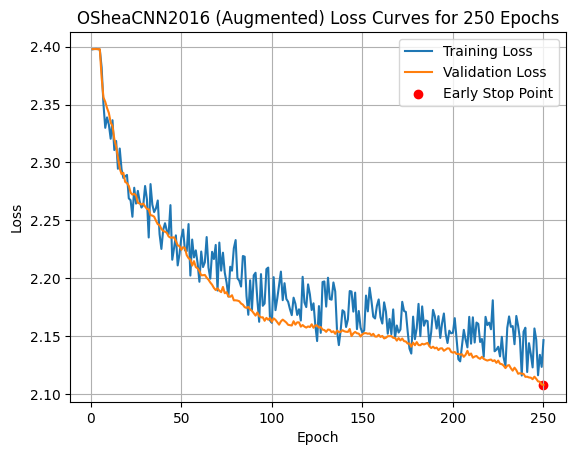

In [29]:
if(not(use_pretrained)): # Generate Loss Curves if Model was Recently Trained
    epoch_idx = np.arange(num_epochs) + 1
    plt.figure()
    plt.title(f'{model.name} (Augmented) Loss Curves for {num_epochs} Epochs')
    plt.plot(epoch_idx,train_loss)
    plt.plot(epoch_idx,val_loss)
    plt.scatter(np.argmin(val_loss)+1,np.min(val_loss),color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(['Training Loss', 'Validation Loss','Early Stop Point'])
    plt.savefig(f'./results/{model.name}_{num_epochs}_Loss_augmented.png')
    plt.show()

In [46]:
# Evaluating Based on SNR Threshold 
if(device == 'cuda'): # Free any Device Memory before Start Training
    torch.cuda.empty_cache()
augDir = './models/OSheaCNN2016_250_best_augmented.pt'
augModel = torch.load(augDir)
thresh = -20 # SNR Thresholdh in dB
idxThresh  = np.where(Z_test >= thresh)[0]
eval_data = test_data[idxThresh]
eval_data = torch.utils.data.TensorDataset(*eval_data)
eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
test_acc = models.train.eval(device,augModel,eval_loader)
print(f'Augmented Model Test Accuracy for Samples above {thresh} dB: {test_acc:.3f}')

Augmented Model Test Accuracy for Samples above -20 dB: 0.431


In [48]:
# Evaluate Test Accuracies
aug_accs = [] 
test_accs = []
modelDir = './models/OSheaCNN2016_250_best.pt'
augModel = torch.load(augDir)
model = torch.load(modelDir)
for SNR in SNRs:
    idxThresh  = np.where(Z_test >= SNR)[0]
    eval_data = test_data[idxThresh]
    eval_data = torch.utils.data.TensorDataset(*eval_data)
    eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
    test_accs.append(models.train.eval(device,model,eval_loader))
    aug_accs.append(models.train.eval(device,augModel,eval_loader))

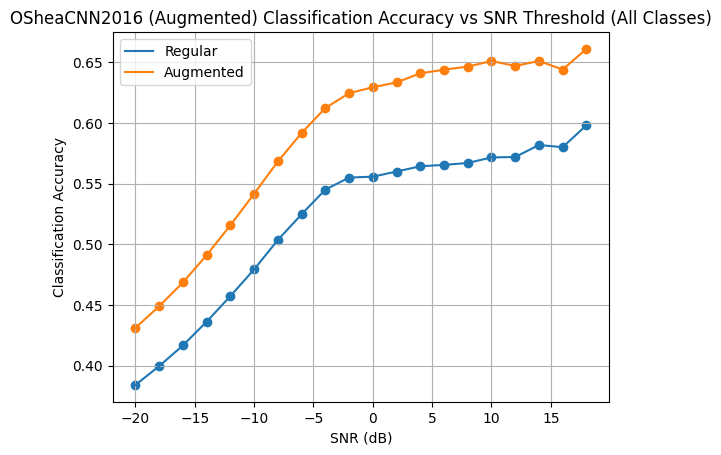

In [51]:
plt.figure()
plt.plot(SNRs,test_accs)
plt.plot(SNRs,aug_accs)
plt.scatter(SNRs,test_accs)
plt.scatter(SNRs,aug_accs)
plt.legend(['Regular','Augmented'])
plt.grid()
plt.title(f'{model.name} (Augmented) Classification Accuracy vs SNR Threshold (All Classes)')
plt.xlabel('SNR (dB)')
plt.ylabel('Classification Accuracy')
plt.savefig(f'./results/{os.path.basename(modelDir).split(".pt")[0]}_SNRClassification.png')
plt.show()

By applying data augmentation and keeping all other training parameters constant, the OSheaCNN2016 model improves accuracy by around **5-6\%** at high SNRs, and **3\%** overall. Models that are more data driven tend to perform bettter, so this improvement follows an expected trend!

### RadioML 2018.01A

In [53]:
# Split Data into Train,Val,Test Subsets (90-5-5)%

# Warning: Memory Intensive (Can Take Upwards of 64 GB)
split = np.array([90,5,5])/100
batch_size = 9000
augment = True
clearDatasetVars(tensors=True)
X,Y,Z,modClasses,SNRs = models.datasets.loadRadioML2018(radioML2018)
train_data,val_data,test_data,train_loader,val_loader,test_loader,Z_test = models.datasets.prepareDatasetRadioML(X,Y,Z,split,batch_size,augment)

# Freeing Memory of Intermediate Values
clearDatasetVars(tensors=False)

In [9]:
use_pretrained = False

# Define the loss function 
criterion = nn.CrossEntropyLoss()

if(use_pretrained): # Evaluate Pre-Trained Augmented Models
    modelDir = './models/OSheaCNN2018_100_best_augmented.pt'
    model = torch.load(modelDir)
    test_acc =  models.train.eval(device,model,test_loader)
    print(f'Overall Test Acc: {test_acc:.3f}')
else: # Training Model
    model = OSheaCNN2018().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)
    num_epochs = 100
    if(device == 'cuda'): # Free any Device Memory before Start Training
        torch.cuda.empty_cache()
    train_loss, val_loss, min_val_loss, best_model =  models.train.train_earlystop(device,model,criterion,optimizer,train_loader,val_loader,test_loader,num_epochs)
    torch.save(model,f'./models/OSheaCNN2018_{num_epochs}_last_augmented.pt')
    torch.save(best_model,f'./models/OSheaCNN2018_{num_epochs}_best_augmented.pt')
    test_last_acc = models.train.eval(device,model,test_loader)
    test_best_acc = models.train.eval(device,best_model,test_loader)
    print(f'\nOverall Test Acc (Last Epoch): {test_last_acc:.3f}')
    print(f'Overall Test Acc (Best Val): {test_best_acc:.3f}')


Starting to Train OSheaCNN2018 for 100 Epochs!


  1%|▊                                                                               | 1/100 [01:16<2:06:22, 76.59s/it]

Epoch [1/100]: Train Loss: 2.923 Val Loss: 2.944 Train Acc: 0.244, Val Acc: 0.296


  2%|█▌                                                                              | 2/100 [02:32<2:04:30, 76.23s/it]

Epoch [2/100]: Train Loss: 2.886 Val Loss: 2.910 Train Acc: 0.315, Val Acc: 0.326


  3%|██▍                                                                             | 3/100 [03:47<2:02:25, 75.73s/it]

Epoch [3/100]: Train Loss: 2.846 Val Loss: 2.852 Train Acc: 0.376, Val Acc: 0.388


  4%|███▏                                                                            | 4/100 [05:02<2:00:40, 75.42s/it]

Epoch [4/100]: Train Loss: 2.829 Val Loss: 2.838 Train Acc: 0.396, Val Acc: 0.396


  5%|████                                                                            | 5/100 [06:19<1:59:58, 75.77s/it]

Epoch [5/100]: Train Loss: 2.820 Val Loss: 2.833 Train Acc: 0.405, Val Acc: 0.405


  6%|████▊                                                                           | 6/100 [07:34<1:58:31, 75.66s/it]

Epoch [6/100]: Train Loss: 2.813 Val Loss: 2.827 Train Acc: 0.412, Val Acc: 0.412


  7%|█████▌                                                                          | 7/100 [08:49<1:57:03, 75.52s/it]

Epoch [7/100]: Train Loss: 2.832 Val Loss: 2.815 Train Acc: 0.419, Val Acc: 0.426


  8%|██████▍                                                                         | 8/100 [10:04<1:55:40, 75.44s/it]

Epoch [8/100]: Train Loss: 2.803 Val Loss: 2.802 Train Acc: 0.431, Val Acc: 0.434


  9%|███████▏                                                                        | 9/100 [11:20<1:54:20, 75.39s/it]

Epoch [9/100]: Train Loss: 2.790 Val Loss: 2.794 Train Acc: 0.439, Val Acc: 0.446


 10%|███████▉                                                                       | 10/100 [12:35<1:53:00, 75.34s/it]

Epoch [10/100]: Train Loss: 2.795 Val Loss: 2.794 Train Acc: 0.446, Val Acc: 0.446


 11%|████████▋                                                                      | 11/100 [13:50<1:51:38, 75.27s/it]

Epoch [11/100]: Train Loss: 2.778 Val Loss: 2.792 Train Acc: 0.453, Val Acc: 0.453


 12%|█████████▍                                                                     | 12/100 [15:05<1:50:23, 75.26s/it]

Epoch [12/100]: Train Loss: 2.771 Val Loss: 2.781 Train Acc: 0.460, Val Acc: 0.459


 13%|██████████▎                                                                    | 13/100 [16:20<1:49:03, 75.21s/it]

Epoch [13/100]: Train Loss: 2.773 Val Loss: 2.778 Train Acc: 0.465, Val Acc: 0.464


 14%|███████████                                                                    | 14/100 [17:36<1:47:44, 75.17s/it]

Epoch [14/100]: Train Loss: 2.761 Val Loss: 2.768 Train Acc: 0.473, Val Acc: 0.477


 15%|███████████▊                                                                   | 15/100 [18:51<1:46:27, 75.15s/it]

Epoch [15/100]: Train Loss: 2.772 Val Loss: 2.771 Train Acc: 0.478, Val Acc: 0.472


 16%|████████████▋                                                                  | 16/100 [20:06<1:45:15, 75.19s/it]

Epoch [16/100]: Train Loss: 2.773 Val Loss: 2.759 Train Acc: 0.484, Val Acc: 0.470


 17%|█████████████▍                                                                 | 17/100 [21:21<1:43:59, 75.17s/it]

Epoch [17/100]: Train Loss: 2.755 Val Loss: 2.746 Train Acc: 0.490, Val Acc: 0.496


 18%|██████████████▏                                                                | 18/100 [22:36<1:42:42, 75.15s/it]

Epoch [18/100]: Train Loss: 2.742 Val Loss: 2.742 Train Acc: 0.495, Val Acc: 0.501


 19%|███████████████                                                                | 19/100 [23:51<1:41:27, 75.16s/it]

Epoch [19/100]: Train Loss: 2.721 Val Loss: 2.734 Train Acc: 0.501, Val Acc: 0.506


 20%|███████████████▊                                                               | 20/100 [25:06<1:40:13, 75.16s/it]

Epoch [20/100]: Train Loss: 2.738 Val Loss: 2.733 Train Acc: 0.506, Val Acc: 0.513


 21%|████████████████▌                                                              | 21/100 [26:22<1:38:58, 75.17s/it]

Epoch [21/100]: Train Loss: 2.725 Val Loss: 2.726 Train Acc: 0.515, Val Acc: 0.518


 22%|█████████████████▍                                                             | 22/100 [27:37<1:37:42, 75.16s/it]

Epoch [22/100]: Train Loss: 2.725 Val Loss: 2.713 Train Acc: 0.529, Val Acc: 0.528


 23%|██████████████████▏                                                            | 23/100 [28:52<1:36:31, 75.21s/it]

Epoch [23/100]: Train Loss: 2.714 Val Loss: 2.706 Train Acc: 0.537, Val Acc: 0.539


 24%|██████████████████▉                                                            | 24/100 [30:07<1:35:16, 75.21s/it]

Epoch [24/100]: Train Loss: 2.676 Val Loss: 2.694 Train Acc: 0.543, Val Acc: 0.542


 25%|███████████████████▊                                                           | 25/100 [31:23<1:34:01, 75.22s/it]

Epoch [25/100]: Train Loss: 2.694 Val Loss: 2.706 Train Acc: 0.547, Val Acc: 0.532


 26%|████████████████████▌                                                          | 26/100 [32:38<1:32:47, 75.23s/it]

Epoch [26/100]: Train Loss: 2.674 Val Loss: 2.695 Train Acc: 0.550, Val Acc: 0.545


 27%|█████████████████████▎                                                         | 27/100 [33:53<1:31:30, 75.22s/it]

Epoch [27/100]: Train Loss: 2.698 Val Loss: 2.696 Train Acc: 0.553, Val Acc: 0.539


 28%|██████████████████████                                                         | 28/100 [35:08<1:30:15, 75.21s/it]

Epoch [28/100]: Train Loss: 2.689 Val Loss: 2.687 Train Acc: 0.556, Val Acc: 0.556


 29%|██████████████████████▉                                                        | 29/100 [36:23<1:28:57, 75.18s/it]

Epoch [29/100]: Train Loss: 2.687 Val Loss: 2.681 Train Acc: 0.559, Val Acc: 0.560


 30%|███████████████████████▋                                                       | 30/100 [37:39<1:27:44, 75.21s/it]

Epoch [30/100]: Train Loss: 2.689 Val Loss: 2.689 Train Acc: 0.561, Val Acc: 0.552


 31%|████████████████████████▍                                                      | 31/100 [38:54<1:26:28, 75.19s/it]

Epoch [31/100]: Train Loss: 2.690 Val Loss: 2.686 Train Acc: 0.562, Val Acc: 0.561


 32%|█████████████████████████▎                                                     | 32/100 [40:09<1:25:13, 75.20s/it]

Epoch [32/100]: Train Loss: 2.674 Val Loss: 2.687 Train Acc: 0.564, Val Acc: 0.556


 33%|██████████████████████████                                                     | 33/100 [41:24<1:23:53, 75.12s/it]

Epoch [33/100]: Train Loss: 2.694 Val Loss: 2.680 Train Acc: 0.565, Val Acc: 0.566


 34%|██████████████████████████▊                                                    | 34/100 [42:39<1:22:34, 75.06s/it]

Epoch [34/100]: Train Loss: 2.683 Val Loss: 2.679 Train Acc: 0.567, Val Acc: 0.569


 35%|███████████████████████████▋                                                   | 35/100 [43:54<1:21:14, 75.00s/it]

Epoch [35/100]: Train Loss: 2.669 Val Loss: 2.684 Train Acc: 0.568, Val Acc: 0.564


 36%|████████████████████████████▍                                                  | 36/100 [45:09<1:19:57, 74.96s/it]

Epoch [36/100]: Train Loss: 2.664 Val Loss: 2.675 Train Acc: 0.569, Val Acc: 0.568


 37%|█████████████████████████████▏                                                 | 37/100 [46:24<1:18:43, 74.97s/it]

Epoch [37/100]: Train Loss: 2.678 Val Loss: 2.677 Train Acc: 0.570, Val Acc: 0.570


 38%|██████████████████████████████                                                 | 38/100 [47:38<1:17:25, 74.93s/it]

Epoch [38/100]: Train Loss: 2.678 Val Loss: 2.684 Train Acc: 0.571, Val Acc: 0.561


 39%|██████████████████████████████▊                                                | 39/100 [48:53<1:16:11, 74.95s/it]

Epoch [39/100]: Train Loss: 2.656 Val Loss: 2.670 Train Acc: 0.572, Val Acc: 0.571


 40%|███████████████████████████████▌                                               | 40/100 [50:08<1:14:58, 74.97s/it]

Epoch [40/100]: Train Loss: 2.677 Val Loss: 2.670 Train Acc: 0.573, Val Acc: 0.575


 41%|████████████████████████████████▍                                              | 41/100 [51:23<1:13:42, 74.95s/it]

Epoch [41/100]: Train Loss: 2.655 Val Loss: 2.668 Train Acc: 0.574, Val Acc: 0.575


 42%|█████████████████████████████████▏                                             | 42/100 [52:38<1:12:25, 74.93s/it]

Epoch [42/100]: Train Loss: 2.673 Val Loss: 2.671 Train Acc: 0.575, Val Acc: 0.573


 43%|█████████████████████████████████▉                                             | 43/100 [53:53<1:11:10, 74.91s/it]

Epoch [43/100]: Train Loss: 2.670 Val Loss: 2.676 Train Acc: 0.575, Val Acc: 0.572


 44%|██████████████████████████████████▊                                            | 44/100 [55:08<1:09:57, 74.95s/it]

Epoch [44/100]: Train Loss: 2.673 Val Loss: 2.669 Train Acc: 0.576, Val Acc: 0.573


 45%|███████████████████████████████████▌                                           | 45/100 [56:23<1:08:41, 74.93s/it]

Epoch [45/100]: Train Loss: 2.668 Val Loss: 2.664 Train Acc: 0.577, Val Acc: 0.575


 46%|████████████████████████████████████▎                                          | 46/100 [57:38<1:07:25, 74.91s/it]

Epoch [46/100]: Train Loss: 2.675 Val Loss: 2.664 Train Acc: 0.577, Val Acc: 0.577


 47%|█████████████████████████████████████▏                                         | 47/100 [58:53<1:06:12, 74.94s/it]

Epoch [47/100]: Train Loss: 2.672 Val Loss: 2.673 Train Acc: 0.578, Val Acc: 0.572


 48%|████████████████████████████████████▉                                        | 48/100 [1:00:08<1:04:57, 74.96s/it]

Epoch [48/100]: Train Loss: 2.683 Val Loss: 2.669 Train Acc: 0.578, Val Acc: 0.570


 49%|█████████████████████████████████████▋                                       | 49/100 [1:01:23<1:03:42, 74.96s/it]

Epoch [49/100]: Train Loss: 2.676 Val Loss: 2.671 Train Acc: 0.579, Val Acc: 0.572


 50%|██████████████████████████████████████▌                                      | 50/100 [1:02:38<1:02:26, 74.94s/it]

Epoch [50/100]: Train Loss: 2.663 Val Loss: 2.667 Train Acc: 0.580, Val Acc: 0.579


 51%|███████████████████████████████████████▎                                     | 51/100 [1:03:53<1:01:13, 74.98s/it]

Epoch [51/100]: Train Loss: 2.648 Val Loss: 2.669 Train Acc: 0.580, Val Acc: 0.576


 52%|█████████████████████████████████████████                                      | 52/100 [1:05:08<59:58, 74.96s/it]

Epoch [52/100]: Train Loss: 2.654 Val Loss: 2.666 Train Acc: 0.581, Val Acc: 0.576


 53%|█████████████████████████████████████████▊                                     | 53/100 [1:06:23<58:42, 74.95s/it]

Epoch [53/100]: Train Loss: 2.658 Val Loss: 2.657 Train Acc: 0.581, Val Acc: 0.579


 54%|██████████████████████████████████████████▋                                    | 54/100 [1:07:38<57:28, 74.96s/it]

Epoch [54/100]: Train Loss: 2.682 Val Loss: 2.661 Train Acc: 0.581, Val Acc: 0.579


 55%|███████████████████████████████████████████▍                                   | 55/100 [1:08:53<56:12, 74.95s/it]

Epoch [55/100]: Train Loss: 2.639 Val Loss: 2.660 Train Acc: 0.582, Val Acc: 0.581


 56%|████████████████████████████████████████████▏                                  | 56/100 [1:10:08<54:59, 74.99s/it]

Epoch [56/100]: Train Loss: 2.675 Val Loss: 2.659 Train Acc: 0.583, Val Acc: 0.582


 57%|█████████████████████████████████████████████                                  | 57/100 [1:11:23<53:44, 74.98s/it]

Epoch [57/100]: Train Loss: 2.661 Val Loss: 2.663 Train Acc: 0.583, Val Acc: 0.573


 58%|█████████████████████████████████████████████▊                                 | 58/100 [1:12:38<52:30, 75.01s/it]

Epoch [58/100]: Train Loss: 2.641 Val Loss: 2.664 Train Acc: 0.583, Val Acc: 0.580


 59%|██████████████████████████████████████████████▌                                | 59/100 [1:13:53<51:14, 74.99s/it]

Epoch [59/100]: Train Loss: 2.653 Val Loss: 2.661 Train Acc: 0.583, Val Acc: 0.583


 60%|███████████████████████████████████████████████▍                               | 60/100 [1:15:08<49:59, 74.99s/it]

Epoch [60/100]: Train Loss: 2.655 Val Loss: 2.665 Train Acc: 0.584, Val Acc: 0.581


 61%|████████████████████████████████████████████████▏                              | 61/100 [1:16:23<48:46, 75.03s/it]

Epoch [61/100]: Train Loss: 2.663 Val Loss: 2.657 Train Acc: 0.584, Val Acc: 0.583


 62%|████████████████████████████████████████████████▉                              | 62/100 [1:17:38<47:30, 75.01s/it]

Epoch [62/100]: Train Loss: 2.661 Val Loss: 2.667 Train Acc: 0.585, Val Acc: 0.581


 63%|█████████████████████████████████████████████████▊                             | 63/100 [1:18:53<46:15, 75.01s/it]

Epoch [63/100]: Train Loss: 2.651 Val Loss: 2.658 Train Acc: 0.585, Val Acc: 0.583


 64%|██████████████████████████████████████████████████▌                            | 64/100 [1:20:08<44:59, 75.00s/it]

Epoch [64/100]: Train Loss: 2.665 Val Loss: 2.653 Train Acc: 0.586, Val Acc: 0.587


 65%|███████████████████████████████████████████████████▎                           | 65/100 [1:21:23<43:46, 75.04s/it]

Epoch [65/100]: Train Loss: 2.631 Val Loss: 2.665 Train Acc: 0.586, Val Acc: 0.576


 66%|████████████████████████████████████████████████████▏                          | 66/100 [1:22:38<42:30, 75.02s/it]

Epoch [66/100]: Train Loss: 2.657 Val Loss: 2.660 Train Acc: 0.586, Val Acc: 0.584


 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:23:53<41:15, 75.02s/it]

Epoch [67/100]: Train Loss: 2.665 Val Loss: 2.653 Train Acc: 0.586, Val Acc: 0.582


 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:25:10<40:23, 75.74s/it]

Epoch [68/100]: Train Loss: 2.653 Val Loss: 2.662 Train Acc: 0.586, Val Acc: 0.582


 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:26:25<39:02, 75.57s/it]

Epoch [69/100]: Train Loss: 2.661 Val Loss: 2.656 Train Acc: 0.587, Val Acc: 0.585


 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:27:41<37:44, 75.48s/it]

Epoch [70/100]: Train Loss: 2.658 Val Loss: 2.663 Train Acc: 0.587, Val Acc: 0.583


 71%|████████████████████████████████████████████████████████                       | 71/100 [1:28:56<36:26, 75.41s/it]

Epoch [71/100]: Train Loss: 2.673 Val Loss: 2.659 Train Acc: 0.587, Val Acc: 0.583


 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:30:11<35:12, 75.43s/it]

Epoch [72/100]: Train Loss: 2.665 Val Loss: 2.657 Train Acc: 0.588, Val Acc: 0.586


 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:31:27<33:54, 75.36s/it]

Epoch [73/100]: Train Loss: 2.659 Val Loss: 2.659 Train Acc: 0.588, Val Acc: 0.586


 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:32:42<32:39, 75.37s/it]

Epoch [74/100]: Train Loss: 2.659 Val Loss: 2.653 Train Acc: 0.588, Val Acc: 0.583


 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:33:57<31:23, 75.35s/it]

Epoch [75/100]: Train Loss: 2.657 Val Loss: 2.657 Train Acc: 0.588, Val Acc: 0.584


 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:35:13<30:07, 75.33s/it]

Epoch [76/100]: Train Loss: 2.651 Val Loss: 2.649 Train Acc: 0.589, Val Acc: 0.587


 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:36:28<28:50, 75.26s/it]

Epoch [77/100]: Train Loss: 2.636 Val Loss: 2.659 Train Acc: 0.589, Val Acc: 0.583


 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:37:43<27:34, 75.20s/it]

Epoch [78/100]: Train Loss: 2.657 Val Loss: 2.653 Train Acc: 0.589, Val Acc: 0.587


 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:38:58<26:18, 75.18s/it]

Epoch [79/100]: Train Loss: 2.641 Val Loss: 2.651 Train Acc: 0.589, Val Acc: 0.587


 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:40:13<25:04, 75.22s/it]

Epoch [80/100]: Train Loss: 2.662 Val Loss: 2.649 Train Acc: 0.590, Val Acc: 0.586


 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:41:28<23:47, 75.13s/it]

Epoch [81/100]: Train Loss: 2.657 Val Loss: 2.656 Train Acc: 0.590, Val Acc: 0.583


 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:42:43<22:31, 75.08s/it]

Epoch [82/100]: Train Loss: 2.654 Val Loss: 2.645 Train Acc: 0.590, Val Acc: 0.588


 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:43:58<21:15, 75.02s/it]

Epoch [83/100]: Train Loss: 2.649 Val Loss: 2.652 Train Acc: 0.590, Val Acc: 0.589


 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:45:13<19:59, 74.98s/it]

Epoch [84/100]: Train Loss: 2.660 Val Loss: 2.644 Train Acc: 0.590, Val Acc: 0.588


 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:46:28<18:44, 74.96s/it]

Epoch [85/100]: Train Loss: 2.669 Val Loss: 2.650 Train Acc: 0.591, Val Acc: 0.588


 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:47:43<17:29, 74.98s/it]

Epoch [86/100]: Train Loss: 2.655 Val Loss: 2.651 Train Acc: 0.591, Val Acc: 0.587


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:48:58<16:14, 74.98s/it]

Epoch [87/100]: Train Loss: 2.655 Val Loss: 2.654 Train Acc: 0.591, Val Acc: 0.586


 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:50:13<14:59, 74.98s/it]

Epoch [88/100]: Train Loss: 2.630 Val Loss: 2.653 Train Acc: 0.592, Val Acc: 0.588


 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:51:28<13:44, 74.97s/it]

Epoch [89/100]: Train Loss: 2.642 Val Loss: 2.653 Train Acc: 0.591, Val Acc: 0.586


 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:52:43<12:29, 74.96s/it]

Epoch [90/100]: Train Loss: 2.663 Val Loss: 2.651 Train Acc: 0.592, Val Acc: 0.589


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:53:57<11:14, 74.94s/it]

Epoch [91/100]: Train Loss: 2.626 Val Loss: 2.645 Train Acc: 0.592, Val Acc: 0.589


 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:55:12<09:59, 74.93s/it]

Epoch [92/100]: Train Loss: 2.639 Val Loss: 2.653 Train Acc: 0.592, Val Acc: 0.589


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:56:27<08:44, 74.97s/it]

Epoch [93/100]: Train Loss: 2.650 Val Loss: 2.651 Train Acc: 0.592, Val Acc: 0.588


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:57:42<07:29, 74.96s/it]

Epoch [94/100]: Train Loss: 2.637 Val Loss: 2.652 Train Acc: 0.593, Val Acc: 0.588


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:58:57<06:14, 74.95s/it]

Epoch [95/100]: Train Loss: 2.644 Val Loss: 2.652 Train Acc: 0.592, Val Acc: 0.591


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [2:00:12<04:59, 74.96s/it]

Epoch [96/100]: Train Loss: 2.617 Val Loss: 2.661 Train Acc: 0.593, Val Acc: 0.586


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [2:01:27<03:44, 74.94s/it]

Epoch [97/100]: Train Loss: 2.647 Val Loss: 2.657 Train Acc: 0.593, Val Acc: 0.584


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [2:02:42<02:29, 74.93s/it]

Epoch [98/100]: Train Loss: 2.647 Val Loss: 2.658 Train Acc: 0.593, Val Acc: 0.586


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [2:03:57<01:14, 74.91s/it]

Epoch [99/100]: Train Loss: 2.646 Val Loss: 2.652 Train Acc: 0.593, Val Acc: 0.590


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [2:05:12<00:00, 75.13s/it]

Epoch [100/100]: Train Loss: 2.640 Val Loss: 2.647 Train Acc: 0.593, Val Acc: 0.591



Overall Test Acc (Last Epoch): 0.589
Overall Test Acc (Best Val): 0.589


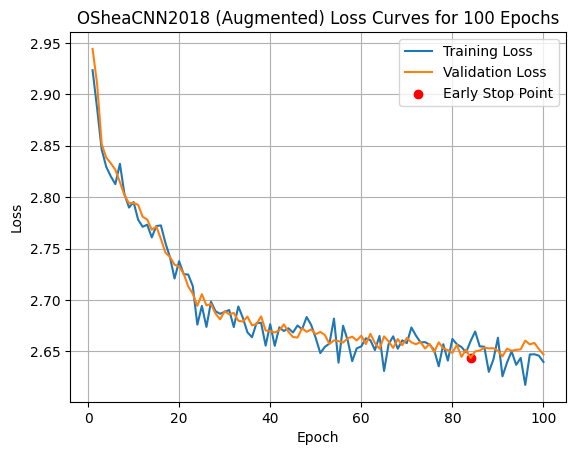

In [10]:
if(not(use_pretrained)): # Generate Loss Curves if Model was Recently Trained
    epoch_idx = np.arange(num_epochs) + 1
    plt.figure()
    plt.title(f'{model.name} (Augmented) Loss Curves for {num_epochs} Epochs')
    plt.plot(epoch_idx,train_loss)
    plt.plot(epoch_idx,val_loss)
    plt.scatter(np.argmin(val_loss)+1,np.min(val_loss),color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(['Training Loss', 'Validation Loss','Early Stop Point'])
    plt.savefig(f'./results/{model.name}_{num_epochs}_Loss_augmented.png')
    plt.show()

In [54]:
# Evaluating Based on SNR Threshold 
if(device == 'cuda'): # Free any Device Memory before Start Training
    torch.cuda.empty_cache()
augDir = './models/OSheaCNN2018_100_best_augmented.pt'
augModel = torch.load(augDir)
thresh = -20 # SNR Thresholdh in dB
idxThresh  = np.where(Z_test >= thresh)[0]
eval_data = test_data[idxThresh]
eval_data = torch.utils.data.TensorDataset(*eval_data)
eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
test_acc = models.train.eval(device,augModel,eval_loader)
print(f'Augmented Model Test Accuracy for Samples above {thresh} dB: {test_acc:.3f}')

Augmented Model Test Accuracy for Samples above -20 dB: 0.589


In [55]:
# Evaluate Test Accuracies
aug_accs = [] 
test_accs = []
modelDir = './models/OSheaCNN2018_100_best.pt'
augModel = torch.load(augDir)
model = torch.load(modelDir)
for SNR in SNRs:
    idxThresh  = np.where(Z_test >= SNR)[0]
    eval_data = test_data[idxThresh]
    eval_data = torch.utils.data.TensorDataset(*eval_data)
    eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
    test_accs.append(models.train.eval(device,model,eval_loader))
    aug_accs.append(models.train.eval(device,augModel,eval_loader))

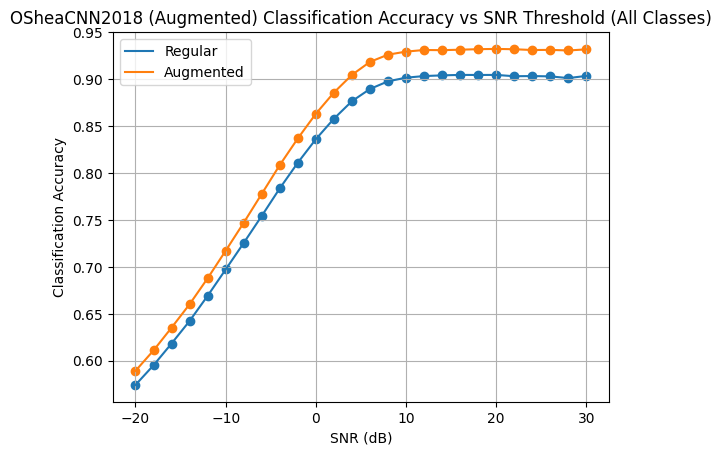

In [56]:
plt.figure()
plt.plot(SNRs,test_accs)
plt.plot(SNRs,aug_accs)
plt.scatter(SNRs,test_accs)
plt.scatter(SNRs,aug_accs)
plt.legend(['Regular','Augmented'])
plt.grid()
plt.title(f'{model.name} (Augmented) Classification Accuracy vs SNR Threshold (All Classes)')
plt.xlabel('SNR (dB)')
plt.ylabel('Classification Accuracy')
plt.savefig(f'./results/{os.path.basename(modelDir).split(".pt")[0]}_SNRClassification.png')
plt.show()

By applying data augmentation and keeping all other training parameters constant, the OSheaCNN2016 model improves accuracy by around **2-3\%** at high SNRs, and **3\%** overall. Models that are more data driven tend to perform bettter, so this improvement follows an expected trend!

### HisarMod 2019.1

In [3]:
# Split Data into Train,Val into (80-20)%, Test Set is Already Seperate

# Warning: Memory Intensive (Can Take Upwards of 32 GB) & Can Take a Few Mins to Load
split = np.array([80,20])/100
batch_size = 9000
augment = True
clearDatasetVars(tensors=True)
X_train_val,X_test,Y_train_val,Y_test,Z_train_val,Z_test,SNRs,modClasses =  models.datasets.loadHisar(hisar2019Dir)
train_data,val_data,test_data,train_loader,val_loader,test_loader = models.datasets.prepareDatasetHisar(X_train_val,X_test,Y_train_val,Y_test,split,batch_size,augment)

# Freeing Memory of Intermediate Values
clearDatasetVars(tensors=False)

In [4]:
use_pretrained = False

# Define the loss function 
criterion = nn.CrossEntropyLoss()

if(use_pretrained): # Evaluate Pre-Trained Models
    modelDir = './models/HisarCNN2019_100_best_augmented.pt'
    model = torch.load(modelDir)
    test_acc =  models.train.eval(device,model,test_loader)
    print(f'Overall Test Acc: {test_acc:.3f}')
else: # Training Model
    model = HisarCNN2019().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)
    num_epochs = 100
    if(device == 'cuda'): # Free any Device Memory before Start Training
        torch.cuda.empty_cache()
    train_loss, val_loss, min_val_loss, best_model =  models.train.train_earlystop(device,model,criterion,optimizer,train_loader,val_loader,test_loader,num_epochs)
    torch.save(model,f'./models/HisarCNN2019_{num_epochs}_last_augmented.pt')
    torch.save(best_model,f'./models/HisarCNN2019_{num_epochs}_best_augmented.pt')
    test_last_acc = models.train.eval(device,model,test_loader)
    test_best_acc = models.train.eval(device,best_model,test_loader)
    print(f'\nOverall Test Acc (Last Epoch): {test_last_acc:.3f}')
    print(f'Overall Test Acc (Best Val): {test_best_acc:.3f}')


Starting to Train HisarCNN2019 for 100 Epochs!


  1%|▊                                                                                 | 1/100 [00:18<30:21, 18.40s/it]

Epoch [1/100]: Train Loss: 3.077 Val Loss: 3.091 Train Acc: 0.177, Val Acc: 0.220


  2%|█▋                                                                                | 2/100 [00:32<25:56, 15.89s/it]

Epoch [2/100]: Train Loss: 3.053 Val Loss: 3.057 Train Acc: 0.256, Val Acc: 0.263


  3%|██▍                                                                               | 3/100 [00:46<24:26, 15.12s/it]

Epoch [3/100]: Train Loss: 3.006 Val Loss: 3.016 Train Acc: 0.290, Val Acc: 0.306


  4%|███▎                                                                              | 4/100 [01:00<23:36, 14.76s/it]

Epoch [4/100]: Train Loss: 3.008 Val Loss: 3.003 Train Acc: 0.309, Val Acc: 0.317


  5%|████                                                                              | 5/100 [01:15<23:03, 14.56s/it]

Epoch [5/100]: Train Loss: 2.994 Val Loss: 3.005 Train Acc: 0.316, Val Acc: 0.317


  6%|████▉                                                                             | 6/100 [01:29<22:39, 14.46s/it]

Epoch [6/100]: Train Loss: 2.980 Val Loss: 2.999 Train Acc: 0.321, Val Acc: 0.325


  7%|█████▋                                                                            | 7/100 [01:43<22:18, 14.39s/it]

Epoch [7/100]: Train Loss: 2.991 Val Loss: 2.995 Train Acc: 0.325, Val Acc: 0.326


  8%|██████▌                                                                           | 8/100 [01:57<21:58, 14.33s/it]

Epoch [8/100]: Train Loss: 2.978 Val Loss: 2.994 Train Acc: 0.331, Val Acc: 0.329


  9%|███████▍                                                                          | 9/100 [02:12<21:41, 14.31s/it]

Epoch [9/100]: Train Loss: 2.975 Val Loss: 2.977 Train Acc: 0.335, Val Acc: 0.343


 10%|████████                                                                         | 10/100 [02:26<21:27, 14.31s/it]

Epoch [10/100]: Train Loss: 2.975 Val Loss: 2.973 Train Acc: 0.342, Val Acc: 0.344


 11%|████████▉                                                                        | 11/100 [02:40<21:13, 14.31s/it]

Epoch [11/100]: Train Loss: 2.956 Val Loss: 2.957 Train Acc: 0.357, Val Acc: 0.364


 12%|█████████▋                                                                       | 12/100 [02:55<20:59, 14.31s/it]

Epoch [12/100]: Train Loss: 2.931 Val Loss: 2.936 Train Acc: 0.378, Val Acc: 0.385


 13%|██████████▌                                                                      | 13/100 [03:09<20:44, 14.30s/it]

Epoch [13/100]: Train Loss: 2.923 Val Loss: 2.926 Train Acc: 0.387, Val Acc: 0.395


 14%|███████████▎                                                                     | 14/100 [03:23<20:32, 14.33s/it]

Epoch [14/100]: Train Loss: 2.918 Val Loss: 2.919 Train Acc: 0.400, Val Acc: 0.401


 15%|████████████▏                                                                    | 15/100 [03:38<20:17, 14.33s/it]

Epoch [15/100]: Train Loss: 2.906 Val Loss: 2.909 Train Acc: 0.405, Val Acc: 0.413


 16%|████████████▉                                                                    | 16/100 [03:52<20:02, 14.31s/it]

Epoch [16/100]: Train Loss: 2.896 Val Loss: 2.907 Train Acc: 0.416, Val Acc: 0.416


 17%|█████████████▊                                                                   | 17/100 [04:06<19:47, 14.31s/it]

Epoch [17/100]: Train Loss: 2.888 Val Loss: 2.906 Train Acc: 0.420, Val Acc: 0.417


 18%|██████████████▌                                                                  | 18/100 [04:20<19:34, 14.32s/it]

Epoch [18/100]: Train Loss: 2.890 Val Loss: 2.896 Train Acc: 0.422, Val Acc: 0.426


 19%|███████████████▍                                                                 | 19/100 [04:35<19:19, 14.32s/it]

Epoch [19/100]: Train Loss: 2.897 Val Loss: 2.912 Train Acc: 0.429, Val Acc: 0.406


 20%|████████████████▏                                                                | 20/100 [04:49<19:04, 14.30s/it]

Epoch [20/100]: Train Loss: 2.896 Val Loss: 2.900 Train Acc: 0.430, Val Acc: 0.425


 21%|█████████████████                                                                | 21/100 [05:03<18:49, 14.30s/it]

Epoch [21/100]: Train Loss: 2.905 Val Loss: 2.888 Train Acc: 0.437, Val Acc: 0.428


 22%|█████████████████▊                                                               | 22/100 [05:18<18:36, 14.31s/it]

Epoch [22/100]: Train Loss: 2.868 Val Loss: 2.883 Train Acc: 0.442, Val Acc: 0.439


 23%|██████████████████▋                                                              | 23/100 [05:32<18:21, 14.31s/it]

Epoch [23/100]: Train Loss: 2.861 Val Loss: 2.881 Train Acc: 0.445, Val Acc: 0.442


 24%|███████████████████▍                                                             | 24/100 [05:46<18:06, 14.30s/it]

Epoch [24/100]: Train Loss: 2.864 Val Loss: 2.880 Train Acc: 0.447, Val Acc: 0.445


 25%|████████████████████▎                                                            | 25/100 [06:01<17:51, 14.29s/it]

Epoch [25/100]: Train Loss: 2.853 Val Loss: 2.870 Train Acc: 0.453, Val Acc: 0.450


 26%|█████████████████████                                                            | 26/100 [06:15<17:37, 14.30s/it]

Epoch [26/100]: Train Loss: 2.882 Val Loss: 2.894 Train Acc: 0.454, Val Acc: 0.430


 27%|█████████████████████▊                                                           | 27/100 [06:29<17:22, 14.29s/it]

Epoch [27/100]: Train Loss: 2.853 Val Loss: 2.884 Train Acc: 0.457, Val Acc: 0.439


 28%|██████████████████████▋                                                          | 28/100 [06:43<17:07, 14.27s/it]

Epoch [28/100]: Train Loss: 2.854 Val Loss: 2.872 Train Acc: 0.462, Val Acc: 0.453


 29%|███████████████████████▍                                                         | 29/100 [06:58<16:52, 14.26s/it]

Epoch [29/100]: Train Loss: 2.857 Val Loss: 2.874 Train Acc: 0.466, Val Acc: 0.449


 30%|████████████████████████▎                                                        | 30/100 [07:12<16:46, 14.37s/it]

Epoch [30/100]: Train Loss: 2.857 Val Loss: 2.864 Train Acc: 0.467, Val Acc: 0.461


 31%|█████████████████████████                                                        | 31/100 [07:27<16:35, 14.43s/it]

Epoch [31/100]: Train Loss: 2.842 Val Loss: 2.862 Train Acc: 0.470, Val Acc: 0.459


 32%|█████████████████████████▉                                                       | 32/100 [07:41<16:19, 14.41s/it]

Epoch [32/100]: Train Loss: 2.834 Val Loss: 2.859 Train Acc: 0.474, Val Acc: 0.466


 33%|██████████████████████████▋                                                      | 33/100 [07:56<16:04, 14.39s/it]

Epoch [33/100]: Train Loss: 2.838 Val Loss: 2.851 Train Acc: 0.479, Val Acc: 0.470


 34%|███████████████████████████▌                                                     | 34/100 [08:10<15:50, 14.40s/it]

Epoch [34/100]: Train Loss: 2.837 Val Loss: 2.852 Train Acc: 0.482, Val Acc: 0.467


 35%|████████████████████████████▎                                                    | 35/100 [08:24<15:33, 14.36s/it]

Epoch [35/100]: Train Loss: 2.845 Val Loss: 2.849 Train Acc: 0.485, Val Acc: 0.472


 36%|█████████████████████████████▏                                                   | 36/100 [08:39<15:18, 14.35s/it]

Epoch [36/100]: Train Loss: 2.841 Val Loss: 2.850 Train Acc: 0.489, Val Acc: 0.471


 37%|█████████████████████████████▉                                                   | 37/100 [08:53<15:02, 14.32s/it]

Epoch [37/100]: Train Loss: 2.835 Val Loss: 2.848 Train Acc: 0.491, Val Acc: 0.477


 38%|██████████████████████████████▊                                                  | 38/100 [09:07<14:47, 14.32s/it]

Epoch [38/100]: Train Loss: 2.825 Val Loss: 2.850 Train Acc: 0.494, Val Acc: 0.471


 39%|███████████████████████████████▌                                                 | 39/100 [09:21<14:32, 14.31s/it]

Epoch [39/100]: Train Loss: 2.832 Val Loss: 2.850 Train Acc: 0.498, Val Acc: 0.472


 40%|████████████████████████████████▍                                                | 40/100 [09:36<14:17, 14.28s/it]

Epoch [40/100]: Train Loss: 2.822 Val Loss: 2.847 Train Acc: 0.497, Val Acc: 0.476


 41%|█████████████████████████████████▏                                               | 41/100 [09:50<14:02, 14.27s/it]

Epoch [41/100]: Train Loss: 2.812 Val Loss: 2.851 Train Acc: 0.502, Val Acc: 0.471


 42%|██████████████████████████████████                                               | 42/100 [10:04<13:48, 14.28s/it]

Epoch [42/100]: Train Loss: 2.819 Val Loss: 2.841 Train Acc: 0.505, Val Acc: 0.478


 43%|██████████████████████████████████▊                                              | 43/100 [10:18<13:33, 14.27s/it]

Epoch [43/100]: Train Loss: 2.817 Val Loss: 2.838 Train Acc: 0.507, Val Acc: 0.483


 44%|███████████████████████████████████▋                                             | 44/100 [10:33<13:18, 14.26s/it]

Epoch [44/100]: Train Loss: 2.810 Val Loss: 2.830 Train Acc: 0.511, Val Acc: 0.492


 45%|████████████████████████████████████▍                                            | 45/100 [10:47<13:04, 14.25s/it]

Epoch [45/100]: Train Loss: 2.817 Val Loss: 2.839 Train Acc: 0.512, Val Acc: 0.486


 46%|█████████████████████████████████████▎                                           | 46/100 [11:01<12:50, 14.26s/it]

Epoch [46/100]: Train Loss: 2.802 Val Loss: 2.825 Train Acc: 0.515, Val Acc: 0.495


 47%|██████████████████████████████████████                                           | 47/100 [11:15<12:35, 14.26s/it]

Epoch [47/100]: Train Loss: 2.812 Val Loss: 2.822 Train Acc: 0.520, Val Acc: 0.500


 48%|██████████████████████████████████████▉                                          | 48/100 [11:30<12:20, 14.25s/it]

Epoch [48/100]: Train Loss: 2.794 Val Loss: 2.829 Train Acc: 0.520, Val Acc: 0.495


 49%|███████████████████████████████████████▋                                         | 49/100 [11:44<12:06, 14.25s/it]

Epoch [49/100]: Train Loss: 2.800 Val Loss: 2.824 Train Acc: 0.522, Val Acc: 0.497


 50%|████████████████████████████████████████▌                                        | 50/100 [11:58<11:52, 14.26s/it]

Epoch [50/100]: Train Loss: 2.791 Val Loss: 2.821 Train Acc: 0.528, Val Acc: 0.500


 51%|█████████████████████████████████████████▎                                       | 51/100 [12:12<11:38, 14.26s/it]

Epoch [51/100]: Train Loss: 2.798 Val Loss: 2.820 Train Acc: 0.527, Val Acc: 0.503


 52%|██████████████████████████████████████████                                       | 52/100 [12:27<11:23, 14.25s/it]

Epoch [52/100]: Train Loss: 2.794 Val Loss: 2.819 Train Acc: 0.531, Val Acc: 0.506


 53%|██████████████████████████████████████████▉                                      | 53/100 [12:41<11:16, 14.40s/it]

Epoch [53/100]: Train Loss: 2.787 Val Loss: 2.814 Train Acc: 0.534, Val Acc: 0.506


 54%|███████████████████████████████████████████▋                                     | 54/100 [12:56<11:04, 14.44s/it]

Epoch [54/100]: Train Loss: 2.771 Val Loss: 2.815 Train Acc: 0.535, Val Acc: 0.506


 55%|████████████████████████████████████████████▌                                    | 55/100 [13:10<10:47, 14.39s/it]

Epoch [55/100]: Train Loss: 2.786 Val Loss: 2.814 Train Acc: 0.538, Val Acc: 0.506


 56%|█████████████████████████████████████████████▎                                   | 56/100 [13:24<10:30, 14.34s/it]

Epoch [56/100]: Train Loss: 2.795 Val Loss: 2.809 Train Acc: 0.543, Val Acc: 0.511


 57%|██████████████████████████████████████████████▏                                  | 57/100 [13:39<10:15, 14.31s/it]

Epoch [57/100]: Train Loss: 2.800 Val Loss: 2.811 Train Acc: 0.540, Val Acc: 0.507


 58%|██████████████████████████████████████████████▉                                  | 58/100 [13:53<10:00, 14.31s/it]

Epoch [58/100]: Train Loss: 2.775 Val Loss: 2.816 Train Acc: 0.543, Val Acc: 0.505


 59%|███████████████████████████████████████████████▊                                 | 59/100 [14:07<09:46, 14.30s/it]

Epoch [59/100]: Train Loss: 2.790 Val Loss: 2.806 Train Acc: 0.547, Val Acc: 0.513


 60%|████████████████████████████████████████████████▌                                | 60/100 [14:21<09:31, 14.28s/it]

Epoch [60/100]: Train Loss: 2.794 Val Loss: 2.811 Train Acc: 0.552, Val Acc: 0.509


 61%|█████████████████████████████████████████████████▍                               | 61/100 [14:36<09:16, 14.27s/it]

Epoch [61/100]: Train Loss: 2.772 Val Loss: 2.806 Train Acc: 0.551, Val Acc: 0.516


 62%|██████████████████████████████████████████████████▏                              | 62/100 [14:50<09:02, 14.28s/it]

Epoch [62/100]: Train Loss: 2.775 Val Loss: 2.814 Train Acc: 0.553, Val Acc: 0.510


 63%|███████████████████████████████████████████████████                              | 63/100 [15:04<08:48, 14.27s/it]

Epoch [63/100]: Train Loss: 2.763 Val Loss: 2.799 Train Acc: 0.556, Val Acc: 0.518


 64%|███████████████████████████████████████████████████▊                             | 64/100 [15:19<08:33, 14.27s/it]

Epoch [64/100]: Train Loss: 2.775 Val Loss: 2.805 Train Acc: 0.558, Val Acc: 0.518


 65%|████████████████████████████████████████████████████▋                            | 65/100 [15:33<08:19, 14.26s/it]

Epoch [65/100]: Train Loss: 2.777 Val Loss: 2.803 Train Acc: 0.561, Val Acc: 0.518


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [15:47<08:05, 14.28s/it]

Epoch [66/100]: Train Loss: 2.758 Val Loss: 2.805 Train Acc: 0.564, Val Acc: 0.516


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [16:01<07:51, 14.28s/it]

Epoch [67/100]: Train Loss: 2.754 Val Loss: 2.801 Train Acc: 0.561, Val Acc: 0.519


 68%|███████████████████████████████████████████████████████                          | 68/100 [16:16<07:36, 14.26s/it]

Epoch [68/100]: Train Loss: 2.766 Val Loss: 2.795 Train Acc: 0.566, Val Acc: 0.524


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [16:30<07:22, 14.26s/it]

Epoch [69/100]: Train Loss: 2.766 Val Loss: 2.800 Train Acc: 0.564, Val Acc: 0.521


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [16:44<07:08, 14.27s/it]

Epoch [70/100]: Train Loss: 2.765 Val Loss: 2.793 Train Acc: 0.566, Val Acc: 0.527


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [16:59<06:54, 14.31s/it]

Epoch [71/100]: Train Loss: 2.744 Val Loss: 2.796 Train Acc: 0.575, Val Acc: 0.526


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [17:13<06:40, 14.29s/it]

Epoch [72/100]: Train Loss: 2.760 Val Loss: 2.799 Train Acc: 0.574, Val Acc: 0.527


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [17:27<06:25, 14.28s/it]

Epoch [73/100]: Train Loss: 2.756 Val Loss: 2.799 Train Acc: 0.572, Val Acc: 0.524


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [17:41<06:11, 14.28s/it]

Epoch [74/100]: Train Loss: 2.747 Val Loss: 2.791 Train Acc: 0.578, Val Acc: 0.530


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [17:56<05:57, 14.29s/it]

Epoch [75/100]: Train Loss: 2.752 Val Loss: 2.799 Train Acc: 0.577, Val Acc: 0.525


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [18:10<05:42, 14.27s/it]

Epoch [76/100]: Train Loss: 2.764 Val Loss: 2.791 Train Acc: 0.580, Val Acc: 0.528


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [18:24<05:28, 14.26s/it]

Epoch [77/100]: Train Loss: 2.751 Val Loss: 2.792 Train Acc: 0.581, Val Acc: 0.528


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [18:38<05:14, 14.27s/it]

Epoch [78/100]: Train Loss: 2.734 Val Loss: 2.784 Train Acc: 0.583, Val Acc: 0.533


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [18:53<04:59, 14.28s/it]

Epoch [79/100]: Train Loss: 2.754 Val Loss: 2.787 Train Acc: 0.585, Val Acc: 0.536


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [19:07<04:45, 14.27s/it]

Epoch [80/100]: Train Loss: 2.730 Val Loss: 2.786 Train Acc: 0.586, Val Acc: 0.533


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [19:21<04:31, 14.26s/it]

Epoch [81/100]: Train Loss: 2.740 Val Loss: 2.782 Train Acc: 0.588, Val Acc: 0.538


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [19:35<04:16, 14.27s/it]

Epoch [82/100]: Train Loss: 2.745 Val Loss: 2.791 Train Acc: 0.590, Val Acc: 0.532


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [19:50<04:02, 14.28s/it]

Epoch [83/100]: Train Loss: 2.737 Val Loss: 2.781 Train Acc: 0.589, Val Acc: 0.537


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [20:04<03:48, 14.27s/it]

Epoch [84/100]: Train Loss: 2.759 Val Loss: 2.784 Train Acc: 0.590, Val Acc: 0.538


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [20:18<03:34, 14.27s/it]

Epoch [85/100]: Train Loss: 2.732 Val Loss: 2.786 Train Acc: 0.592, Val Acc: 0.535


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [20:33<03:19, 14.28s/it]

Epoch [86/100]: Train Loss: 2.727 Val Loss: 2.783 Train Acc: 0.593, Val Acc: 0.536


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [20:47<03:07, 14.41s/it]

Epoch [87/100]: Train Loss: 2.723 Val Loss: 2.788 Train Acc: 0.594, Val Acc: 0.537


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [21:02<02:53, 14.46s/it]

Epoch [88/100]: Train Loss: 2.746 Val Loss: 2.782 Train Acc: 0.599, Val Acc: 0.540


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [21:16<02:39, 14.49s/it]

Epoch [89/100]: Train Loss: 2.713 Val Loss: 2.777 Train Acc: 0.601, Val Acc: 0.541


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [21:31<02:25, 14.54s/it]

Epoch [90/100]: Train Loss: 2.720 Val Loss: 2.775 Train Acc: 0.599, Val Acc: 0.546


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [21:46<02:11, 14.56s/it]

Epoch [91/100]: Train Loss: 2.723 Val Loss: 2.777 Train Acc: 0.603, Val Acc: 0.539


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [22:00<01:56, 14.61s/it]

Epoch [92/100]: Train Loss: 2.722 Val Loss: 2.774 Train Acc: 0.601, Val Acc: 0.543


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [22:15<01:42, 14.64s/it]

Epoch [93/100]: Train Loss: 2.734 Val Loss: 2.777 Train Acc: 0.605, Val Acc: 0.543


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [22:30<01:27, 14.60s/it]

Epoch [94/100]: Train Loss: 2.718 Val Loss: 2.780 Train Acc: 0.605, Val Acc: 0.541


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [22:44<01:12, 14.52s/it]

Epoch [95/100]: Train Loss: 2.719 Val Loss: 2.782 Train Acc: 0.606, Val Acc: 0.541


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [22:58<00:57, 14.43s/it]

Epoch [96/100]: Train Loss: 2.698 Val Loss: 2.778 Train Acc: 0.608, Val Acc: 0.544


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [23:13<00:43, 14.39s/it]

Epoch [97/100]: Train Loss: 2.716 Val Loss: 2.775 Train Acc: 0.607, Val Acc: 0.545


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [23:27<00:28, 14.37s/it]

Epoch [98/100]: Train Loss: 2.715 Val Loss: 2.773 Train Acc: 0.610, Val Acc: 0.545


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [23:41<00:14, 14.34s/it]

Epoch [99/100]: Train Loss: 2.728 Val Loss: 2.779 Train Acc: 0.611, Val Acc: 0.540


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [23:55<00:00, 14.36s/it]

Epoch [100/100]: Train Loss: 2.718 Val Loss: 2.779 Train Acc: 0.608, Val Acc: 0.540



Overall Test Acc (Last Epoch): 0.548
Overall Test Acc (Best Val): 0.548


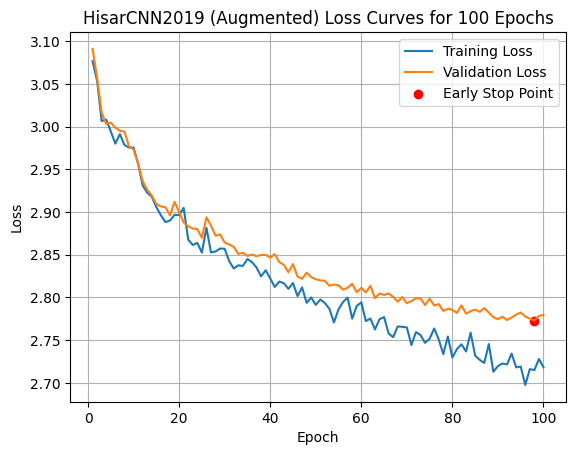

In [5]:
if(not(use_pretrained)): # Generate Loss Curves if Model was Recently Trained
    epoch_idx = np.arange(num_epochs) + 1
    plt.figure()
    plt.title(f'{model.name} (Augmented) Loss Curves for {num_epochs} Epochs')
    plt.plot(epoch_idx,train_loss)
    plt.plot(epoch_idx,val_loss)
    plt.scatter(np.argmin(val_loss)+1,np.min(val_loss),color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(['Training Loss', 'Validation Loss','Early Stop Point'])
    plt.savefig(f'./results/{model.name}_{num_epochs}_Loss_augmented.png')
    plt.show()

In [9]:
# Evaluating Based on SNR Threshold 
if(device == 'cuda'): # Free any Device Memory before Start Training
    torch.cuda.empty_cache()
augDir = './models/HisarCNN2019_100_best_augmented.pt'
augModel = torch.load(augDir)
thresh = 18 # SNR Thresholdh in dB
idxThresh  = np.where(Z_test >= thresh)[0]
eval_data = test_data[idxThresh]
eval_data = torch.utils.data.TensorDataset(*eval_data)
eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
test_acc = models.train.eval(device,augModel,eval_loader)
print(f'Augmented Model Test Accuracy for Samples above {thresh} dB: {test_acc:.3f}')

Augmented Model Test Accuracy for Samples above 18 dB: 0.746


In [10]:
# Evaluate Test Accuracies
aug_accs = [] 
test_accs = []
modelDir = './models/HisarCNN2019_100_best.pt'
augModel = torch.load(augDir)
model = torch.load(modelDir)
for SNR in SNRs:
    idxThresh  = np.where(Z_test >= SNR)[0]
    eval_data = test_data[idxThresh]
    eval_data = torch.utils.data.TensorDataset(*eval_data)
    eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
    test_accs.append(models.train.eval(device,model,eval_loader))
    aug_accs.append(models.train.eval(device,augModel,eval_loader))

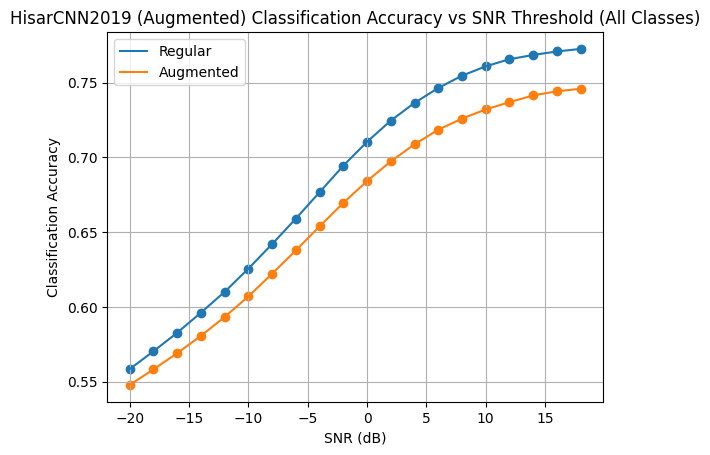

In [11]:
plt.figure()
plt.plot(SNRs,test_accs)
plt.plot(SNRs,aug_accs)
plt.scatter(SNRs,test_accs)
plt.scatter(SNRs,aug_accs)
plt.legend(['Regular','Augmented'])
plt.grid()
plt.title(f'{model.name} (Augmented) Classification Accuracy vs SNR Threshold (All Classes)')
plt.xlabel('SNR (dB)')
plt.ylabel('Classification Accuracy')
plt.savefig(f'./results/{os.path.basename(modelDir).split(".pt")[0]}_SNRClassification.png')
plt.show()

Applying data augmentation to the HisarMod 2019.1 dataset actually decreased overall performance by around **2-3\%** across all SNRs. A plausbile explanation for this is that the model starts to become slightly overfit at the last few epochs. This is apparent as the gap between the training and validation loss increases as training goes on. 